# Comparison of BRCA1 vs. 2 discrimination by multiple models 

The purpose of this notebook is to measure performance of multiple models for predicting BRCA1/2-ness.
This includes:
- Random forest with HRDetect features augmented with KH SV features (Dup 1-100 Kbp, ihdel, qrdel, qrdup, tib)
- Random forest with HRDetect features only
- CHORD out-of-box predictions on our test dataset
- Random forest with CHORD features augmented with KH SV features (Dup 1-100 Kbp, ihdel, qrdel, qrdup, tib)
- Random forest with CHORD features

This notebook will generate the data used for **Figure 5** and **Extended Data Figure 8**.

# Load dependencies

In [173]:
suppressWarnings(suppressPackageStartupMessages({
    library(ggplot2)
    library(pROC)
    library(yardstick)
    library(dplyr)
}))

# Load data

Read features and genotype annotations

In [1]:
## genotypes generated by Kevin and updated by Zi
hrd_tbl = readRDS("./data/hrd-supp-table_ZC.rds")

## HRDetect features generated by Zi
hrdetect.features.dt = readRDS("./data/revision.features.dt.rds")

## CHORD features from Kevin
chord.features.dt = readRDS("./data/chord_oob_table.rds")

In [2]:
## monge chord features to be consistent with their paper
chord.features.dt[, ca_raw := rowSums(.SD), .SDcols = grep("\\[C>A\\]", names(chord.features.dt), value = TRUE)]
chord.features.dt[, cg_raw := rowSums(.SD), .SDcols = grep("\\[C>G\\]", names(chord.features.dt), value = TRUE)]
chord.features.dt[, ct_raw := rowSums(.SD), .SDcols = grep("\\[C>T\\]", names(chord.features.dt), value = TRUE)]
chord.features.dt[, ta_raw := rowSums(.SD), .SDcols = grep("\\[T>A\\]", names(chord.features.dt), value = TRUE)]
chord.features.dt[, tg_raw := rowSums(.SD), .SDcols = grep("\\[T>G\\]", names(chord.features.dt), value = TRUE)]
chord.features.dt[, tc_raw := rowSums(.SD), .SDcols = grep("\\[T>C\\]", names(chord.features.dt), value = TRUE)]

## convert to "relative counts"
chord.features.dt[, snv_total := pmax(ca_raw + cg_raw + ct_raw + ta_raw + tg_raw + tc_raw, 1)] ## prevent zero division errors
chord.features.dt[, ca := ca_raw / snv_total]
chord.features.dt[, cg := cg_raw / snv_total]
chord.features.dt[, ct := ct_raw / snv_total]
chord.features.dt[, ta := ta_raw / snv_total]
chord.features.dt[, tg := tg_raw / snv_total]
chord.features.dt[, tc := tc_raw / snv_total]

## indel features
chord.features.dt[, del.mh.bimh.1_raw := copy(del.mh.bimh.1)]
chord.features.dt[, del.mh.bimh.2.5_raw := del.mh.bimh.2 + del.mh.bimh.3 + del.mh.bimh.4 + del.mh.bimh.5]
chord.features.dt[, ins.mh_raw := rowSums(.SD), .SDcols = grep("ins\\.mh", names(chord.features.dt), value = TRUE)]
chord.features.dt[, ins.rep_raw := rowSums(.SD), .SDcols = grep("ins\\.rep", names(chord.features.dt), value = TRUE)]
chord.features.dt[, del.rep_raw := rowSums(.SD), .SDcols = grep("del\\.rep", names(chord.features.dt), value = TRUE)]
chord.features.dt[, ins.none_raw := rowSums(.SD), .SDcols = grep("ins\\.none", names(chord.features.dt), value = TRUE)]
chord.features.dt[, del.none_raw := rowSums(.SD), .SDcols = grep("del\\.none", names(chord.features.dt), value = TRUE)]

## convert to relative counts
chord.features.dt[, indel_total := pmax(del.mh.bimh.2.5_raw + ins.mh_raw + ins.rep_raw + del.rep_raw + ins.none_raw + del.none_raw,1)]

chord.features.dt[, del.mh.bimh.2.5 := del.mh.bimh.2.5_raw / indel_total]
chord.features.dt[, del.mh.bimh.1 := del.mh.bimh.1_raw / indel_total]
chord.features.dt[, ins.mh := ins.mh_raw / indel_total]
chord.features.dt[, ins.rep := ins.rep_raw / indel_total]
chord.features.dt[, del.rep := del.rep_raw / indel_total]
chord.features.dt[, ins.none := ins.none_raw / indel_total]
chord.features.dt[, del.none := del.none_raw / indel_total]

##chord.features.dt[, c_to_a := get('A[C>A]A') + get('A[C>A]A') + get('A[C>A]A') + get('A[C>A]A') + get('A[C>A]A')]

## SV features
sv.cols = c('DEL_0e00_1e03_bp', 'DEL_1e03_1e04_bp', 'DEL_1e04_1e05_bp', 'DEL_1e05_1e06_bp', 'DEL_1e06_1e07_bp', 'DEL_1e07_Inf_bp',
            'DUP_0e00_1e03_bp', 'DUP_1e03_1e04_bp', 'DUP_1e04_1e05_bp', 'DUP_1e05_1e06_bp', 'DUP_1e06_1e07_bp', 'DUP_1e07_Inf_bp',
            'INV_0e00_1e03_bp', 'INV_1e03_1e04_bp', 'INV_1e04_1e05_bp', 'INV_1e05_1e06_bp', 'INV_1e06_1e07_bp', 'INV_1e07_Inf_bp',
            'TRA')

chord.features.dt[, sv_total := pmax(rowSums(.SD), 1), .SDcols = sv.cols]

new.cols = paste0(sv.cols, "_rel")

rel.sv.dt = as.data.table(chord.features.dt[, apply(.SD, 2, function(x) {x / sv_total}), .SDcols = sv.cols])
setnames(rel.sv.dt, old = sv.cols, new = new.cols)

chord.features.dt = setkey(cbind(chord.features.dt, rel.sv.dt), "pair")

### Define feature sets
- CHORD: CHORD features
- HRDetect: HRDetect features
- KH: Kevin features

In [3]:
features_hrdetect = c("del.mh.prop", "SNV3", "SNV8", "RS3", "RS5", "hrd")

features_kh = c("tib", "qrdel", "qrdup", "ihdel", "DUP_1kb_100kb")

features_chord = c("ca", "cg", "ct",
                   "ta", "tg", "tc", ## SNV features
                   "del.mh.bimh.1",
                   "del.mh.bimh.2.5",
                   "del.rep",
                   "ins.rep",
                   "del.none",
                   "ins.none",
                   "ins.mh", ## INDEL features
                   'DEL_0e00_1e03_bp_rel', 
                   'DEL_1e03_1e04_bp_rel',
                   'DEL_1e04_1e05_bp_rel',
                'DEL_1e05_1e06_bp_rel',
                'DEL_1e06_1e07_bp_rel',
                'DEL_1e07_Inf_bp_rel',
                'DUP_0e00_1e03_bp_rel',
                'DUP_1e03_1e04_bp_rel',
                'DUP_1e04_1e05_bp_rel',
                'DUP_1e05_1e06_bp_rel',
                'DUP_1e06_1e07_bp_rel',
                'DUP_1e07_Inf_bp_rel',
                'INV_0e00_1e03_bp_rel',
                'INV_1e03_1e04_bp_rel',
                'INV_1e04_1e05_bp_rel',
                'INV_1e05_1e06_bp_rel',
                'INV_1e06_1e07_bp_rel',
                'INV_1e07_Inf_bp_rel',
                'TRA_rel') ## SV features

### Feature sets for SV features only

In [4]:
svonly_kh = c("tib", "qrdel", "qrdup", "ihdel", "DUP_1kb_100kb")

svonly_hrdetect = c("RS3", "RS5")

svonly_chord = c('DEL_0e00_1e03_bp_rel',
                'DEL_1e03_1e04_bp_rel',
                'DEL_1e04_1e05_bp_rel',
                'DEL_1e05_1e06_bp_rel',
                'DEL_1e06_1e07_bp_rel',
                'DEL_1e07_Inf_bp_rel',
                'DUP_0e00_1e03_bp_rel',
                'DUP_1e03_1e04_bp_rel',
                'DUP_1e04_1e05_bp_rel',
                'DUP_1e05_1e06_bp_rel',
                'DUP_1e06_1e07_bp_rel',
                'DUP_1e07_Inf_bp_rel',
                'INV_0e00_1e03_bp_rel',
                'INV_1e03_1e04_bp_rel',
                'INV_1e04_1e05_bp_rel',
                'INV_1e05_1e06_bp_rel',
                'INV_1e06_1e07_bp_rel',
                'INV_1e07_Inf_bp_rel',
                'TRA_rel')

## Create master tables
- all features
- all labels
- train/test set distribution
- predictions

In [5]:
all.samples = hrd_tbl$pair

all.features.dt = cbind(hrd_tbl[all.samples, .(pair, fmut_bi, dataset, in_bopp, eval_set)], ## metadata
                        hrdetect.features.dt[all.samples, ..features_hrdetect], ## HRDetect features
                        chord.features.dt[all.samples, ..features_chord], ## CHORD features
                        hrdetect.features.dt[all.samples, ..features_kh], ## Kevin features
                        chord.features.dt[all.samples, .(chord_hrd = p_hrd, ## chord predictions
                                                         chord_brca1 = p_BRCA1,
                                                         chord_brca2 = p_BRCA2)])

# Define training and test sets

Training is done on pan-cancer non-HMF tumors; testing is done on pan-cancer HMF tumors

In [6]:
all.features.dt[, train.set := (fmut_bi %in% c("BRCA1", "BRCA2", "WT")) & (dataset != "HMF")]
all.features.dt[, test.set := (fmut_bi %in% c("BRCA1", "BRCA2", "WT")) & (dataset == "HMF")]



# Feature importance analysis

### Defining some important helper functions

In [7]:
##########
########## Permute utilities
##########
permute_cols = function(data, columns, seed = 10) {
  set.seed(seed)
  if (is.matrix(data)) {
    for (col in columns) {
      data[, col] = sample(data[, col])
    }
  } else {
    for (col in columns) {
      data[[col]] = sample(data[[col]])
    }
  }
  return(data)
}

permute_features = function(data, columns, seed = 10) {
  lapply(columns, permute_cols, data = data)
}

predictRF = function(model, data, field = NULL) {
  if (is.null(field)) field = -1
  rowSums(subset(predict(model, data, type = "prob"),,field))
}



predictHRDetect = function(model, data) {
  model(data)
}


permute_boot = function(data, flist, y, model, times, predictFUN = predict) {
  permute_res = mapply(function(data, permcols, permuted_set, y, model, times, predictFUN) {
    res = lapply(seq_len(times), function(i) {
      permdata = permute_cols(data, permcols, seed = i)
      baseline.scores = predictFUN(model, data)
      permute.scores = predictFUN(model, permdata)
      baseline.performance = as.vector(pROC::roc(y, baseline.scores)$auc)
      permute.performance = as.vector(pROC::roc(y, permute.scores)$auc)
      data.table(i = i, permuted_set = permuted_set, baseline.performance = baseline.performance, permute.performance = permute.performance, decrease.performance = baseline.performance - permute.performance)
    })
    return(res)
  }, list(data), flist, names(flist), MoreArgs = list(y = y, model = model, times = times, predictFUN = predictFUN))
    return(rbindlist(permute_res))
}

# Train models

## Define features
We're going to train four models:
1. HRDetect features only
2. HRDetect features with KH features
3. CHORD features only
4. CHORD features with KH features
5. We are not doing any training, but we will also examine CHORD out-of-box predictions

In [8]:
features_hrd_only = features_hrdetect
features_hrd_kh = c(features_hrdetect, features_kh)
features_chord_only = features_chord
features_chord_kh = c(features_chord, features_kh)

In [9]:
svonly_hrd_only = svonly_hrdetect
svonly_hrd_kh = c(svonly_hrdetect, svonly_kh)
svonly_chord_only = svonly_chord
svonly_chord_kh = c(svonly_chord, svonly_kh)

## BRCA1 vs BRCA2

In [10]:
## define training sets
hrd.only.train.x = as.data.frame(all.features.dt[(train.set), .SD, .SDcols = features_hrd_only])
hrd.kh.train.x = as.data.frame(all.features.dt[(train.set), .SD, .SDcols = features_hrd_kh])
chord.only.train.x = as.data.frame(all.features.dt[(train.set), .SD, .SDcols = features_chord_only])
chord.kh.train.x = as.data.frame(all.features.dt[(train.set), .SD, .SDcols = features_chord_kh])

## response variable is the same
train.y = all.features.dt[(train.set), ordered(ifelse(fmut_bi == "BRCA1", "BRCA1", "OTHER"), levels = c("OTHER", "BRCA1"))]

## same procedure for the test set
hrd.only.test.x = as.data.frame(all.features.dt[(test.set) & (fmut_bi != "WT"), .SD, .SDcols = features_hrd_only])
hrd.kh.test.x = as.data.frame(all.features.dt[(test.set) & (fmut_bi != "WT"), .SD, .SDcols = features_hrd_kh])
chord.only.test.x = as.data.frame(all.features.dt[(test.set) & (fmut_bi != "WT"), .SD, .SDcols = features_chord_only])
chord.kh.test.x = as.data.frame(all.features.dt[(test.set) & (fmut_bi != "WT"), .SD, .SDcols = features_chord_kh])

test.y = all.features.dt[(test.set) & (fmut_bi != "WT"), 
                         ordered(ifelse(fmut_bi == "BRCA1", "BRCA1", "OTHER"), levels = c("OTHER", "BRCA1"))]

## test set for non-BOPP tumors
hrd.only.nonbopp.x = as.data.frame(all.features.dt[(test.set) & (!in_bopp) & (fmut_bi != "WT"), .SD, .SDcols = features_hrd_only])
hrd.kh.nonbopp.x = as.data.frame(all.features.dt[(test.set) & (!in_bopp) & (fmut_bi != "WT"), .SD, .SDcols = features_hrd_kh])
chord.only.nonbopp.x = as.data.frame(all.features.dt[(test.set) & (!in_bopp) & (fmut_bi != "WT"), .SD, .SDcols = features_chord_only])
chord.kh.nonbopp.x = as.data.frame(all.features.dt[(test.set) & (!in_bopp) & (fmut_bi != "WT"), .SD, .SDcols = features_chord_kh])


nonbopp.test.y = all.features.dt[(test.set) & (!in_bopp) & (fmut_bi != "WT"), 
                                 ordered(ifelse(fmut_bi == "BRCA1", "BRCA1", "OTHER"), levels = c("OTHER", "BRCA1"))]

In [11]:
## also get chord OOB features
chord.oob.y = all.features.dt[(test.set) & (fmut_bi != "WT"), chord_brca1]

## HRD in general

In [12]:
## define training sets
hrd.only.train.x_general = as.data.frame(all.features.dt[(train.set), .SD, .SDcols = features_hrd_only])
hrd.kh.train.x_general = as.data.frame(all.features.dt[(train.set), .SD, .SDcols = features_hrd_kh])
chord.only.train.x_general = as.data.frame(all.features.dt[(train.set), .SD, .SDcols = features_chord_only])
chord.kh.train.x_general = as.data.frame(all.features.dt[(train.set), .SD, .SDcols = features_chord_kh])

## response variable is the same
train.y_general = all.features.dt[(train.set), ordered(ifelse(fmut_bi == "WT", "WT", "HRD"), levels = c("WT", "HRD"))]

## same procedure for the test set
hrd.only.test.x_general = as.data.frame(all.features.dt[(test.set), .SD, .SDcols = features_hrd_only])
hrd.kh.test.x_general = as.data.frame(all.features.dt[(test.set) , .SD, .SDcols = features_hrd_kh])
chord.only.test.x_general = as.data.frame(all.features.dt[(test.set), .SD, .SDcols = features_chord_only])
chord.kh.test.x_general = as.data.frame(all.features.dt[(test.set), .SD, .SDcols = features_chord_kh])

test.y_general = all.features.dt[(test.set), ordered(ifelse(fmut_bi == "WT", "WT", "HRD"), levels = c("WT", "HRD"))]

## test set for non-BOPP tumors
hrd.only.nonbopp.x_general = as.data.frame(all.features.dt[(test.set) & (!in_bopp), .SD, .SDcols = features_hrd_only])
hrd.kh.nonbopp.x_general = as.data.frame(all.features.dt[(test.set) & (!in_bopp), .SD, .SDcols = features_hrd_kh])
chord.only.nonbopp.x_general = as.data.frame(all.features.dt[(test.set) & (!in_bopp), .SD, .SDcols = features_chord_only])
chord.kh.nonbopp.x_general = as.data.frame(all.features.dt[(test.set) & (!in_bopp), .SD, .SDcols = features_chord_kh])

nonbopp.test.y_general = all.features.dt[(test.set) & (!in_bopp), ordered(ifelse(fmut_bi == "WT", "WT", "HRD"), levels = c("WT", "HRD"))]

## OOB for chord
chord.oob.y_general = all.features.dt[(test.set), chord_hrd]

## HRD SV features only

In [13]:
## define training sets
hrd.only.train.x_svonly = as.data.frame(all.features.dt[(train.set), .SD, .SDcols = svonly_hrd_only])
hrd.kh.train.x_svonly = as.data.frame(all.features.dt[(train.set), .SD, .SDcols = svonly_hrd_kh])
chord.only.train.x_svonly = as.data.frame(all.features.dt[(train.set), .SD, .SDcols = svonly_chord_only])
chord.kh.train.x_svonly = as.data.frame(all.features.dt[(train.set), .SD, .SDcols = svonly_chord_kh])

## response variable is the same
train.y_svonly = all.features.dt[(train.set), ordered(ifelse(fmut_bi == "WT", "WT", "HRD"), levels = c("WT", "HRD"))]

## same procedure for the test set
hrd.only.test.x_svonly = as.data.frame(all.features.dt[(test.set) , .SD, .SDcols = svonly_hrd_only])
hrd.kh.test.x_svonly = as.data.frame(all.features.dt[(test.set), .SD, .SDcols = svonly_hrd_kh])
chord.only.test.x_svonly = as.data.frame(all.features.dt[(test.set), .SD, .SDcols = svonly_chord_only])
chord.kh.test.x_svonly = as.data.frame(all.features.dt[(test.set), .SD, .SDcols = svonly_chord_kh])

test.y_svonly = all.features.dt[(test.set), ordered(ifelse(fmut_bi == "WT", "WT", "HRD"), levels = c("WT", "HRD"))]

## test set for non-BOPP tumors
hrd.only.nonbopp.x_svonly = as.data.frame(all.features.dt[(test.set) & (!in_bopp) , .SD, .SDcols = svonly_hrd_only])
hrd.kh.nonbopp.x_svonly = as.data.frame(all.features.dt[(test.set) & (!in_bopp), .SD, .SDcols = svonly_hrd_kh])
chord.only.nonbopp.x_svonly = as.data.frame(all.features.dt[(test.set) & (!in_bopp), .SD, .SDcols = svonly_chord_only])
chord.kh.nonbopp.x_svonly = as.data.frame(all.features.dt[(test.set) & (!in_bopp), .SD, .SDcols = svonly_chord_kh])

nonbopp.test.y_svonly = all.features.dt[(test.set) & (!in_bopp), ordered(ifelse(fmut_bi == "WT", "WT", "HRD"), levels = c("WT", "HRD"))]

## OOB for chord
chord.oob.y_svonly = all.features.dt[(test.set), chord_hrd]

## Model training - BRCA1 vs BRCA2

In [14]:
set.seed(10)
hrd.only = randomForest::randomForest(x = hrd.only.train.x, 
                                      y = train.y, 
                                      ntree = 1000, 
                                      importance = TRUE)

In [15]:
set.seed(10)
hrd.kh = randomForest::randomForest(x = hrd.kh.train.x, 
                                      y = train.y, 
                                      ntree = 1000, 
                                      importance = TRUE)

In [16]:
set.seed(10)
chord.only = randomForest::randomForest(x = chord.only.train.x, 
                                        y = train.y,
                                        ntree = 1000, 
                                        importance = TRUE)

In [17]:
set.seed(10)
chord.kh = randomForest::randomForest(x = chord.kh.train.x, 
                                      y = train.y, 
                                      ntree = 1000, 
                                      importance = TRUE)

## Model training - HRD general

In [18]:
set.seed(10)
hrd.only_general = randomForest::randomForest(x = hrd.only.train.x_general, 
                                      y = train.y_general, 
                                      ntree = 1000, 
                                      importance = TRUE)

In [19]:
set.seed(10)
hrd.kh_general = randomForest::randomForest(x = hrd.kh.train.x_general, 
                                      y = train.y_general, 
                                      ntree = 1000, 
                                      importance = TRUE)

In [20]:
set.seed(10)
chord.only_general = randomForest::randomForest(x = chord.only.train.x_general, 
                                        y = train.y_general,
                                        ntree = 1000, 
                                        importance = TRUE)

In [21]:
set.seed(10)
chord.kh_general = randomForest::randomForest(x = chord.kh.train.x_general, 
                                      y = train.y_general, 
                                      ntree = 1000, 
                                      importance = TRUE)

## Model training - HRD with SV features only

In [22]:
set.seed(10)
hrd.only_svonly = randomForest::randomForest(x = hrd.only.train.x_svonly, 
                                      y = train.y_svonly, 
                                      ntree = 1000, 
                                      importance = TRUE)

In [23]:
set.seed(10)
hrd.kh_svonly = randomForest::randomForest(x = hrd.kh.train.x_svonly, 
                                      y = train.y_svonly, 
                                      ntree = 1000, 
                                      importance = TRUE)

In [24]:
set.seed(10)
chord.only_svonly = randomForest::randomForest(x = chord.only.train.x_svonly, 
                                        y = train.y_svonly,
                                        ntree = 1000, 
                                        importance = TRUE)

In [25]:
set.seed(10)
chord.kh_svonly = randomForest::randomForest(x = chord.kh.train.x_svonly, 
                                      y = train.y_svonly, 
                                      ntree = 1000, 
                                      importance = TRUE)

## Model testing (get y_hat)

In [26]:
hrd.only.yhat = predict(hrd.only, hrd.only.test.x, type = "prob")[, -1]
hrd.kh.yhat = predict(hrd.kh, hrd.kh.test.x, type = "prob")[, -1]
chord.only.yhat = predict(chord.only, chord.only.test.x, type = "prob")[, -1]
chord.kh.yhat = predict(chord.kh, chord.kh.test.x, type = "prob")[, -1]

In [27]:
hrd.only.yhat_general = predict(hrd.only_general, hrd.only.test.x_general, type = "prob")[, -1]
hrd.kh.yhat_general = predict(hrd.kh_general, hrd.kh.test.x_general, type = "prob")[, -1]
chord.only.yhat_general = predict(chord.only_general, chord.only.test.x_general, type = "prob")[, -1]
chord.kh.yhat_general = predict(chord.kh_general, chord.kh.test.x_general, type = "prob")[, -1]

In [28]:
hrd.only.yhat_svonly = predict(hrd.only_svonly, hrd.only.test.x_svonly, type = "prob")[, -1]
hrd.kh.yhat_svonly = predict(hrd.kh_svonly, hrd.kh.test.x_svonly, type = "prob")[, -1]
chord.only.yhat_svonly = predict(chord.only_svonly, chord.only.test.x_svonly, type = "prob")[, -1]
chord.kh.yhat_svonly = predict(chord.kh_svonly, chord.kh.test.x_svonly, type = "prob")[, -1]

## ROC curves

In [29]:
## UNSMOOTHED
## chord OOB
chord.oob.unsmoothed = pROC::roc(test.y, chord.oob.y, smooth = FALSE)

## our models
hrd.only.unsmoothed = pROC::roc(test.y, hrd.only.yhat, smooth = FALSE)
hrd.kh.unsmoothed = pROC::roc(test.y, hrd.kh.yhat, smooth = FALSE)
chord.only.unsmoothed = pROC::roc(test.y, chord.only.yhat, smooth = FALSE)
chord.kh.unsmoothed = pROC::roc(test.y, chord.kh.yhat, smooth = FALSE)

## SMOOTHED
## chord OOB
chord.oob.smoothed = pROC::roc(test.y, chord.oob.y, smooth = TRUE)

## our models
hrd.only.smoothed = pROC::roc(test.y, hrd.only.yhat, smooth = TRUE)
hrd.kh.smoothed = pROC::roc(test.y, hrd.kh.yhat, smooth = TRUE)
chord.only.smoothed = pROC::roc(test.y, chord.only.yhat, smooth = TRUE)
chord.kh.smoothed = pROC::roc(test.y, chord.kh.yhat, smooth = TRUE)

Setting levels: control = OTHER, case = BRCA1

Setting direction: controls < cases

Setting levels: control = OTHER, case = BRCA1

Setting direction: controls < cases

Setting levels: control = OTHER, case = BRCA1

Setting direction: controls < cases

Setting levels: control = OTHER, case = BRCA1

Setting direction: controls < cases

Setting levels: control = OTHER, case = BRCA1

Setting direction: controls < cases

Setting levels: control = OTHER, case = BRCA1

Setting direction: controls < cases

Setting levels: control = OTHER, case = BRCA1

Setting direction: controls < cases

Setting levels: control = OTHER, case = BRCA1

Setting direction: controls < cases

Setting levels: control = OTHER, case = BRCA1

Setting direction: controls < cases

Setting levels: control = OTHER, case = BRCA1

Setting direction: controls < cases



In [30]:
## UNSMOOTHED
## chord OOB
chord.oob.unsmoothed_general= pROC::roc(test.y_svonly, chord.oob.y_general, smooth = FALSE)

## our models
hrd.only.unsmoothed_general = pROC::roc(test.y_svonly, hrd.only.yhat_general, smooth = FALSE)
hrd.kh.unsmoothed_general = pROC::roc(test.y_svonly, hrd.kh.yhat_general, smooth = FALSE)
chord.only.unsmoothed_general = pROC::roc(test.y_svonly, chord.only.yhat_general, smooth = FALSE)
chord.kh.unsmoothed_general = pROC::roc(test.y_svonly, chord.kh.yhat_general, smooth = FALSE)

## SMOOTHED
## chord OOB
chord.oob.smoothed_general = pROC::roc(test.y_svonly, chord.oob.y_general, smooth = TRUE)

## our models
hrd.only.smoothed_general = pROC::roc(test.y_svonly, hrd.only.yhat_general, smooth = TRUE)
hrd.kh.smoothed_general = pROC::roc(test.y_svonly, hrd.kh.yhat_general, smooth = TRUE)
chord.only.smoothed_general = pROC::roc(test.y_svonly, chord.only.yhat_general, smooth = TRUE)
chord.kh.smoothed_general = pROC::roc(test.y_svonly, chord.kh.yhat_general, smooth = TRUE)

Setting levels: control = WT, case = HRD

Setting direction: controls < cases

Setting levels: control = WT, case = HRD

Setting direction: controls < cases

Setting levels: control = WT, case = HRD

Setting direction: controls < cases

Setting levels: control = WT, case = HRD

Setting direction: controls < cases

Setting levels: control = WT, case = HRD

Setting direction: controls < cases

Setting levels: control = WT, case = HRD

Setting direction: controls < cases

Setting levels: control = WT, case = HRD

Setting direction: controls < cases

Setting levels: control = WT, case = HRD

Setting direction: controls < cases

Setting levels: control = WT, case = HRD

Setting direction: controls < cases

Setting levels: control = WT, case = HRD

Setting direction: controls < cases



In [31]:
## UNSMOOTHED

## our models
hrd.only.unsmoothed_svonly = pROC::roc(test.y_svonly, hrd.only.yhat_svonly, smooth = FALSE)
hrd.kh.unsmoothed_svonly = pROC::roc(test.y_svonly, hrd.kh.yhat_svonly, smooth = FALSE)
chord.only.unsmoothed_svonly = pROC::roc(test.y_svonly, chord.only.yhat_svonly, smooth = FALSE)
chord.kh.unsmoothed_svonly = pROC::roc(test.y_svonly, chord.kh.yhat_svonly, smooth = FALSE)

## SMOOTHED

## our models
hrd.only.smoothed_svonly = pROC::roc(test.y_svonly, hrd.only.yhat_svonly, smooth = TRUE)
hrd.kh.smoothed_svonly = pROC::roc(test.y_svonly, hrd.kh.yhat_svonly, smooth = TRUE)
chord.only.smoothed_svonly = pROC::roc(test.y_svonly, chord.only.yhat_svonly, smooth = TRUE)
chord.kh.smoothed_svonly = pROC::roc(test.y_svonly, chord.kh.yhat_svonly, smooth = TRUE)

Setting levels: control = WT, case = HRD

Setting direction: controls < cases

Setting levels: control = WT, case = HRD

Setting direction: controls < cases

Setting levels: control = WT, case = HRD

Setting direction: controls < cases

Setting levels: control = WT, case = HRD

Setting direction: controls < cases

Setting levels: control = WT, case = HRD

Setting direction: controls < cases

Setting levels: control = WT, case = HRD

Setting direction: controls < cases

Setting levels: control = WT, case = HRD

Setting direction: controls < cases

Setting levels: control = WT, case = HRD

Setting direction: controls < cases



## PR curves

In [32]:
## BRCA1 vs 2
hrd.only.pr = as.data.table(yardstick::pr_curve(data = data.frame(guess = hrd.only.yhat,
                                                                          truth = test.y),
                                                        truth = "truth", guess,
                                                        event_level = "second"))

hrd.kh.pr = as.data.table(yardstick::pr_curve(data = data.frame(guess = hrd.kh.yhat,
                                                                          truth = test.y),
                                                        truth = "truth", guess,
                                                        event_level = "second"))

chord.only.pr = as.data.table(yardstick::pr_curve(data = data.frame(guess = chord.only.yhat,
                                                                          truth = test.y),
                                                        truth = "truth", guess,
                                                        event_level = "second"))

chord.kh.pr = as.data.table(yardstick::pr_curve(data = data.frame(guess = chord.kh.yhat,
                                                                          truth = test.y),
                                                        truth = "truth", guess,
                                                        event_level = "second"))

chord.oob.pr = as.data.table(yardstick::pr_curve(data = data.frame(guess = chord.oob.y,
                                                                          truth = test.y),
                                                        truth = "truth", guess,
                                                        event_level = "second"))


## auc
hrd.only.auc = as.data.table(yardstick::pr_auc(data = data.frame(guess = hrd.only.yhat,
                                                                          truth = test.y),
                                                        truth = "truth", guess,
                                                        event_level = "second"))

hrd.kh.auc = as.data.table(yardstick::pr_auc(data = data.frame(guess = hrd.kh.yhat,
                                                                          truth = test.y),
                                                        truth = "truth", guess,
                                                        event_level = "second"))

chord.only.auc = as.data.table(yardstick::pr_auc(data = data.frame(guess = chord.only.yhat,
                                                                          truth = test.y),
                                                        truth = "truth", guess,
                                                        event_level = "second"))

chord.kh.auc = as.data.table(yardstick::pr_auc(data = data.frame(guess = chord.kh.yhat,
                                                                          truth = test.y),
                                                        truth = "truth", guess,
                                                        event_level = "second"))

chord.oob.auc = as.data.table(yardstick::pr_auc(data = data.frame(guess = chord.oob.y,
                                                                          truth = test.y),
                                                        truth = "truth", guess,
                                                        event_level = "second"))

In [33]:
## general
hrd.only.pr_general = as.data.table(yardstick::pr_curve(data = data.frame(guess = hrd.only.yhat_general,
                                                                          truth = test.y_general),
                                                        truth = "truth", guess,
                                                        event_level = "second"))

hrd.kh.pr_general = as.data.table(yardstick::pr_curve(data = data.frame(guess = hrd.kh.yhat_general,
                                                                          truth = test.y_general),
                                                        truth = "truth", guess,
                                                        event_level = "second"))

chord.only.pr_general = as.data.table(yardstick::pr_curve(data = data.frame(guess = chord.only.yhat_general,
                                                                          truth = test.y_general),
                                                        truth = "truth", guess,
                                                        event_level = "second"))

chord.kh.pr_general = as.data.table(yardstick::pr_curve(data = data.frame(guess = chord.kh.yhat_general,
                                                                          truth = test.y_general),
                                                        truth = "truth", guess,
                                                        event_level = "second"))

chord.oob.pr_general = as.data.table(yardstick::pr_curve(data = data.frame(guess = chord.oob.y_general,
                                                                          truth = test.y_general),
                                                        truth = "truth", guess,
                                                        event_level = "second"))


## auc
hrd.only.auc_general = as.data.table(yardstick::pr_auc(data = data.frame(guess = hrd.only.yhat_general,
                                                                          truth = test.y_general),
                                                        truth = "truth", guess,
                                                        event_level = "second"))

hrd.kh.auc_general = as.data.table(yardstick::pr_auc(data = data.frame(guess = hrd.kh.yhat_general,
                                                                          truth = test.y_general),
                                                        truth = "truth", guess,
                                                        event_level = "second"))

chord.only.auc_general = as.data.table(yardstick::pr_auc(data = data.frame(guess = chord.only.yhat_general,
                                                                          truth = test.y_general),
                                                        truth = "truth", guess,
                                                        event_level = "second"))

chord.kh.auc_general = as.data.table(yardstick::pr_auc(data = data.frame(guess = chord.kh.yhat_general,
                                                                          truth = test.y_general),
                                                        truth = "truth", guess,
                                                        event_level = "second"))

chord.oob.auc_general = as.data.table(yardstick::pr_auc(data = data.frame(guess = chord.oob.y_general,
                                                                          truth = test.y_general),
                                                        truth = "truth", guess,
                                                        event_level = "second"))

In [34]:
## general
hrd.only.pr_svonly = as.data.table(yardstick::pr_curve(data = data.frame(guess = hrd.only.yhat_svonly,
                                                                          truth = test.y_general),
                                                        truth = "truth", guess,
                                                        event_level = "second"))

hrd.kh.pr_svonly = as.data.table(yardstick::pr_curve(data = data.frame(guess = hrd.kh.yhat_svonly,
                                                                          truth = test.y_general),
                                                        truth = "truth", guess,
                                                        event_level = "second"))

chord.only.pr_svonly = as.data.table(yardstick::pr_curve(data = data.frame(guess = chord.only.yhat_svonly,
                                                                          truth = test.y_general),
                                                        truth = "truth", guess,
                                                        event_level = "second"))

chord.kh.pr_svonly = as.data.table(yardstick::pr_curve(data = data.frame(guess = chord.kh.yhat_svonly,
                                                                          truth = test.y_general),
                                                        truth = "truth", guess,
                                                        event_level = "second"))

chord.oob.pr_svonly = as.data.table(yardstick::pr_curve(data = data.frame(guess = chord.oob.y_svonly,
                                                                          truth = test.y_general),
                                                        truth = "truth", guess,
                                                        event_level = "second"))


## auc
hrd.only.auc_svonly = as.data.table(yardstick::pr_auc(data = data.frame(guess = hrd.only.yhat_svonly,
                                                                          truth = test.y_general),
                                                        truth = "truth", guess,
                                                        event_level = "second"))

hrd.kh.auc_svonly = as.data.table(yardstick::pr_auc(data = data.frame(guess = hrd.kh.yhat_svonly,
                                                                          truth = test.y_general),
                                                        truth = "truth", guess,
                                                        event_level = "second"))

chord.only.auc_svonly = as.data.table(yardstick::pr_auc(data = data.frame(guess = chord.only.yhat_svonly,
                                                                          truth = test.y_general),
                                                        truth = "truth", guess,
                                                        event_level = "second"))

chord.kh.auc_svonly = as.data.table(yardstick::pr_auc(data = data.frame(guess = chord.kh.yhat_svonly,
                                                                          truth = test.y_general),
                                                        truth = "truth", guess,
                                                        event_level = "second"))

chord.oob.auc_svonly = as.data.table(yardstick::pr_auc(data = data.frame(guess = chord.oob.y_svonly,
                                                                          truth = test.y_general),
                                                        truth = "truth", guess,
                                                        event_level = "second"))

# Fig. 5d and EDF9a
Comparison between models for distinguishing BRCA1d from BRCA2d tumors.

## ROC curve

In [37]:
library(ggplot2)

pt = pROC::ggroc(list(hrd_only = hrd.only.unsmoothed,
                      hrd_kh = hrd.kh.unsmoothed,
                      chord_only = chord.only.unsmoothed,
                      chord_kh = chord.kh.unsmoothed,
                      chord_oob = chord.oob.unsmoothed)) +
    scale_color_manual(values = c(hrd_only = "red",
                                  hrd_kh = "blue",
                                  chord_only = "orange",
                                  chord_kh = "royalblue",
                                  chord_oob = "pink")) +
    labs(title = paste("HRDdetect only: ", round(hrd.only.smoothed$auc, 3),";\n",
                       "HRDetect + KH: ", round(hrd.kh.smoothed$auc, 3),";\n",
                       "CHORD only: ", round(chord.only.smoothed$auc, 3),";\n",
                       "CHORD + KH: ", round(chord.kh.smoothed$auc, 3),";\n",
                       "CHORD out of box: ", round(chord.oob.smoothed$auc, 3)),
         y = "sensitivity (TPR)", 
         x = "1 - specificity (FPR)") +
    ggpubr::theme_pubr() +
    theme(legend.position = "right")

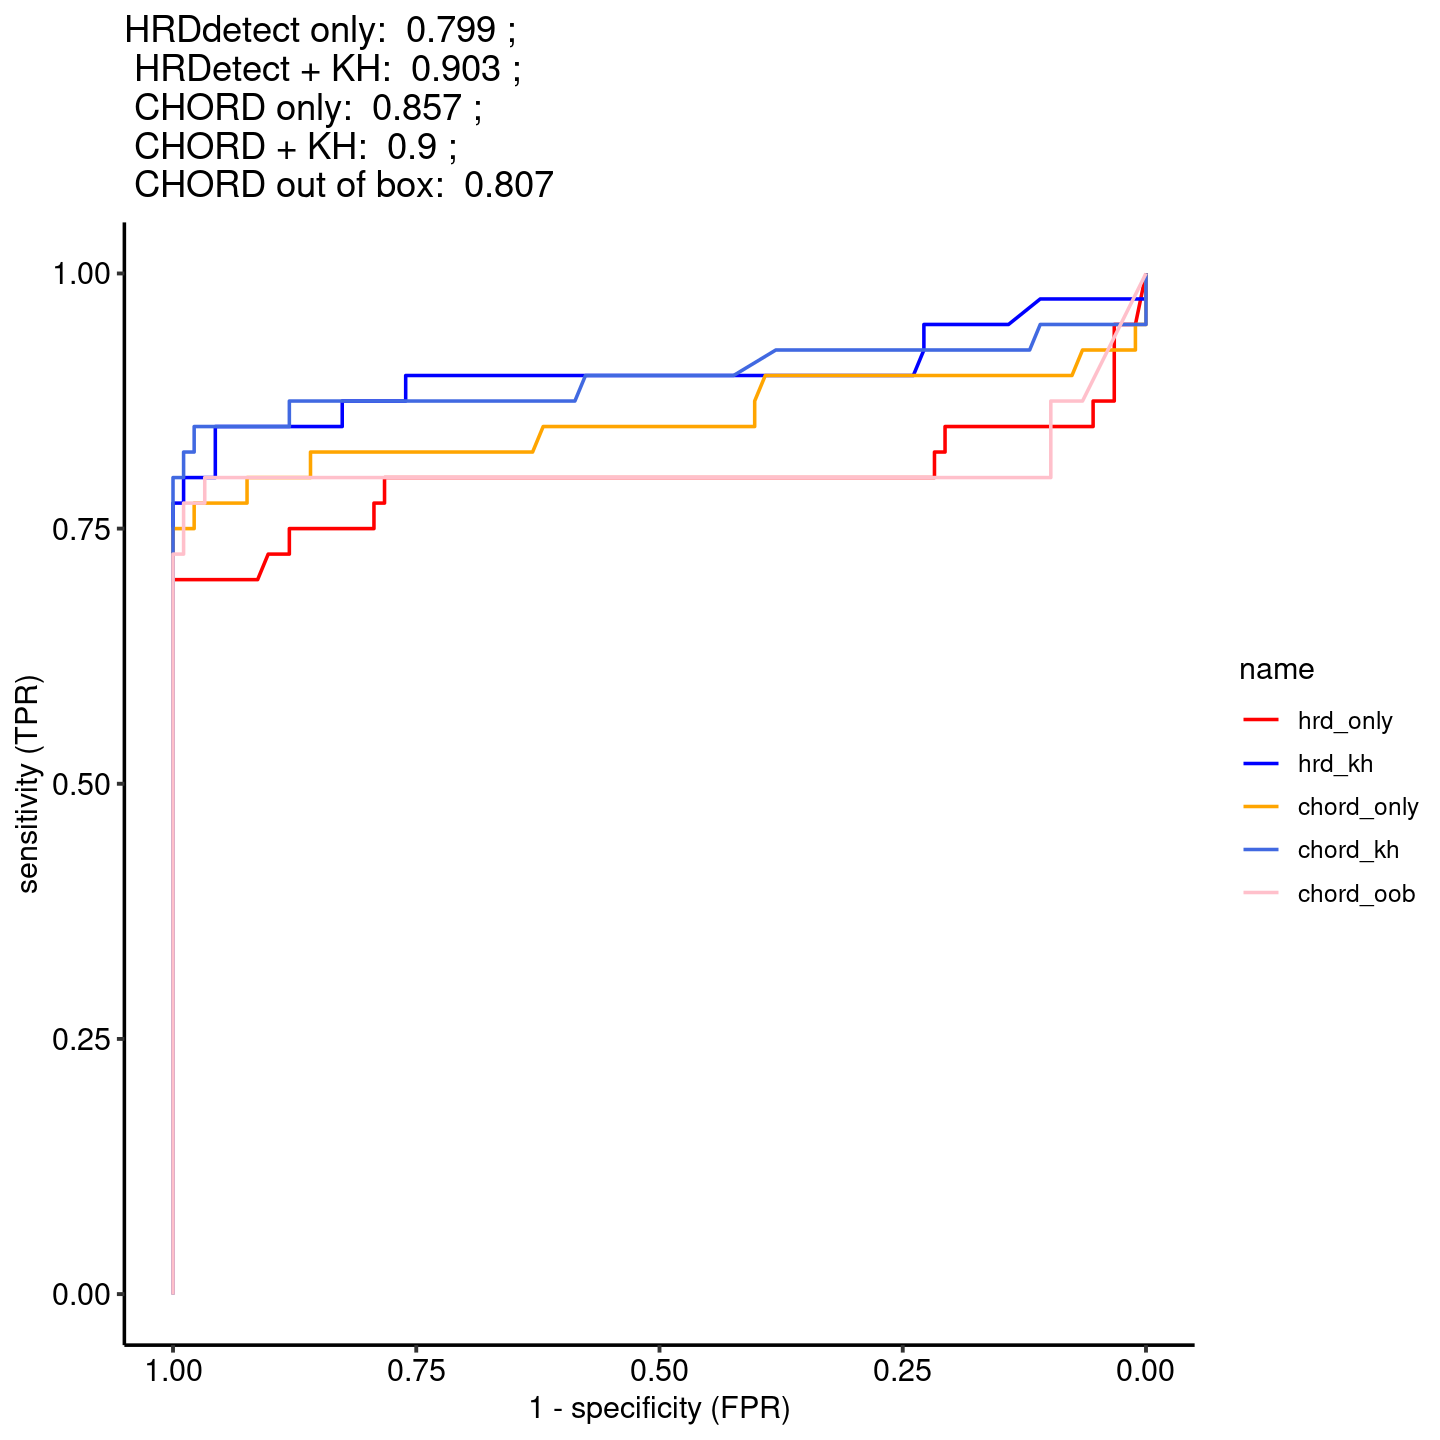

In [38]:
options(repr.plot.width = 8, repr.plot.height = 8, repr.plot.res = 180)
print(pt)

In [39]:
## skitools::ppdf(print(pt), height = 5, width = 5)

## PR curve

In [40]:
pt.dt = rbind(hrd.only.pr[, name := "hrd_only"],
              hrd.kh.pr[, name := "hrd_kh"],
              chord.only.pr[, name := "chord_only"],
              chord.kh.pr[, name := "chord_kh"],
              chord.oob.pr[, name := "chord_oob"])

roc.colormap = c(hrd_only = "red", hrd_kh = "blue", chord_only = "orange", chord_kh = "royalblue", chord_oob = "pink")

pt = ggplot(pt.dt, aes(x = recall, y = precision, color = name)) +
geom_line() +
scale_color_manual(values = roc.colormap) + 
labs(title = paste("HRDetect only: ", hrd.only.auc$.estimate, "\n",
                   "HRDetect + KH: ", hrd.kh.auc$.estimate, "\n",
                   "CHORD only: ", chord.only.auc$.estimate, "\n",
                   "CHORD + KH: ", chord.kh.auc$.estimate, "\n",
                   "CHORD OOB: ", chord.oob.auc$.estimate),
    x = "recall",
    y = "precision") +
ggpubr::theme_pubr() +
theme(legend.position = "right")


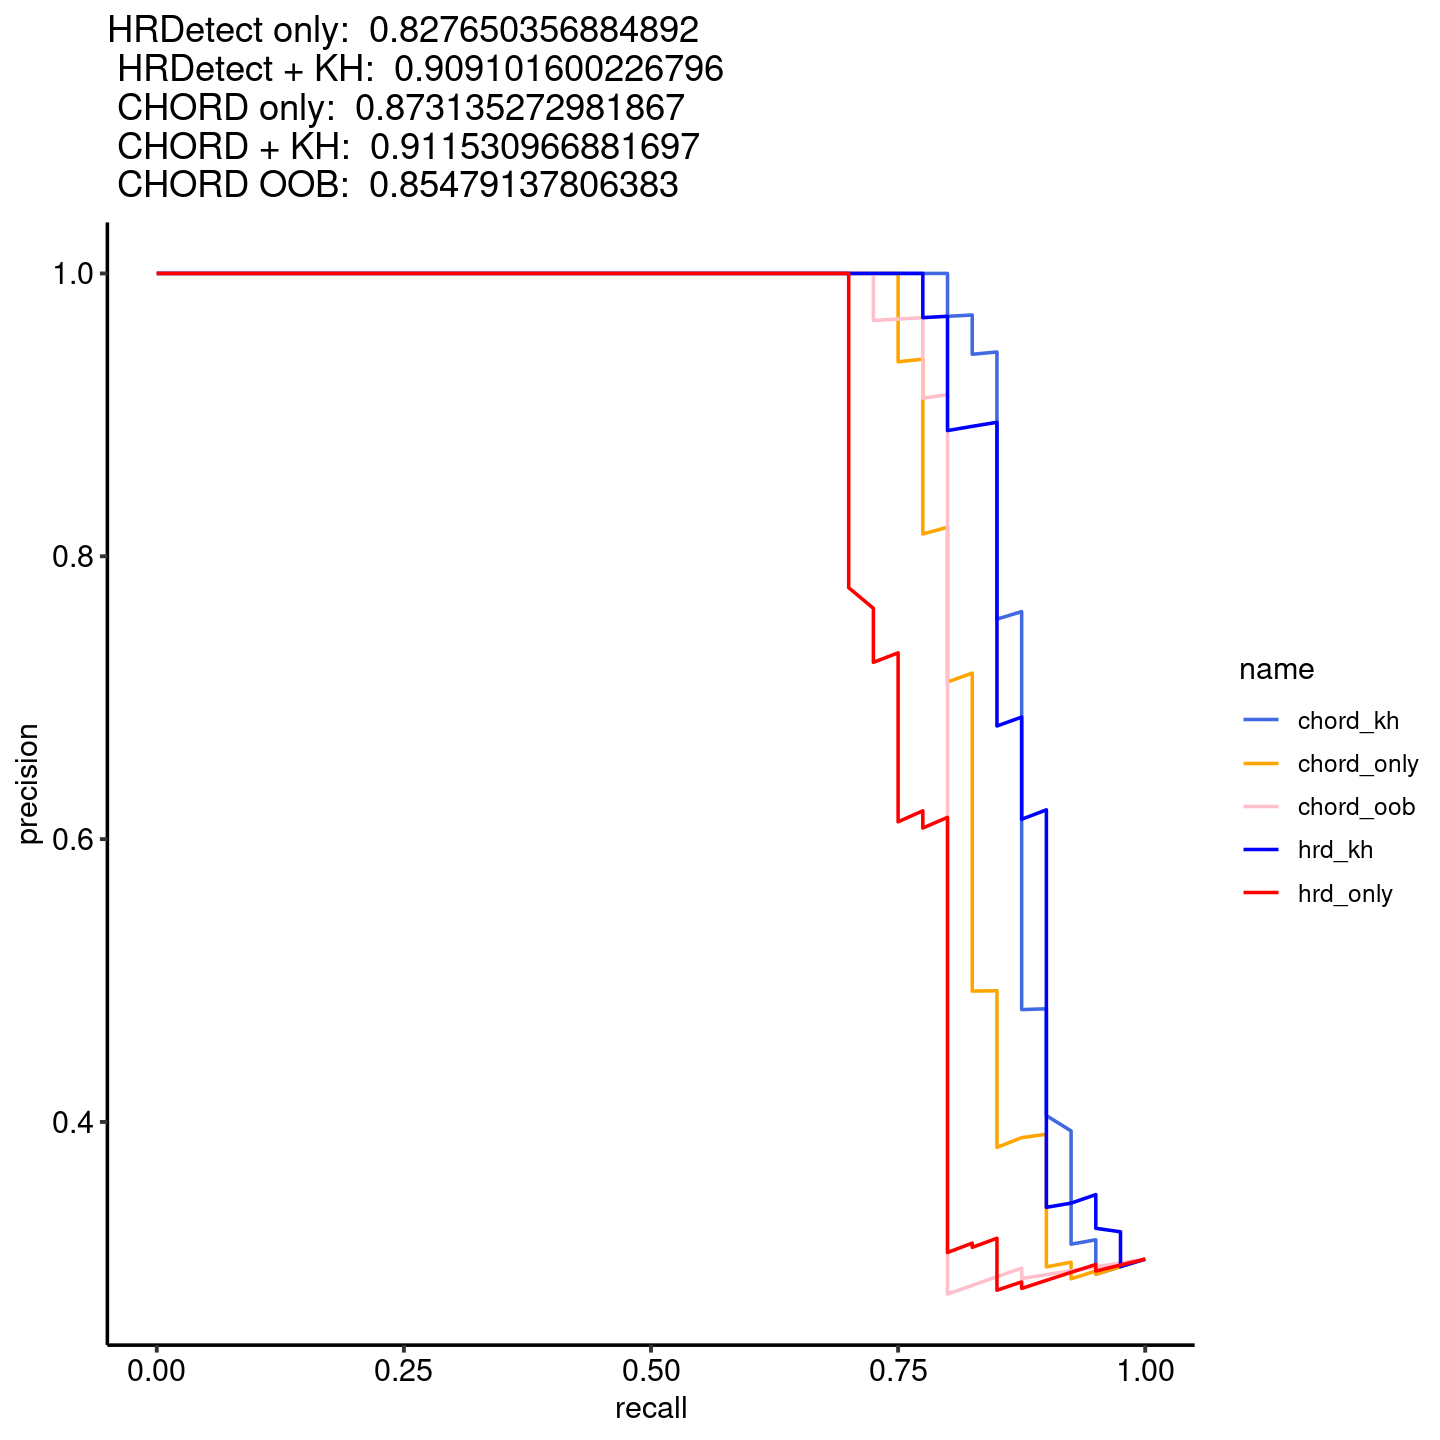

In [41]:
options(repr.plot.width = 8, repr.plot.height = 8, repr.plot.res = 180)
print(pt)

In [42]:
## skitools::ppdf(print(pt), height = 5, width = 5)

# EDF8a
ROC and precision-recall curves comparing B1+2 and HRDetect performance on detecting HR-deficiency (BRCA1d or BRCA2d)  in an independent (HMF) test cohort. P value denotes comparison of AUROC via DeLong test.

In [156]:
pROC::roc.test(hrd.only.unsmoothed_general, hrd.kh.unsmoothed_general)


	DeLong's test for two correlated ROC curves

data:  hrd.only.unsmoothed_general and hrd.kh.unsmoothed_general
Z = -1.4801, p-value = 0.1389
alternative hypothesis: true difference in AUC is not equal to 0
95 percent confidence interval:
 -0.022685310  0.003164751
sample estimates:
AUC of roc1 AUC of roc2 
  0.9611485   0.9709088 


In [157]:
pROC::roc.test(chord.oob.unsmoothed_general, chord.kh.unsmoothed_general)


	DeLong's test for two correlated ROC curves

data:  chord.oob.unsmoothed_general and chord.kh.unsmoothed_general
Z = -1.9489, p-value = 0.05131
alternative hypothesis: true difference in AUC is not equal to 0
95 percent confidence interval:
 -3.467992e-02  9.852003e-05
sample estimates:
AUC of roc1 AUC of roc2 
  0.9562786   0.9735693 


In [45]:
library(ggplot2)

pt = pROC::ggroc(list(hrd_only = hrd.only.unsmoothed_general,
                      hrd_kh = hrd.kh.unsmoothed_general,
                      chord_only = chord.only.unsmoothed_general,
                      chord_kh = chord.kh.unsmoothed_general,
                      chord_oob = chord.oob.unsmoothed_general)) +
    scale_color_manual(values = c(hrd_only = "red",
                                  hrd_kh = "blue",
                                  chord_only = "orange",
                                  chord_kh = "royalblue",
                                  chord_oob = "pink")) +
    labs(title = paste("HRDdetect only: ", round(hrd.only.smoothed_general$auc, 3),"\n",
                       "HRDetect + KH: ", round(hrd.kh.smoothed_general$auc, 3),"\n",
                       "CHORD only: ", round(chord.only.smoothed_general$auc, 3),"\n",
                       "CHORD + KH: ", round(chord.kh.smoothed_general$auc, 3),"\n",
                       "CHORD out of box: ", round(chord.oob.unsmoothed_general$auc, 3)),
         y = "sensitivity (TPR)", 
         x = "1 - specificity (FPR)") +
    ggpubr::theme_pubr() +
    theme(legend.position = "right")

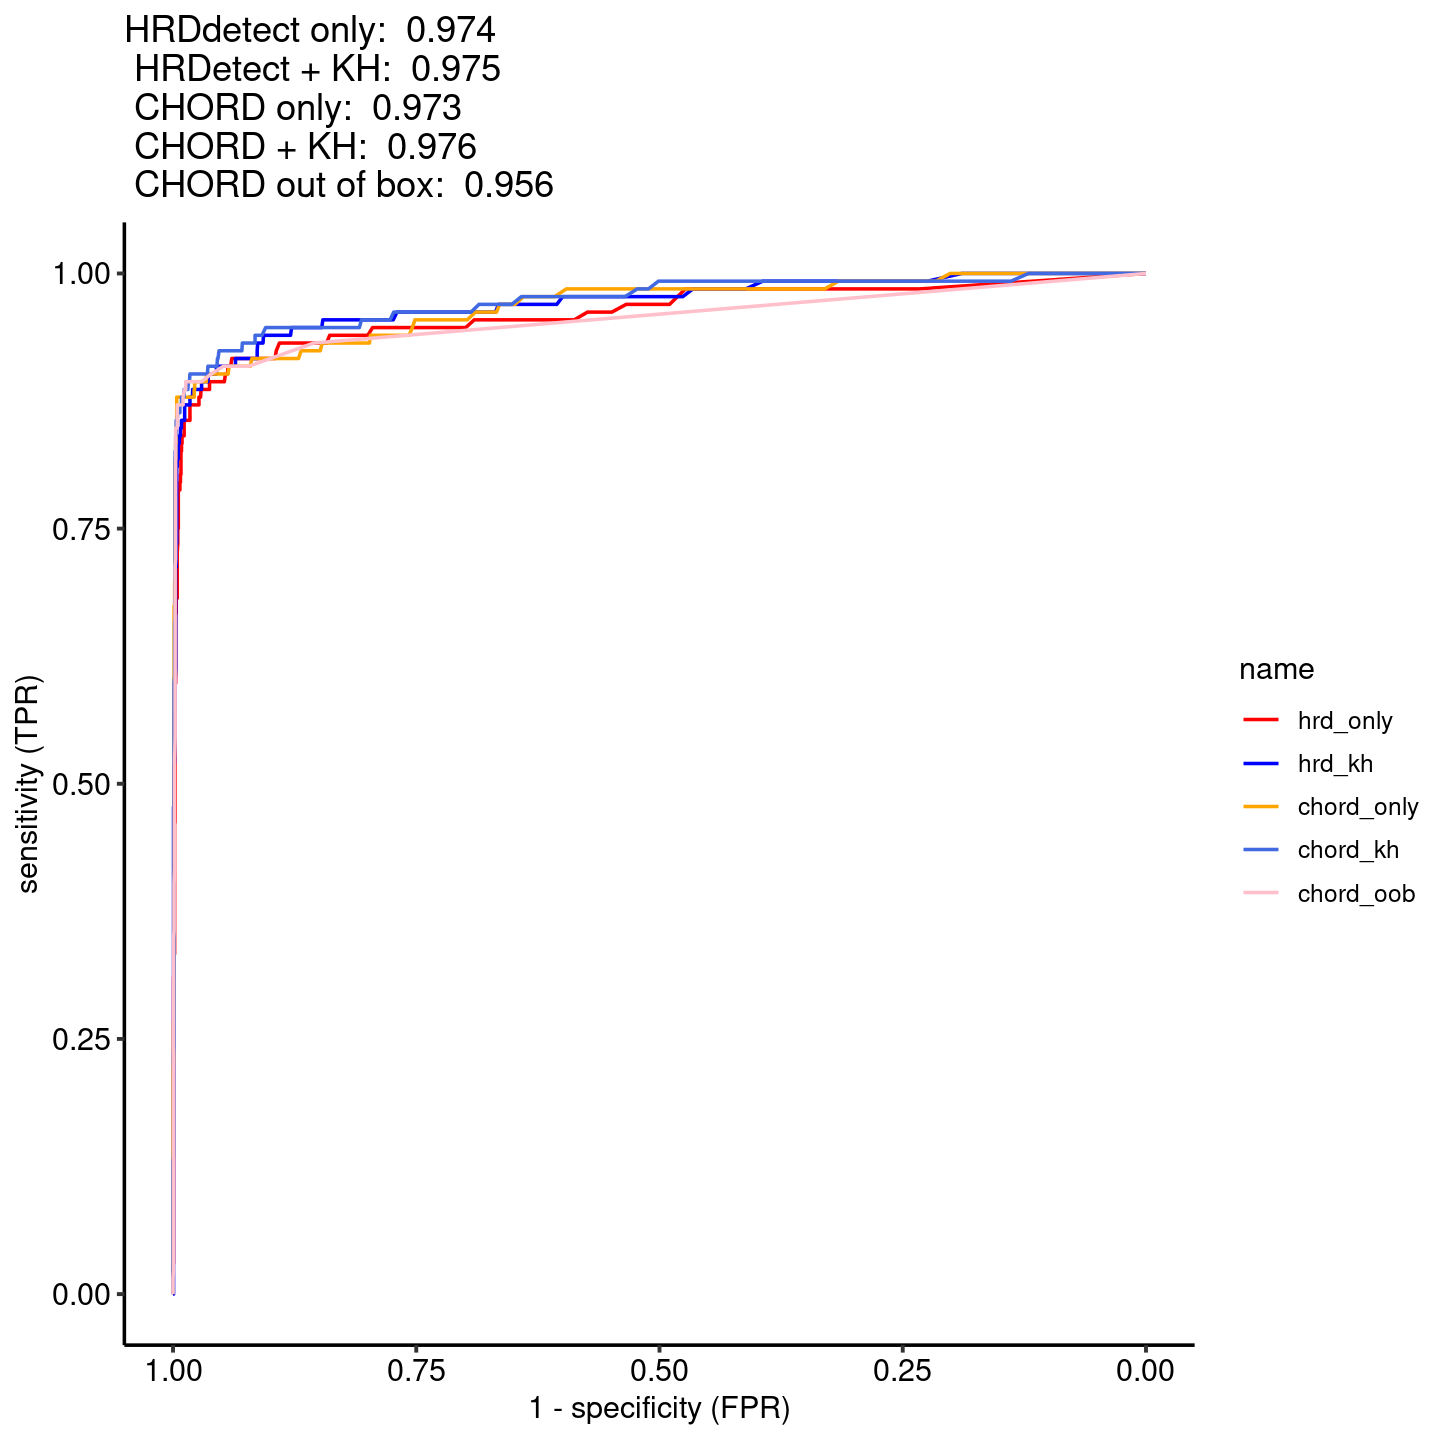

In [46]:
options(repr.plot.width = 8, repr.plot.height = 8, repr.plot.res = 180)
print(pt)

In [47]:
## skitools::ppdf(print(pt), height = 5, width = 5)

In [48]:
pt.dt = rbind(hrd.only.pr_general[, name := "hrd_only"],
              hrd.kh.pr_general[, name := "hrd_kh"],
              chord.only.pr_general[, name := "chord_only"],
              chord.kh.pr_general[, name := "chord_kh"],
              chord.oob.pr_general[, name := "chord_oob"])

roc.colormap = c(hrd_only = "red", hrd_kh = "blue", chord_only = "orange", chord_kh = "royalblue", chord_oob = "pink")

pt = ggplot(pt.dt, aes(x = recall, y = precision, color = name)) +
geom_line() +
scale_color_manual(values = roc.colormap) + 
labs(title = paste("HRDetect only: ", hrd.only.auc_general$.estimate, "\n",
                   "HRDetect + KH: ", hrd.kh.auc_general$.estimate, "\n",
                   "CHORD only: ", chord.only.auc_general$.estimate, "\n",
                   "CHORD + KH: ", chord.kh.auc_general$.estimate, "\n",
                   "CHORD OOB: ", chord.oob.auc_general$.estimate),
    x = "recall",
    y = "precision") +
ggpubr::theme_pubr() +
theme(legend.position = "right")


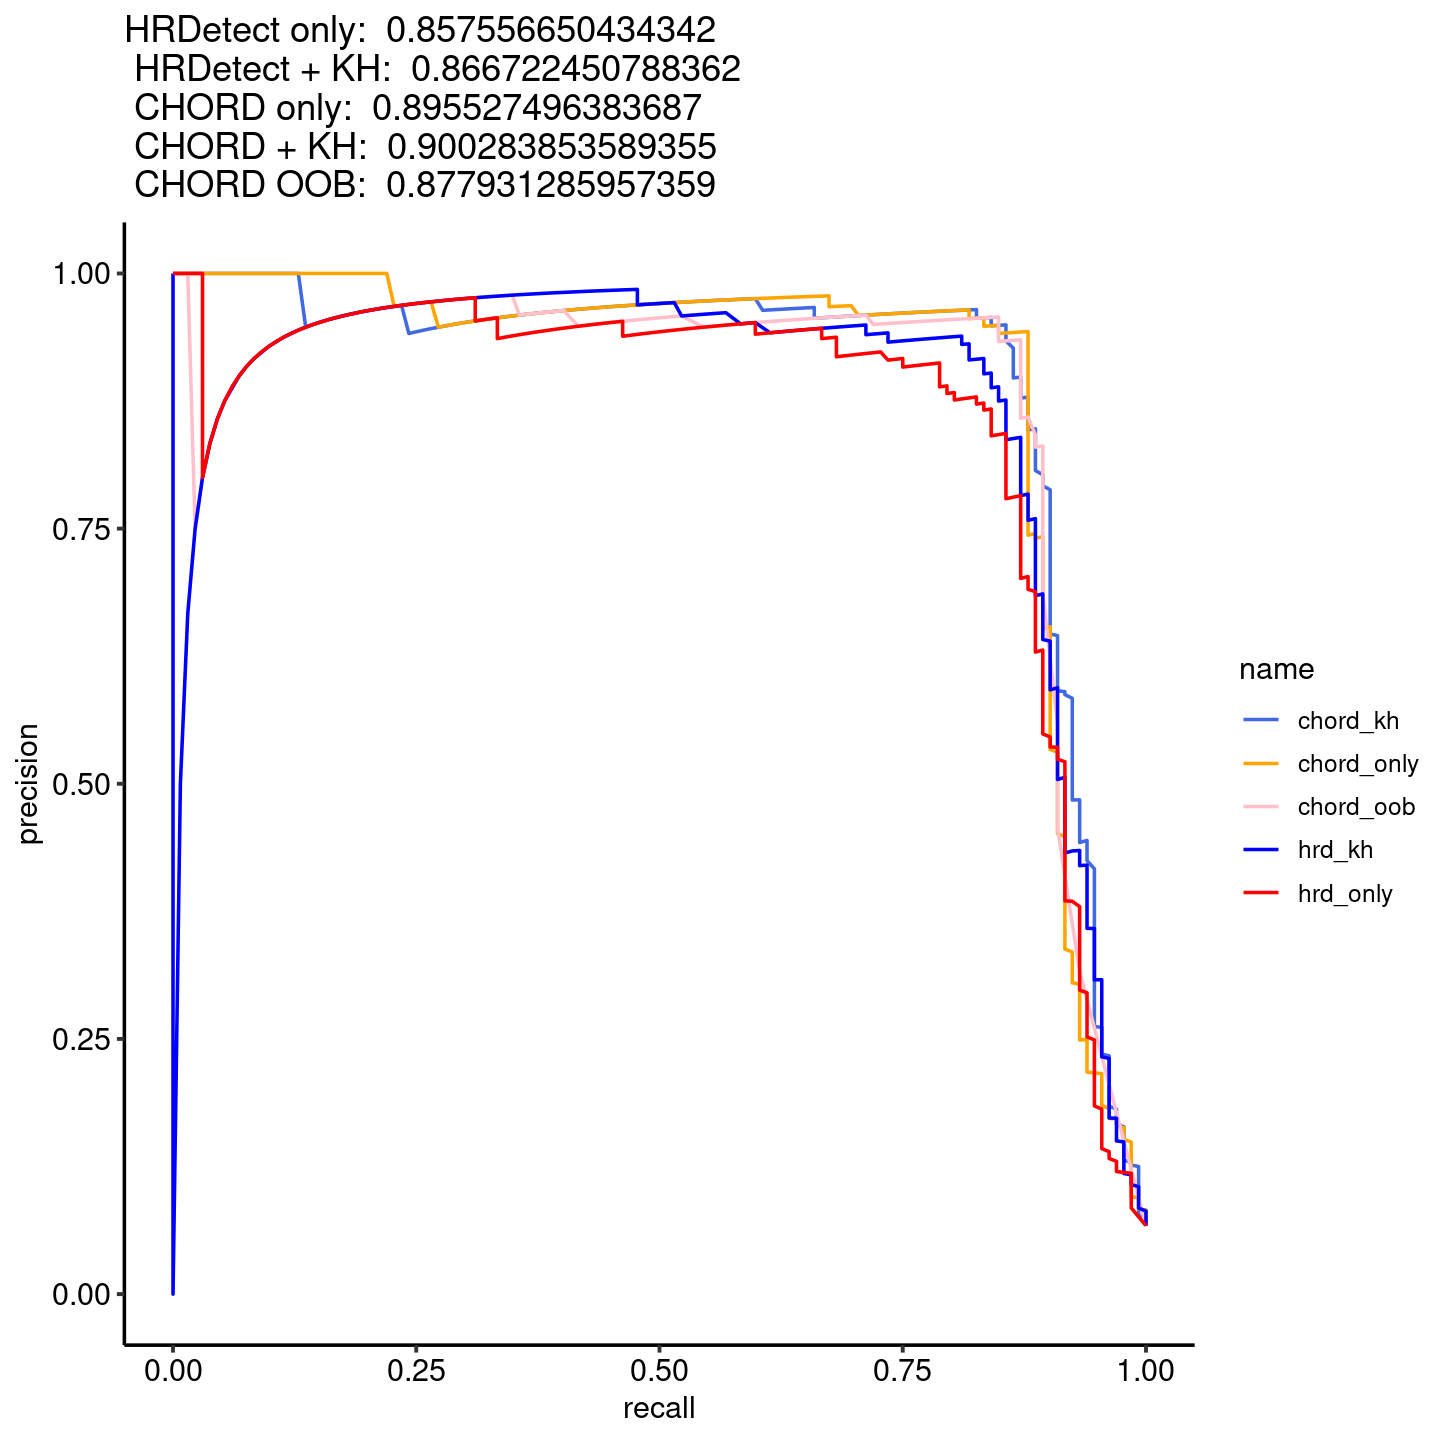

In [49]:
options(repr.plot.width = 8, repr.plot.height = 8, repr.plot.res = 180)
print(pt)

In [50]:
## skitools::ppdf(print(pt), height = 5, width = 5)

## EDF5a (SV features only)
Receiver operating characteristic curves (ROC) and precision recall curves (PRC) comparing **SV features** highlighted in this study with those used in HRDetect for accurately classifying HR-deficiency (either BRCA1d or BRCA2d). P values denote comparison of AUROC via DeLong test.

In [271]:
pROC::roc.test(hrd.only.unsmoothed_svonly, hrd.kh.unsmoothed_svonly)


	DeLong's test for two correlated ROC curves

data:  hrd.only.unsmoothed_svonly and hrd.kh.unsmoothed_svonly
Z = -8.2351, p-value < 2.2e-16
alternative hypothesis: true difference in AUC is not equal to 0
95 percent confidence interval:
 -0.2358118 -0.1451436
sample estimates:
AUC of roc1 AUC of roc2 
  0.7300906   0.9205683 


In [272]:
pROC::roc.test(chord.only.unsmoothed_svonly, chord.kh.unsmoothed_svonly)


	DeLong's test for two correlated ROC curves

data:  chord.only.unsmoothed_svonly and chord.kh.unsmoothed_svonly
Z = -3.4015, p-value = 0.0006702
alternative hypothesis: true difference in AUC is not equal to 0
95 percent confidence interval:
 -0.03926047 -0.01055587
sample estimates:
AUC of roc1 AUC of roc2 
  0.9208291   0.9457372 


In [51]:
library(ggplot2)

pt = pROC::ggroc(list(hrd_only = hrd.only.unsmoothed_svonly,
                      hrd_kh = hrd.kh.unsmoothed_svonly,
                      chord_only = chord.only.unsmoothed_svonly,
                      chord_kh = chord.kh.unsmoothed_svonly))+
    scale_color_manual(values = c(hrd_only = "red",
                                  hrd_kh = "blue",
                                  chord_only = "orange",
                                  chord_kh = "royalblue")) +
    labs(title = paste("HRDdetect only: ", round(hrd.only.smoothed_svonly$auc, 3),"\n",
                       "HRDetect + KH: ", round(hrd.kh.smoothed_svonly$auc, 3),"\n",
                       "CHORD only: ", round(chord.only.smoothed_svonly$auc, 3),"\n",
                       "CHORD + KH: ", round(chord.kh.smoothed_svonly$auc, 3),"\n"),
         y = "sensitivity (TPR)", 
         x = "1 - specificity (FPR)") +
    ggpubr::theme_pubr() +
    theme(legend.position = "right")

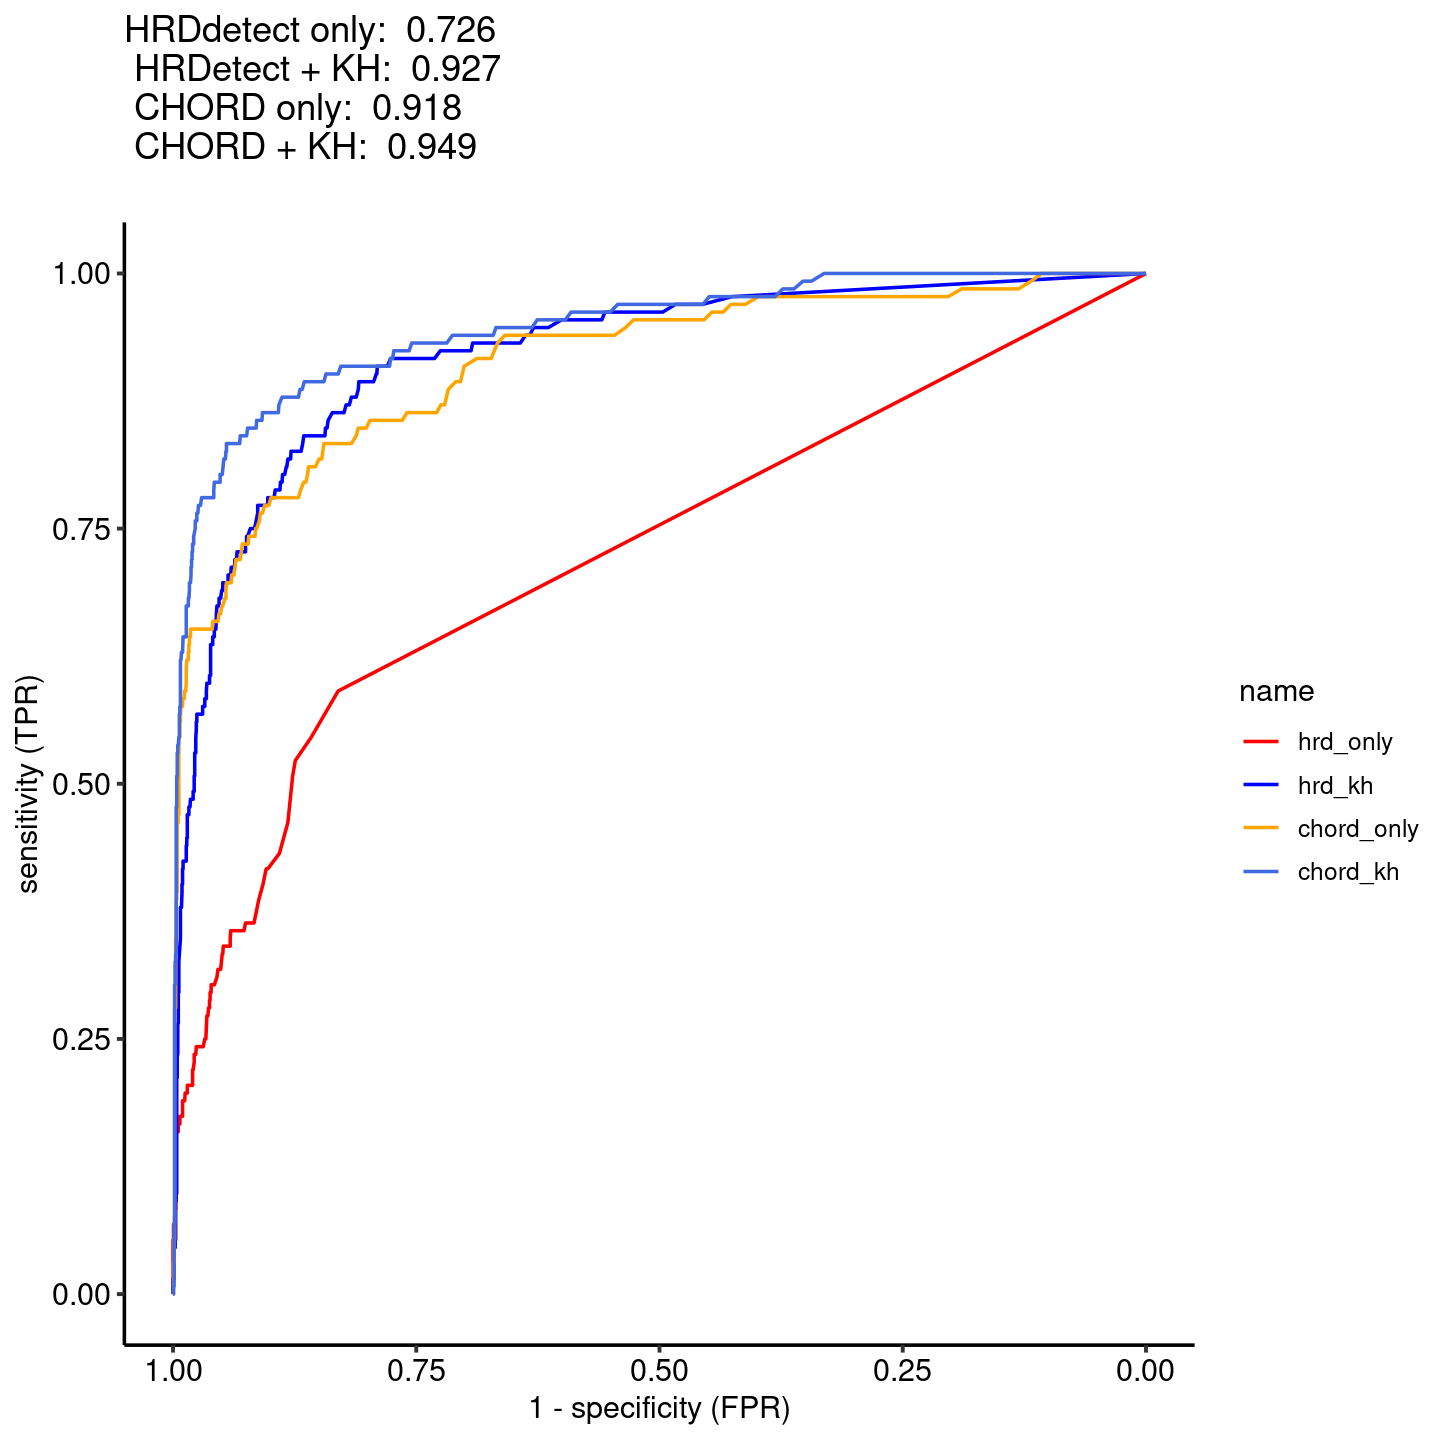

In [52]:
options(repr.plot.width = 8, repr.plot.height = 8, repr.plot.res = 180)
print(pt)

In [53]:
## skitools::ppdf(print(pt), height = 5, width = 5)

In [54]:
pt.dt = rbind(hrd.only.pr_svonly[, name := "hrd_only"],
              hrd.kh.pr_svonly[, name := "hrd_kh"],
              chord.only.pr_svonly[, name := "chord_only"],
              chord.kh.pr_svonly[, name := "chord_kh"])

roc.colormap = c(hrd_only = "red", hrd_kh = "blue", chord_only = "orange", chord_kh = "royalblue", chord_oob = "pink")

pt = ggplot(pt.dt, aes(x = recall, y = precision, color = name)) +
geom_line() +
scale_color_manual(values = roc.colormap) + 
labs(title = paste("HRDetect only: ", hrd.only.auc_svonly$.estimate, "\n",
                   "HRDetect + KH: ", hrd.kh.auc_svonly$.estimate, "\n",
                   "CHORD only: ", chord.only.auc_svonly$.estimate, "\n",
                   "CHORD + KH: ", chord.kh.auc_svonly$.estimate, "\n"),
    x = "recall",
    y = "precision") +
ggpubr::theme_pubr() +
theme(legend.position = "right")

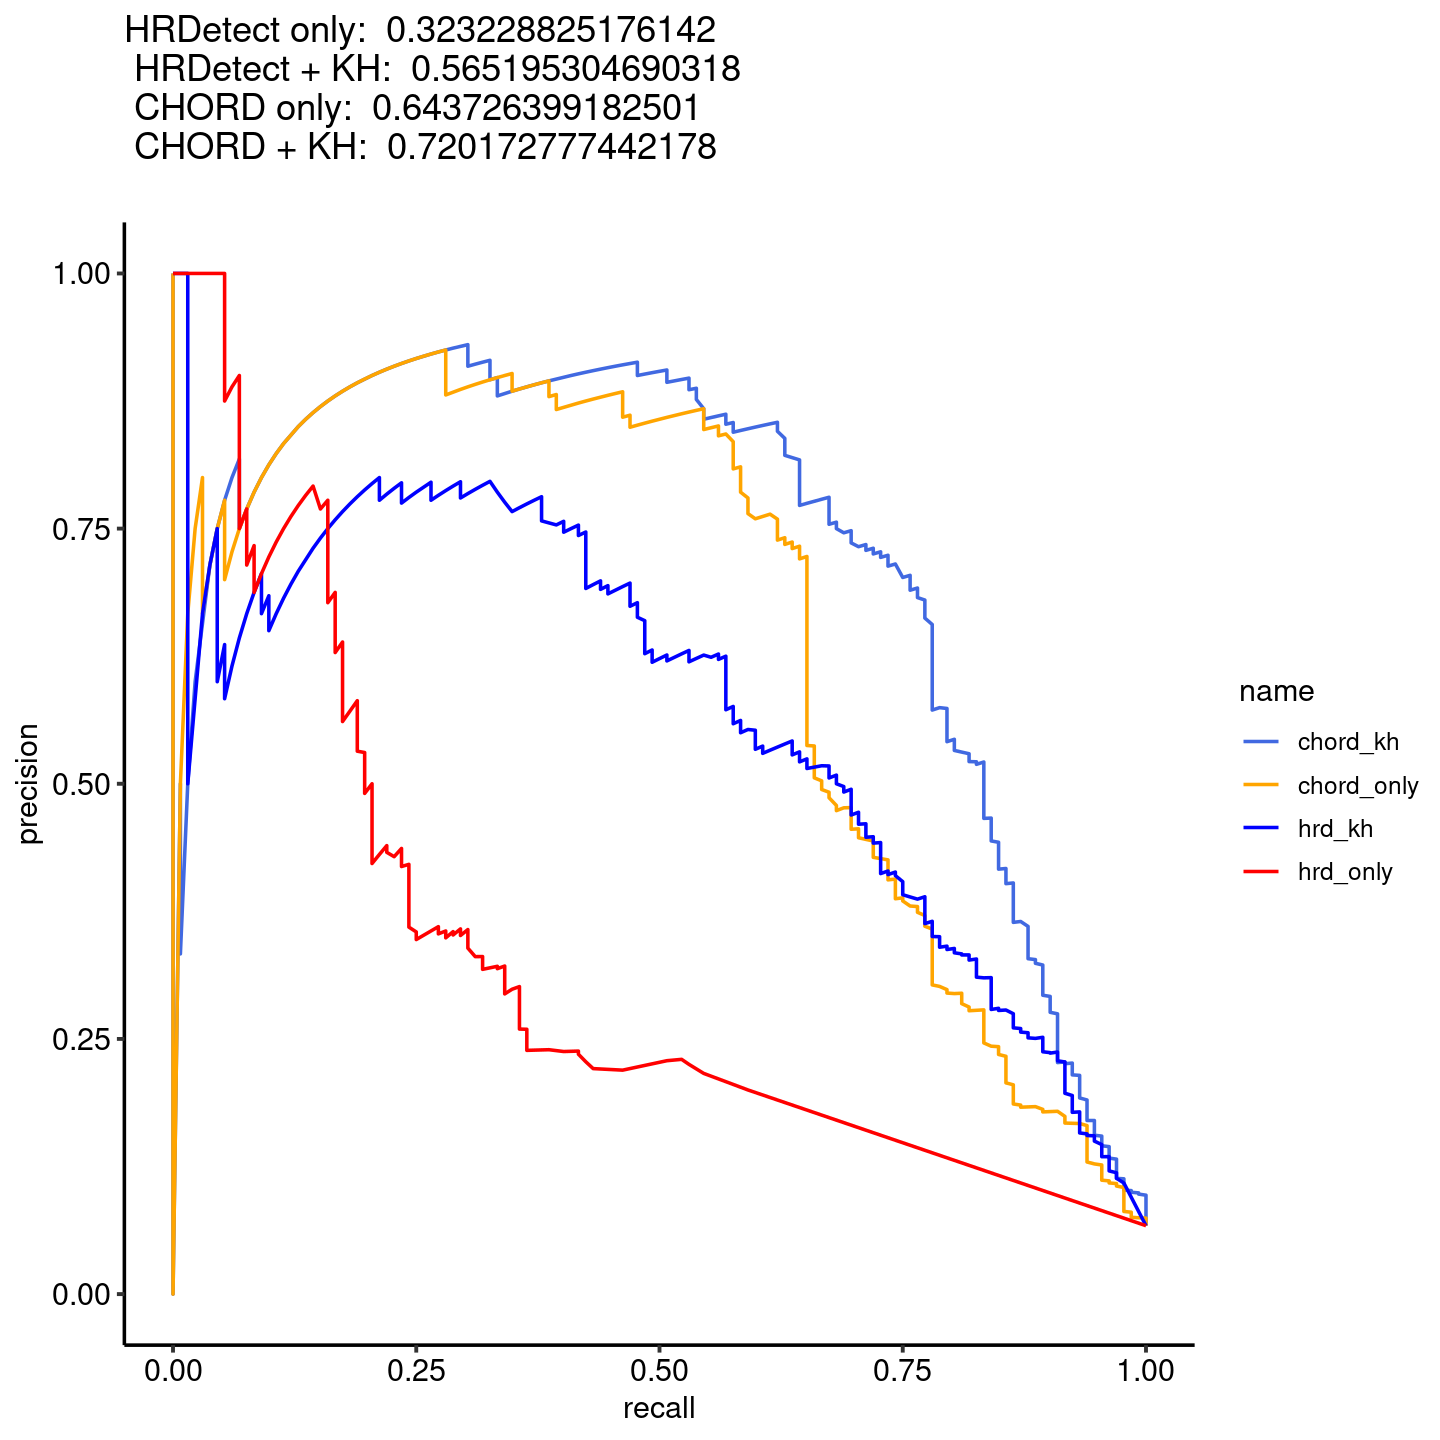

In [55]:
options(repr.plot.width = 8, repr.plot.height = 8, repr.plot.res = 180)
print(pt)

In [56]:
## skitools::ppdf(print(pt), height = 5, width = 5)

## Feature importance score testing

In [92]:
## all features
flist.chord = c(stats::setNames(nm = features_chord),
                stats::setNames(nm = features_kh),
                "SV_KH" = list(features_kh))

flist.hrd = c(stats::setNames(nm = features_hrdetect),
                stats::setNames(nm = features_kh),
                "SV_KH" = list(features_kh))

## SV only features
flist.chord_svonly = c(stats::setNames(nm = svonly_chord),
                stats::setNames(nm = svonly_kh),
                "SV_KH" = list(svonly_kh))

flist.hrd_svonly = c(stats::setNames(nm = svonly_hrdetect),
                stats::setNames(nm = svonly_kh),
                "SV_KH" = list(svonly_kh))


## Models for BRCA1 vs BRCA2 discrimination

In [93]:
## this cell can take a hot sec to run since you're training the classifier x 30 time the number of features to permute...
chord_permute_res = suppressMessages(permute_boot(data = chord.kh.test.x, 
                               flist = flist.chord, 
                               y = test.y,
                               model = chord.kh, 
                               times = 30, 
                               predictFUN = predictRF))

In [94]:
## same with this one
chord_permute_res_nonbopp = suppressMessages(permute_boot(data = chord.kh.nonbopp.x, 
                               flist = flist.chord, 
                               y = nonbopp.test.y, 
                               model = chord.kh, 
                               times = 30, 
                               predictFUN = predictRF))

In [95]:
hrd_permute_res = suppressMessages(permute_boot(data = hrd.kh.test.x, 
                               flist = flist.hrd, 
                               y = test.y, 
                               model = hrd.kh, 
                               times = 30, 
                               predictFUN = predictRF))

In [96]:
## same with this one
hrd_permute_res_nonbopp = suppressMessages(permute_boot(data = hrd.kh.nonbopp.x, 
                               flist = flist.hrd, 
                               y = nonbopp.test.y, 
                               model = hrd.kh, 
                               times = 30, 
                               predictFUN = predictRF))

## Models for HRD prediction in general

In [97]:
## this cell can take a hot sec to run since you're training the classifier x 30 time the number of features to permute...
chord_permute_res_general = suppressMessages(permute_boot(data = chord.kh.test.x_general, 
                               flist = flist.chord, 
                               y = test.y_general, 
                               model = chord.kh_general, 
                               times = 30, 
                               predictFUN = predictRF))

In [98]:
## same with this one
chord_permute_res_nonbopp_general = suppressMessages(permute_boot(data = chord.kh.nonbopp.x_general, 
                               flist = flist.chord, 
                               y = nonbopp.test.y_general, 
                               model = chord.kh_general, 
                               times = 30, 
                               predictFUN = predictRF))

In [99]:
hrd_permute_res_general = suppressMessages(permute_boot(data = hrd.kh.test.x_general, 
                               flist = flist.hrd, 
                               y = test.y_general, 
                               model = hrd.kh_general, 
                               times = 30, 
                               predictFUN = predictRF))

In [100]:
## same with this one
hrd_permute_res_nonbopp_general = suppressMessages(permute_boot(data = hrd.kh.nonbopp.x_general, 
                               flist = flist.hrd, 
                               y = nonbopp.test.y_general, 
                               model = hrd.kh_general, 
                               times = 30, 
                               predictFUN = predictRF))

## Models for HRD prediction with SV only features
Warning: the next four cells take kind of a long time to run (large training set, many features...)

In [101]:
## this cell can take a hot sec to run since you're training the classifier x 30 time the number of features to permute...
chord_permute_res_svonly = suppressMessages(permute_boot(data = chord.kh.test.x_svonly, 
                               flist = flist.chord_svonly, 
                               y = test.y_svonly, 
                               model = chord.kh_svonly, 
                               times = 30, 
                               predictFUN = predictRF))

In [102]:
## same with this one
chord_permute_res_nonbopp_svonly = suppressMessages(permute_boot(data = chord.kh.nonbopp.x_svonly, 
                               flist = flist.chord_svonly, 
                               y = nonbopp.test.y_svonly, 
                               model = chord.kh_svonly, 
                               times = 30, 
                               predictFUN = predictRF))

In [103]:
hrd_permute_res_svonly = suppressMessages(permute_boot(data = hrd.kh.test.x_svonly, 
                               flist = flist.hrd_svonly, 
                               y = test.y_svonly, 
                               model = hrd.kh_svonly, 
                               times = 30, 
                               predictFUN = predictRF))

In [104]:
## same with this one
hrd_permute_res_nonbopp_svonly = suppressMessages(permute_boot(data = hrd.kh.nonbopp.x_svonly, 
                               flist = flist.hrd_svonly, 
                               y = nonbopp.test.y_svonly, 
                               model = hrd.kh_svonly, 
                               times = 30, 
                               predictFUN = predictRF))

In [106]:
## kevin pmax with zero
chord.auroc.dt = chord_permute_res[, .(mean.dec.auroc = pmax(mean(decrease.performance), 0),
                                        std.dec.auroc = sqrt(var(decrease.performance))),
                                    by = permuted_set]

chord.nonbopp.auroc.dt = chord_permute_res_nonbopp[, .(mean.dec.auroc = pmax(mean(decrease.performance), 0),
                                        std.dec.auroc = sqrt(var(decrease.performance))),
                                    by = permuted_set]

hrd.auroc.dt = hrd_permute_res[, .(mean.dec.auroc = pmax(mean(decrease.performance), 0),
                                        std.dec.auroc = sqrt(var(decrease.performance))),
                                    by = permuted_set]

hrd.nonbopp.auroc.dt = hrd_permute_res_nonbopp[, .(mean.dec.auroc = pmax(mean(decrease.performance), 0),
                                        std.dec.auroc = sqrt(var(decrease.performance))),
                                    by = permuted_set]

In [107]:
## kevin pmax with zero
chord.auroc.dt_general = chord_permute_res_general[, .(mean.dec.auroc = pmax(mean(decrease.performance), 0),
                                        std.dec.auroc = sqrt(var(decrease.performance))),
                                    by = permuted_set]

chord.nonbopp.auroc.dt_general = chord_permute_res_nonbopp_general[, .(mean.dec.auroc = pmax(mean(decrease.performance), 0),
                                        std.dec.auroc = sqrt(var(decrease.performance))),
                                    by = permuted_set]

hrd.auroc.dt_general = hrd_permute_res_general[, .(mean.dec.auroc = pmax(mean(decrease.performance), 0),
                                        std.dec.auroc = sqrt(var(decrease.performance))),
                                    by = permuted_set]

hrd.nonbopp.auroc.dt_general = hrd_permute_res_nonbopp_general[, .(mean.dec.auroc = pmax(mean(decrease.performance), 0),
                                        std.dec.auroc = sqrt(var(decrease.performance))),
                                    by = permuted_set]

In [108]:
## kevin pmax with zero
chord.auroc.dt_svonly = chord_permute_res_svonly[, .(mean.dec.auroc = pmax(mean(decrease.performance), 0),
                                        std.dec.auroc = sqrt(var(decrease.performance))),
                                    by = permuted_set]

chord.nonbopp.auroc.dt_svonly = chord_permute_res_nonbopp_svonly[, .(mean.dec.auroc = pmax(mean(decrease.performance), 0),
                                        std.dec.auroc = sqrt(var(decrease.performance))),
                                    by = permuted_set]

hrd.auroc.dt_svonly = hrd_permute_res_svonly[, .(mean.dec.auroc = pmax(mean(decrease.performance), 0),
                                        std.dec.auroc = sqrt(var(decrease.performance))),
                                    by = permuted_set]

hrd.nonbopp.auroc.dt_svonly = hrd_permute_res_nonbopp_svonly[, .(mean.dec.auroc = pmax(mean(decrease.performance), 0),
                                        std.dec.auroc = sqrt(var(decrease.performance))),
                                    by = permuted_set]

In [109]:
## head(chord.auroc.dt[(order(mean.dec.auroc, decreasing = TRUE))])

In [110]:
##colormap = c("RS3" = "gray", "RS5" = "gray", "tib" = "red", "qrdel" = "red", 
##"qrdup" = "red", "ihdel" = "red", "DUP_1kb_100kb" = "gray", "SV_NZ" = "gray", "SV_KH" = "red", "del.mh.prop" = "gray")
colormap = c(setNames(rep("gray", length(features_chord)), features_chord),
             setNames(rep("red", length(features_kh)), features_kh),
             "SV_KH" = "red")

# Figure 5b
HRDetect feature importance for HMF pan-cancer tumors, using SV features only

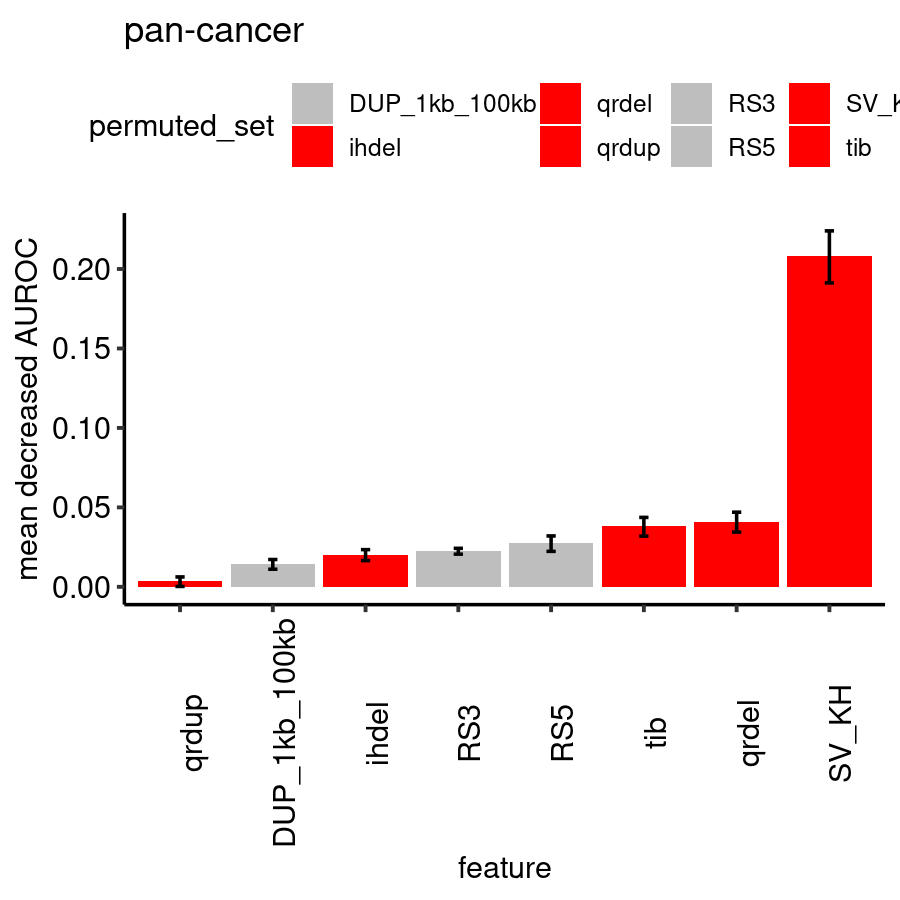

In [124]:
colormap = c("RS3" = "gray", "RS5" = "gray", "tib" = "red", "qrdel" = "red", "qrdup" = "red", "ihdel" = "red", "DUP_1kb_100kb" = "gray", 
             "SV_NZ" = "gray",
             "SV_KH" = "red")

## relevel
hrd.auroc.dt_svonly[, permuted_set_level := ordered(permuted_set, levels = c(hrd.auroc.dt_svonly[order(mean.dec.auroc), permuted_set]))]

hmf.auroc.pt = ggplot(hrd.auroc.dt_svonly[permuted_set_level %in% names(colormap)], 
                      aes(x = permuted_set_level, y = mean.dec.auroc, fill = permuted_set)) +
    geom_bar(stat = "identity") +
    geom_errorbar(aes(ymin = mean.dec.auroc - std.dec.auroc, ymax = mean.dec.auroc + std.dec.auroc), width = 0.1) +
    scale_fill_manual(values = colormap) +
    ggpubr::theme_pubr() +
    labs(x = "feature", y = "mean decreased AUROC", title = "pan-cancer") +
    theme(axis.text.x = element_text(angle = 90))

options(repr.plot.width = 5, repr.plot.height = 5, repr.plot.res = 180)
print(hmf.auroc.pt)

# Figure 5c
HRDetect feature importance for HMF non-BOPP tumors, using SV features only

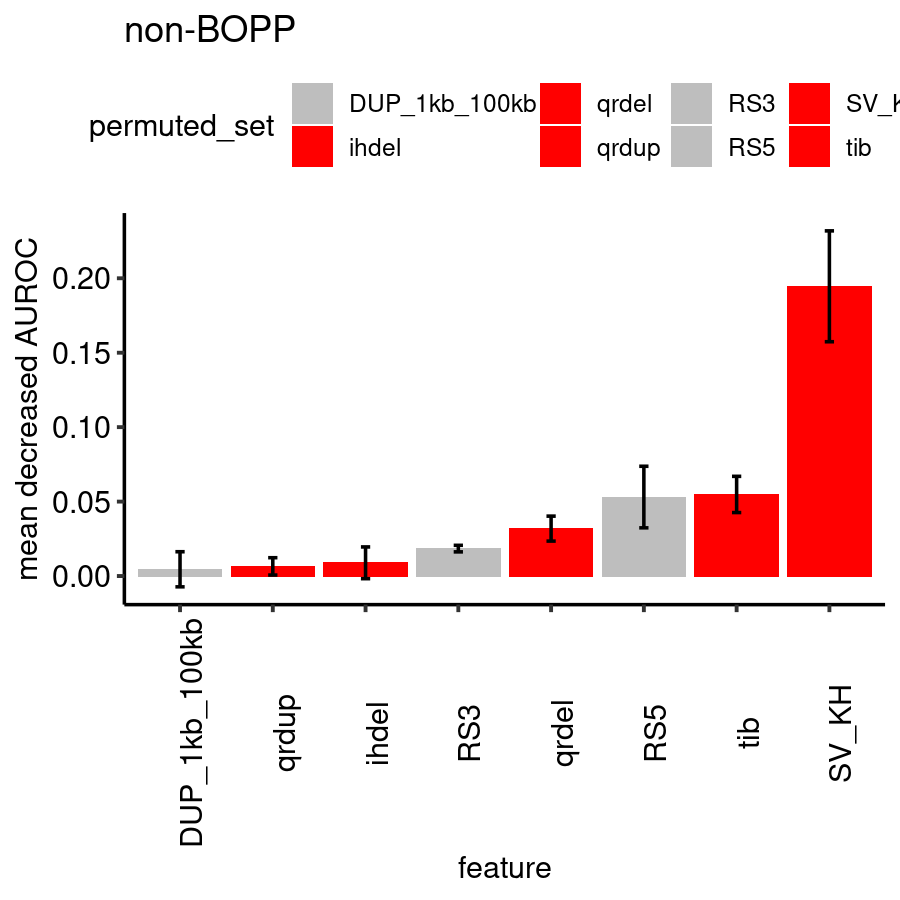

In [125]:
## relevel
hrd.nonbopp.auroc.dt_svonly[, permuted_set_level := ordered(permuted_set, levels = c(hrd.nonbopp.auroc.dt_svonly[order(mean.dec.auroc), permuted_set]))]

hmf.nonbopp.auroc.pt = ggplot(hrd.nonbopp.auroc.dt_svonly, aes(x = permuted_set_level, y = mean.dec.auroc, fill = permuted_set)) +
    geom_bar(stat = "identity") +
    geom_errorbar(aes(ymin = mean.dec.auroc - std.dec.auroc, ymax = mean.dec.auroc + std.dec.auroc), width = 0.1) +
    scale_fill_manual(values = colormap) +
    ggpubr::theme_pubr() +
    labs(x = "feature", y = "mean decreased AUROC", title = "non-BOPP") +
    theme(axis.text.x = element_text(angle = 90))

options(repr.plot.width = 5, repr.plot.height = 5, repr.plot.res = 180)
print(hmf.nonbopp.auroc.pt)

# Figure 5e
Feature importance scores BRCA1d vs. BRCA2d discrimination, using HRDetect features augmented with Setton et al. SV features, in all HMF (pan-cancer) tumors.

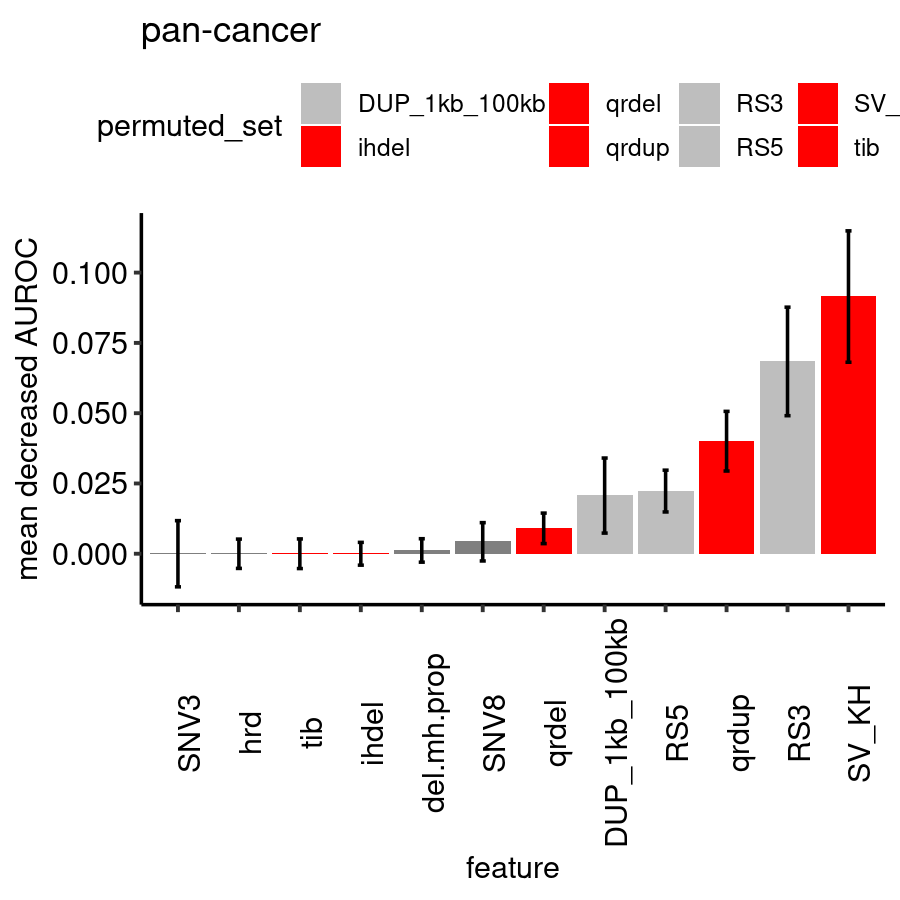

In [123]:
colormap = c("RS3" = "gray", "RS5" = "gray", "tib" = "red", "qrdel" = "red", "qrdup" = "red", "ihdel" = "red", "DUP_1kb_100kb" = "gray", 
             "SV_NZ" = "gray",
             "SV_KH" = "red")

## relevel
hrd.auroc.dt[, permuted_set_level := ordered(permuted_set, levels = c(hrd.auroc.dt[order(mean.dec.auroc), permuted_set]))]

hmf.auroc.pt = ggplot(hrd.auroc.dt, aes(x = permuted_set_level, y = mean.dec.auroc, fill = permuted_set)) +
    geom_bar(stat = "identity") +
    geom_errorbar(aes(ymin = mean.dec.auroc - std.dec.auroc, ymax = mean.dec.auroc + std.dec.auroc), width = 0.1) +
    scale_fill_manual(values = colormap) +
    ggpubr::theme_pubr() +
    labs(x = "feature", y = "mean decreased AUROC", title = "pan-cancer") +
    theme(axis.text.x = element_text(angle = 90))

options(repr.plot.width = 5, repr.plot.height = 5, repr.plot.res = 180)
print(hmf.auroc.pt)

# Figure 5f
Feature importance scores for BRCA1d vs. BRCA2d discrimination, using HRDetect features augmented with Setton et al. SV features, in HMF non-BOPP tumors.

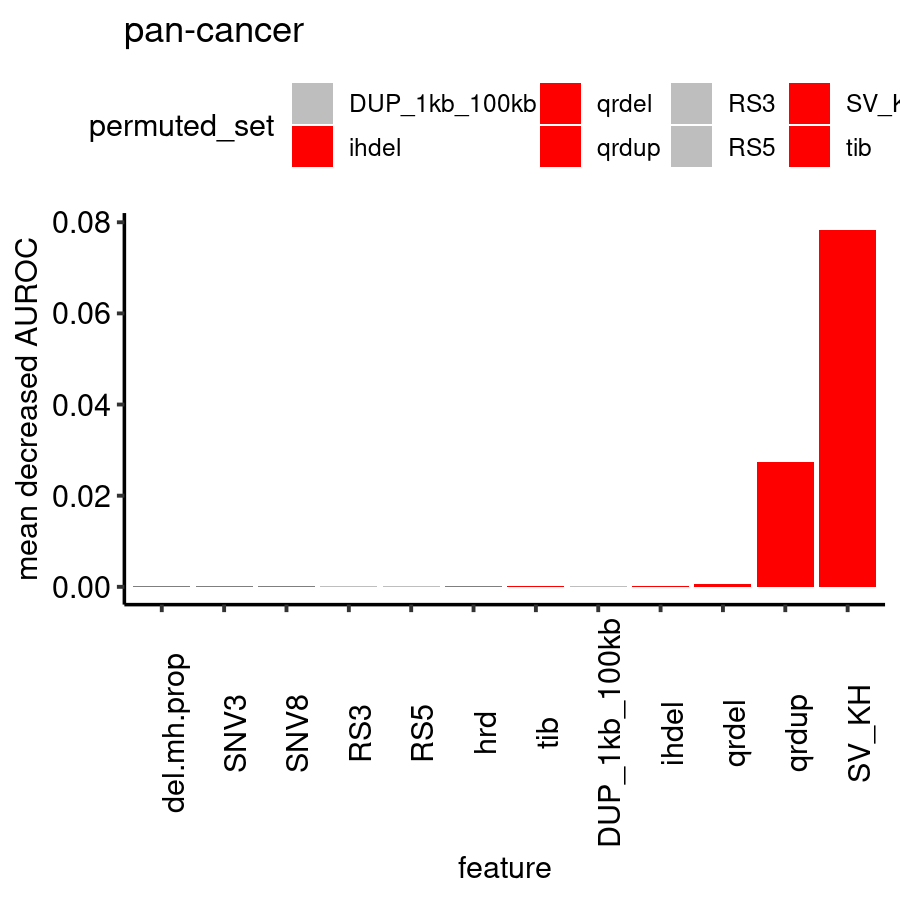

In [122]:
colormap = c("RS3" = "gray", "RS5" = "gray", "tib" = "red", "qrdel" = "red", "qrdup" = "red", "ihdel" = "red", "DUP_1kb_100kb" = "gray", 
             "SV_NZ" = "gray",
             "SV_KH" = "red")

## relevel
hrd.nonbopp.auroc.dt[, permuted_set_level := ordered(permuted_set, levels = c(hrd.nonbopp.auroc.dt[order(mean.dec.auroc), permuted_set]))]

hmf.nonbopp.auroc.pt = ggplot(hrd.nonbopp.auroc.dt, aes(x = permuted_set_level, y = mean.dec.auroc, fill = permuted_set)) +
    geom_bar(stat = "identity") +
    ##geom_errorbar(aes(ymin = mean.dec.auroc - std.dec.auroc, ymax = mean.dec.auroc + std.dec.auroc), width = 0.1) +
    scale_fill_manual(values = colormap) +
    ggpubr::theme_pubr() +
    labs(x = "feature", y = "mean decreased AUROC", title = "pan-cancer") +
    theme(axis.text.x = element_text(angle = 90))

options(repr.plot.width = 5, repr.plot.height = 5, repr.plot.res = 180)
print(hmf.nonbopp.auroc.pt)

# EDF8b
General HR-deficiency discrimination, using HRDetect features augmented with Setton et al. SV features, in all HMF tumors.

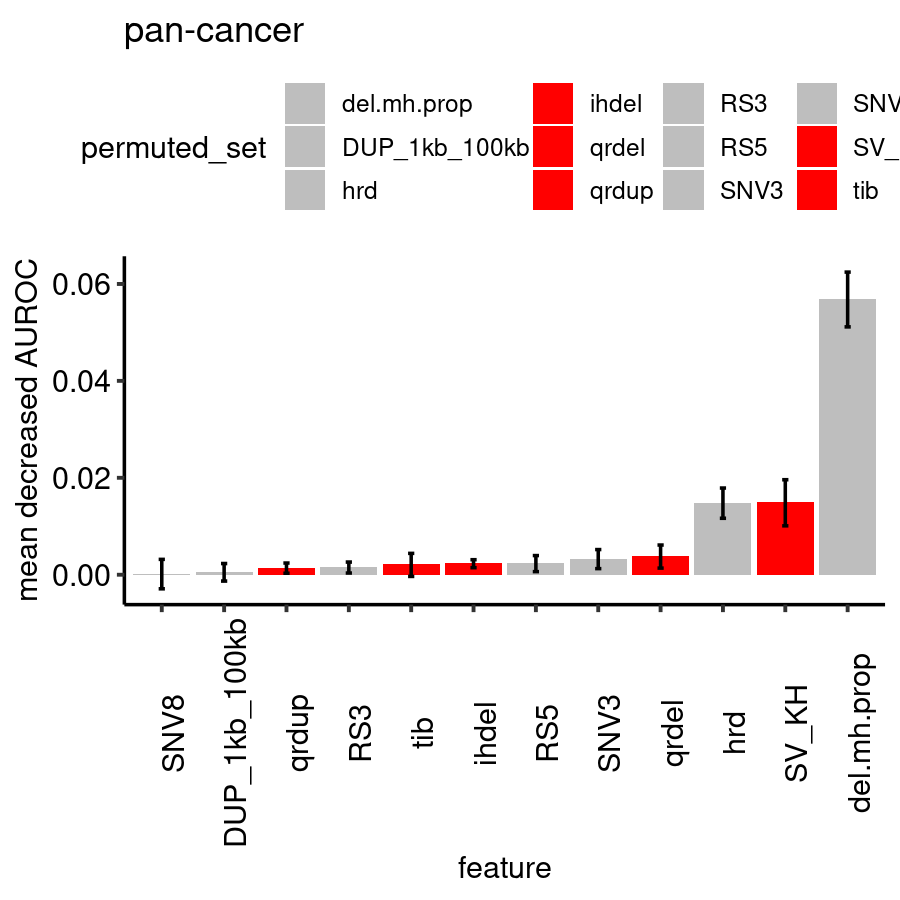

In [133]:
colormap = c("RS3" = "gray", "RS5" = "gray", "tib" = "red", "qrdel" = "red", "qrdup" = "red", "ihdel" = "red", "DUP_1kb_100kb" = "gray", 
             "SV_NZ" = "gray",
             "SV_KH" = "red",
             "del.mh.prop" = "gray",
             "SNV3" = "gray",
             "SNV8" = "gray",
             "hrd" = "gray")

## relevel
hrd.auroc.dt_general[, permuted_set_level := ordered(permuted_set, levels = c(hrd.auroc.dt_general[order(mean.dec.auroc), permuted_set]))]

hmf.auroc.pt = ggplot(hrd.auroc.dt_general, aes(x = permuted_set_level, y = mean.dec.auroc, fill = permuted_set)) +
    geom_bar(stat = "identity") +
    geom_errorbar(aes(ymin = mean.dec.auroc - std.dec.auroc, ymax = mean.dec.auroc + std.dec.auroc), width = 0.1) +
    scale_fill_manual(values = colormap) +
    ggpubr::theme_pubr() +
    labs(x = "feature", y = "mean decreased AUROC", title = "pan-cancer") +
    theme(axis.text.x = element_text(angle = 90))

options(repr.plot.width = 5, repr.plot.height = 5, repr.plot.res = 180)
print(hmf.auroc.pt)

# EDF8c
General HR-deficiency discrimination, using HRDetect features augmented with Setton et al. SV features, in non-BOPP HMF tumors.

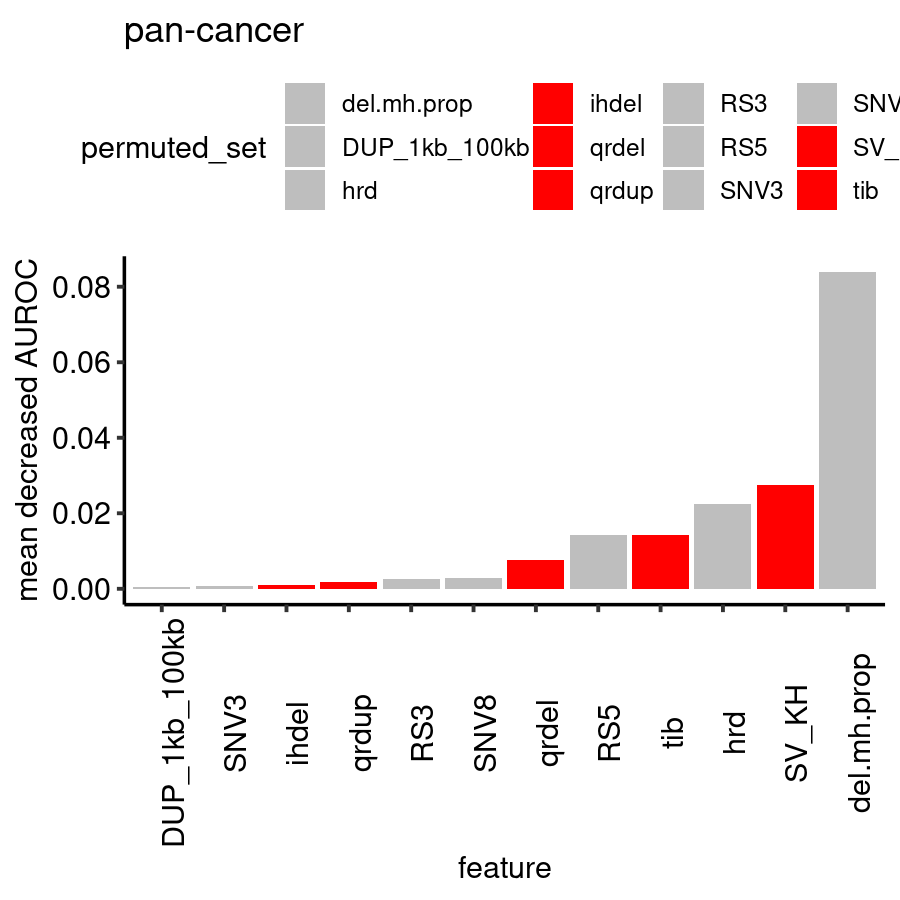

In [134]:
colormap = c("RS3" = "gray", "RS5" = "gray", "tib" = "red", "qrdel" = "red", "qrdup" = "red", "ihdel" = "red", "DUP_1kb_100kb" = "gray", 
             "SV_NZ" = "gray",
             "SV_KH" = "red",
             "del.mh.prop" = "gray",
             "SNV3" = "gray",
             "SNV8" = "gray",
             "hrd" = "gray")

## relevel
hrd.nonbopp.auroc.dt_general[, permuted_set_level := ordered(permuted_set, levels = c(hrd.nonbopp.auroc.dt_general[order(mean.dec.auroc), permuted_set]))]

hmf.nonbopp.auroc.pt = ggplot(hrd.nonbopp.auroc.dt_general, aes(x = permuted_set_level, y = mean.dec.auroc, fill = permuted_set)) +
    geom_bar(stat = "identity") +
    ## geom_errorbar(aes(ymin = mean.dec.auroc - std.dec.auroc, ymax = mean.dec.auroc + std.dec.auroc), width = 0.1) +
    scale_fill_manual(values = colormap) +
    ggpubr::theme_pubr() +
    labs(x = "feature", y = "mean decreased AUROC", title = "pan-cancer") +
    theme(axis.text.x = element_text(angle = 90))

options(repr.plot.width = 5, repr.plot.height = 5, repr.plot.res = 180)
print(hmf.nonbopp.auroc.pt)

# EDF9b
Feature importance scores BRCA1d vs. BRCA2d discrimination, using CHORD features augmented with Setton et al. SV features, in all HMF (pan-cancer) tumors.

In [135]:
## relevel
colormap = c("SV_KH" = "red",
             "qrdup" = "red",
             "DUP_1kb_100kb" = "red",
             "qrdel" = "red",
             "tib" = "red",
             "ihdel" = "red")

chord.auroc.dt[, permuted_set_level := ordered(permuted_set, levels = c(chord.auroc.dt[order(mean.dec.auroc), permuted_set]))]

hmf.auroc.pt = ggplot(chord.auroc.dt, aes(x = permuted_set_level, y = mean.dec.auroc, fill = permuted_set)) +
    geom_bar(stat = "identity") +
    ##geom_errorbar(aes(ymin = mean.dec.auroc - std.dec.auroc, ymax = mean.dec.auroc + std.dec.auroc), width = 0.1) +
    scale_fill_manual(values = colormap) +
    ggpubr::theme_pubr() +
    labs(x = "feature", y = "mean decreased AUROC", title = "pan-cancer HMF - CHORD") +
    theme(axis.text.x = element_text(angle = 90), legend.position = "none")

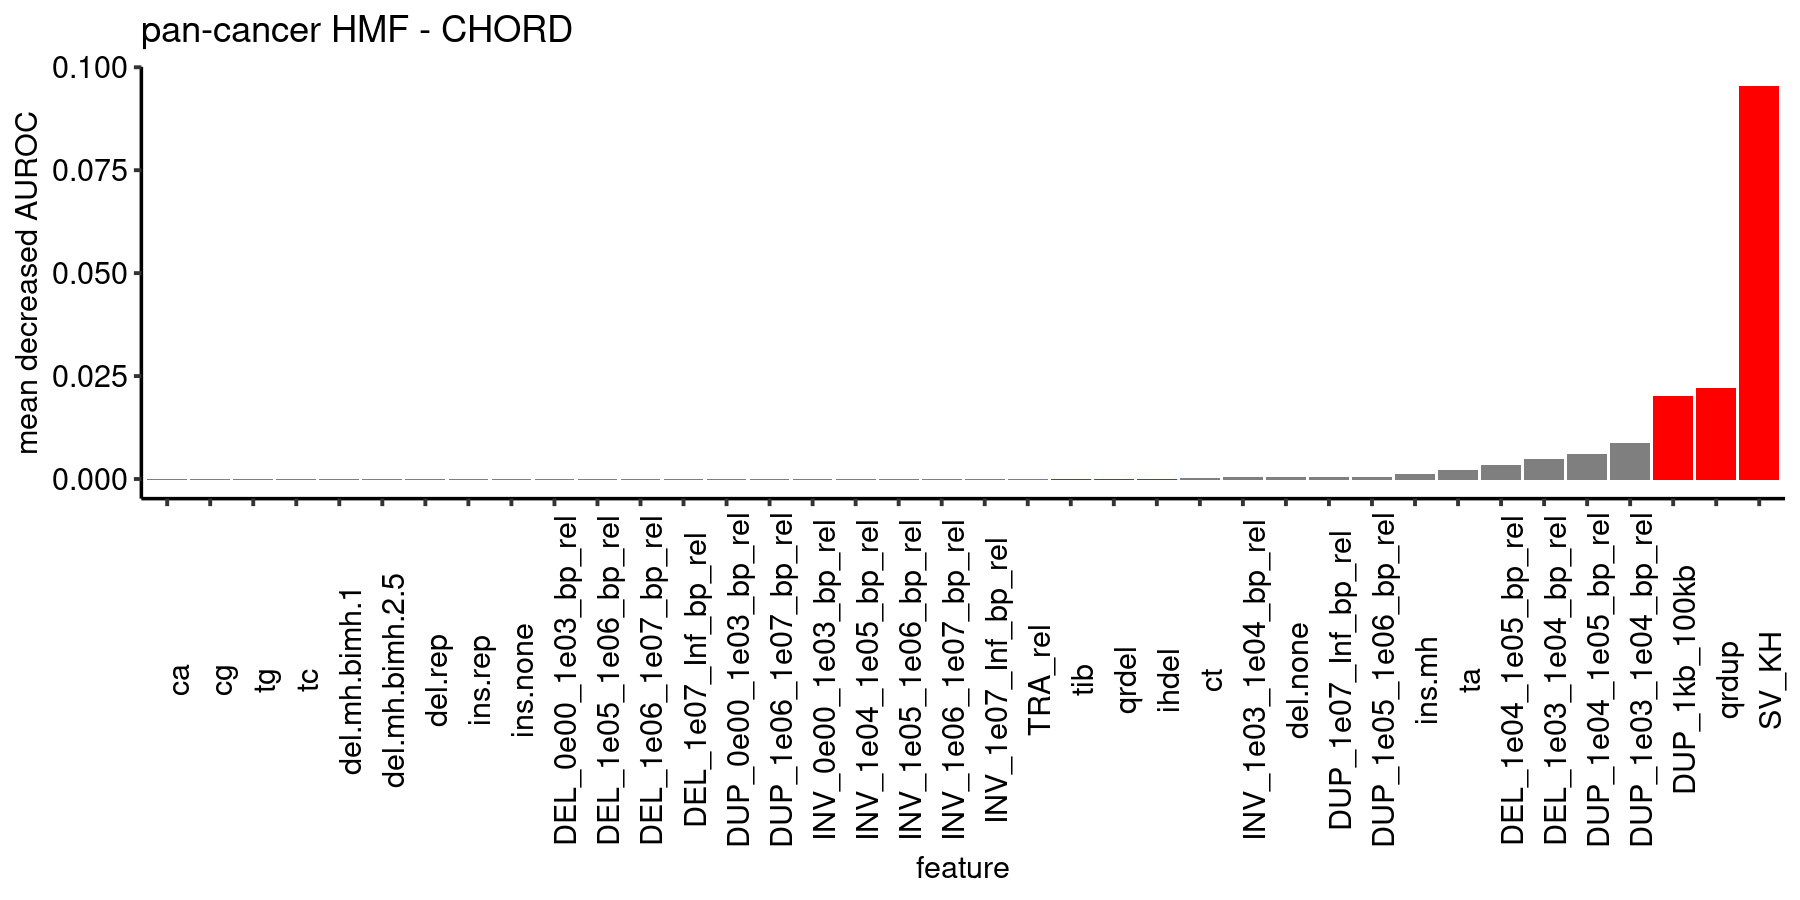

In [136]:
options(repr.plot.width = 10, repr.plot.height = 5, repr.plot.res = 180)
print(hmf.auroc.pt)

# EDF9c
Feature importance scores BRCA1d vs. BRCA2d discrimination, using CHORD features augmented with Setton et al. SV features, in HMF non-BOPP tumors.

In [137]:
## relevel
colormap = c("SV_KH" = "red",
             "qrdup" = "red",
             "DUP_1kb_100kb" = "red",
             "qrdel" = "red",
             "tib" = "red",
             "ihdel" = "red")

chord.nonbopp.auroc.dt[, permuted_set_level := ordered(permuted_set, levels = c(chord.nonbopp.auroc.dt[order(mean.dec.auroc), permuted_set]))]

hmf.nonbopp.auroc.pt = ggplot(chord.nonbopp.auroc.dt, aes(x = permuted_set_level, y = mean.dec.auroc, fill = permuted_set)) +
    geom_bar(stat = "identity") +
    ##geom_errorbar(aes(ymin = mean.dec.auroc - std.dec.auroc, ymax = mean.dec.auroc + std.dec.auroc), width = 0.1) +
    scale_fill_manual(values = colormap) +
    ggpubr::theme_pubr() +
    labs(x = "feature", y = "mean decreased AUROC", title = "non-BOPP HMF") +
    theme(axis.text.x = element_text(angle = 90), legend.position = "none")

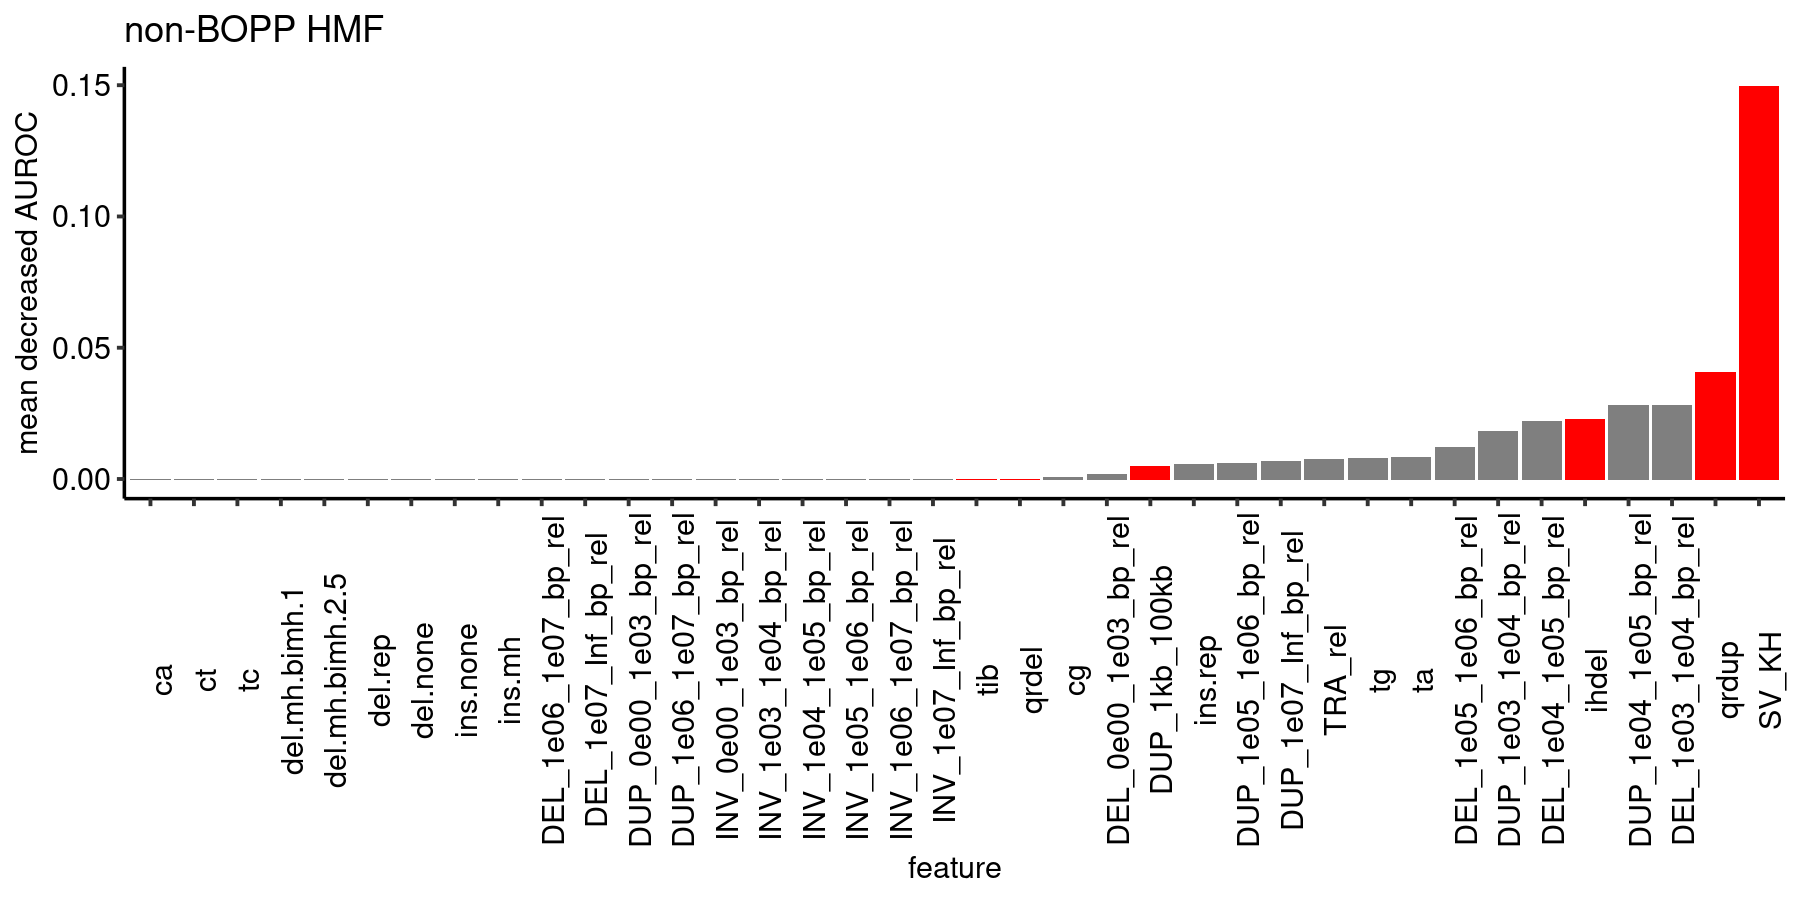

In [138]:
options(repr.plot.width = 10, repr.plot.height = 5, repr.plot.res = 180)
print(hmf.nonbopp.auroc.pt)

In [79]:
## skitools::ppdf(print(hmf.nonbopp.auroc.pt), height = 4, width = 10)

# CHORD feature importance for HR-deficiency overall (not used in paper)

In [140]:
## relevel
chord.auroc.dt_general[, permuted_set_level := ordered(permuted_set, levels = c(chord.auroc.dt_general[order(mean.dec.auroc), permuted_set]))]

hmf.auroc.pt = ggplot(chord.auroc.dt_general, aes(x = permuted_set_level, y = mean.dec.auroc, fill = permuted_set)) +
    geom_bar(stat = "identity") +
    ##geom_errorbar(aes(ymin = mean.dec.auroc - std.dec.auroc, ymax = mean.dec.auroc + std.dec.auroc), width = 0.1) +
    scale_fill_manual(values = colormap) +
    ggpubr::theme_pubr() +
    labs(x = "feature", y = "mean decreased AUROC", title = "pan-cancer HMF") +
    theme(axis.text.x = element_text(angle = 90), legend.position = "none")

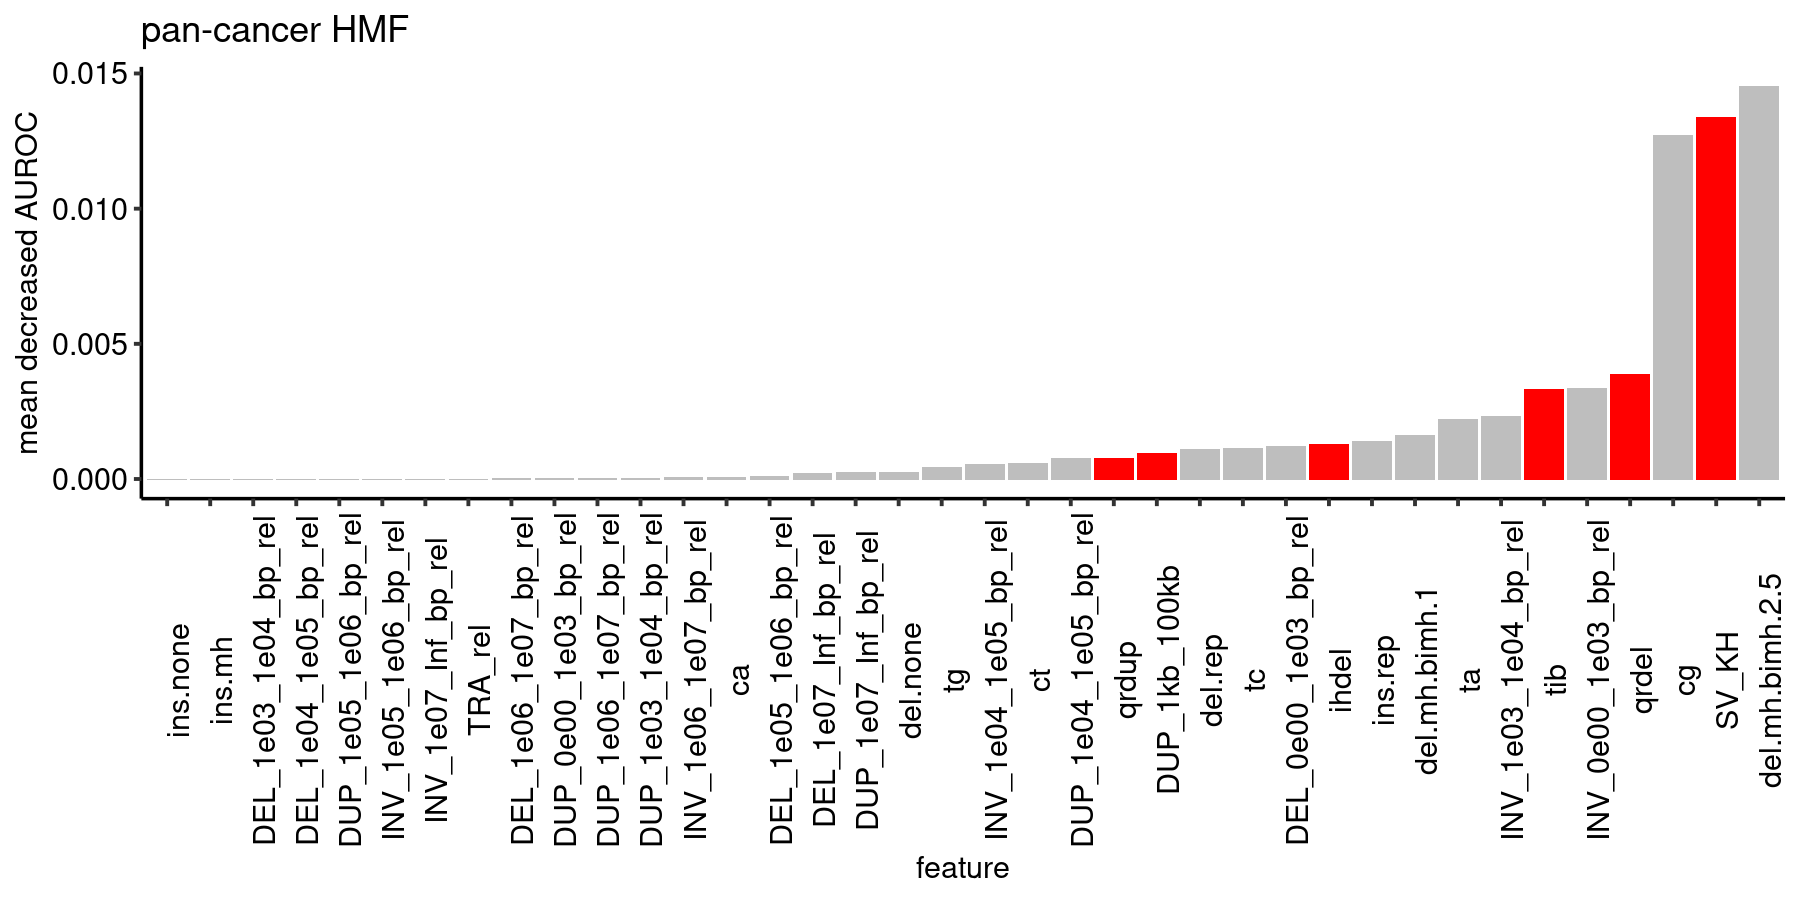

In [141]:
options(repr.plot.width = 10, repr.plot.height = 5, repr.plot.res = 180)
print(hmf.auroc.pt)

In [142]:
skitools::ppdf(print(hmf.auroc.pt), height = 4, width = 10)

rendering to /gpfs/commons/projects/imielinski_web/zchoo/plot.pdf 


png 
  2

In [143]:
## relevel
chord.nonbopp.auroc.dt_general[, permuted_set_level := ordered(permuted_set, 
                                                              levels = c(chord.nonbopp.auroc.dt_general[order(mean.dec.auroc), permuted_set]))]

hmf.nonbopp.auroc.pt = ggplot(chord.nonbopp.auroc.dt_general, aes(x = permuted_set_level, y = mean.dec.auroc, fill = permuted_set)) +
    geom_bar(stat = "identity") +
    ##geom_errorbar(aes(ymin = mean.dec.auroc - std.dec.auroc, ymax = mean.dec.auroc + std.dec.auroc), width = 0.1) +
    scale_fill_manual(values = colormap) +
    ggpubr::theme_pubr() +
    labs(x = "feature", y = "mean decreased AUROC", title = "non-BOPP HMF") +
    theme(axis.text.x = element_text(angle = 90), legend.position = "none")

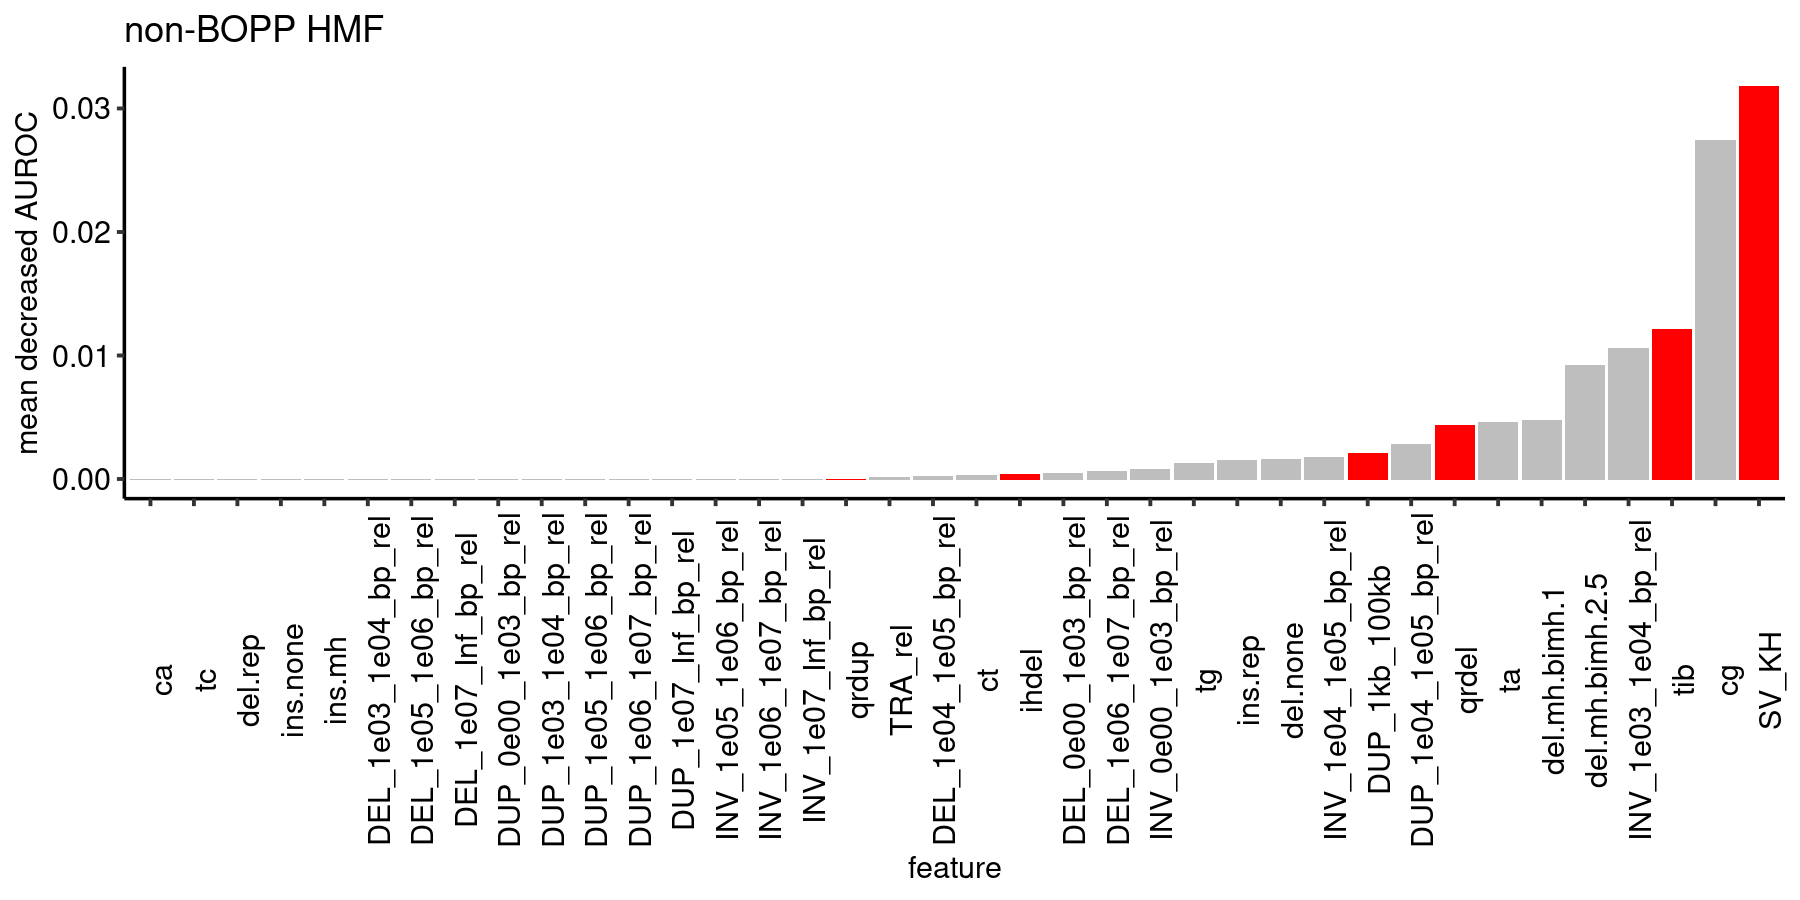

In [144]:
options(repr.plot.width = 10, repr.plot.height = 5, repr.plot.res = 180)
print(hmf.nonbopp.auroc.pt)

In [146]:
skitools::ppdf(print(hmf.nonbopp.auroc.pt), height = 4, width = 10)

rendering to /gpfs/commons/projects/imielinski_web/zchoo/plot.pdf 


png 
  2

# CHORD feature importance for SV features only overall (not used in paper)

In [147]:
## relevel
chord.auroc.dt_svonly[, permuted_set_level := ordered(permuted_set, levels = c(chord.auroc.dt_svonly[order(mean.dec.auroc), permuted_set]))]

hmf.auroc.pt = ggplot(chord.auroc.dt_svonly, aes(x = permuted_set_level, y = mean.dec.auroc, fill = permuted_set)) +
    geom_bar(stat = "identity") +
    ##geom_errorbar(aes(ymin = mean.dec.auroc - std.dec.auroc, ymax = mean.dec.auroc + std.dec.auroc), width = 0.1) +
    scale_fill_manual(values = colormap) +
    ggpubr::theme_pubr() +
    labs(x = "feature", y = "mean decreased AUROC", title = "pan-cancer HMF") +
    theme(axis.text.x = element_text(angle = 90), legend.position = "none")

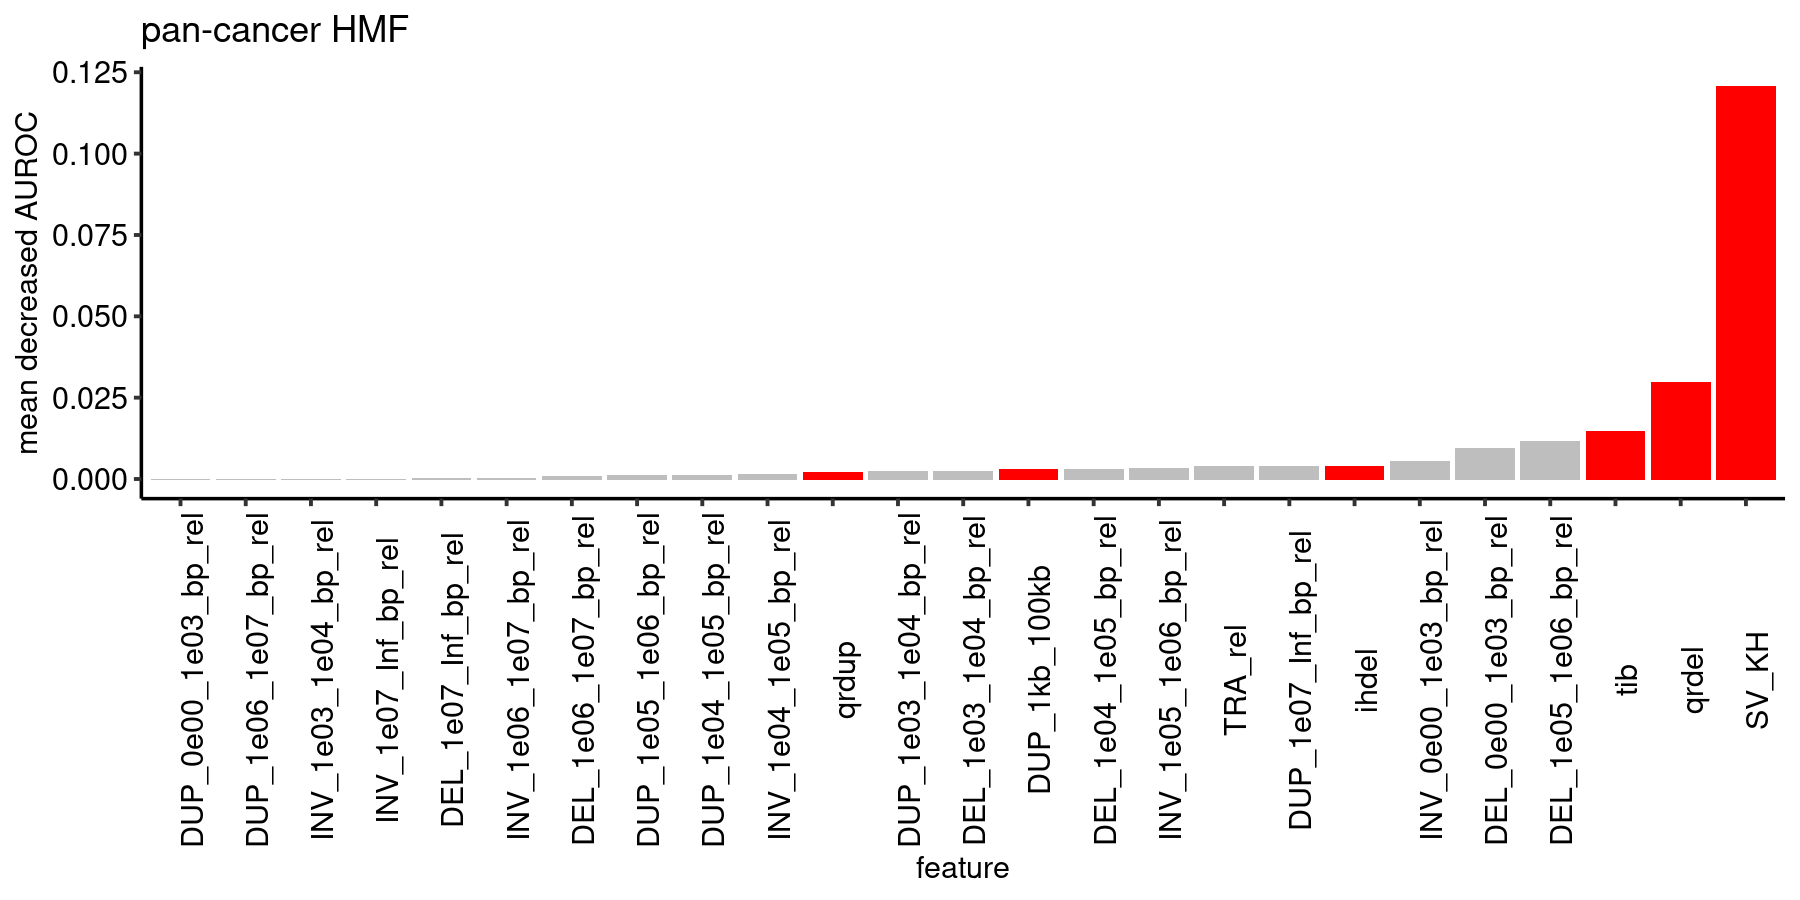

In [148]:
options(repr.plot.width = 10, repr.plot.height = 5, repr.plot.res = 180)
print(hmf.auroc.pt)

In [80]:
## skitools::ppdf(print(hmf.auroc.pt), height = 4, width = 8)

In [150]:
## relevel
chord.nonbopp.auroc.dt_svonly[, permuted_set_level := ordered(permuted_set, 
                                                              levels = c(chord.nonbopp.auroc.dt_svonly[order(mean.dec.auroc), permuted_set]))]

hmf.nonbopp.auroc.pt = ggplot(chord.nonbopp.auroc.dt_svonly, aes(x = permuted_set_level, y = mean.dec.auroc, fill = permuted_set)) +
    geom_bar(stat = "identity") +
    ##geom_errorbar(aes(ymin = mean.dec.auroc - std.dec.auroc, ymax = mean.dec.auroc + std.dec.auroc), width = 0.1) +
    scale_fill_manual(values = colormap) +
    ggpubr::theme_pubr() +
    labs(x = "feature", y = "mean decreased AUROC", title = "non-BOPP HMF") +
    theme(axis.text.x = element_text(angle = 90), legend.position = "none")

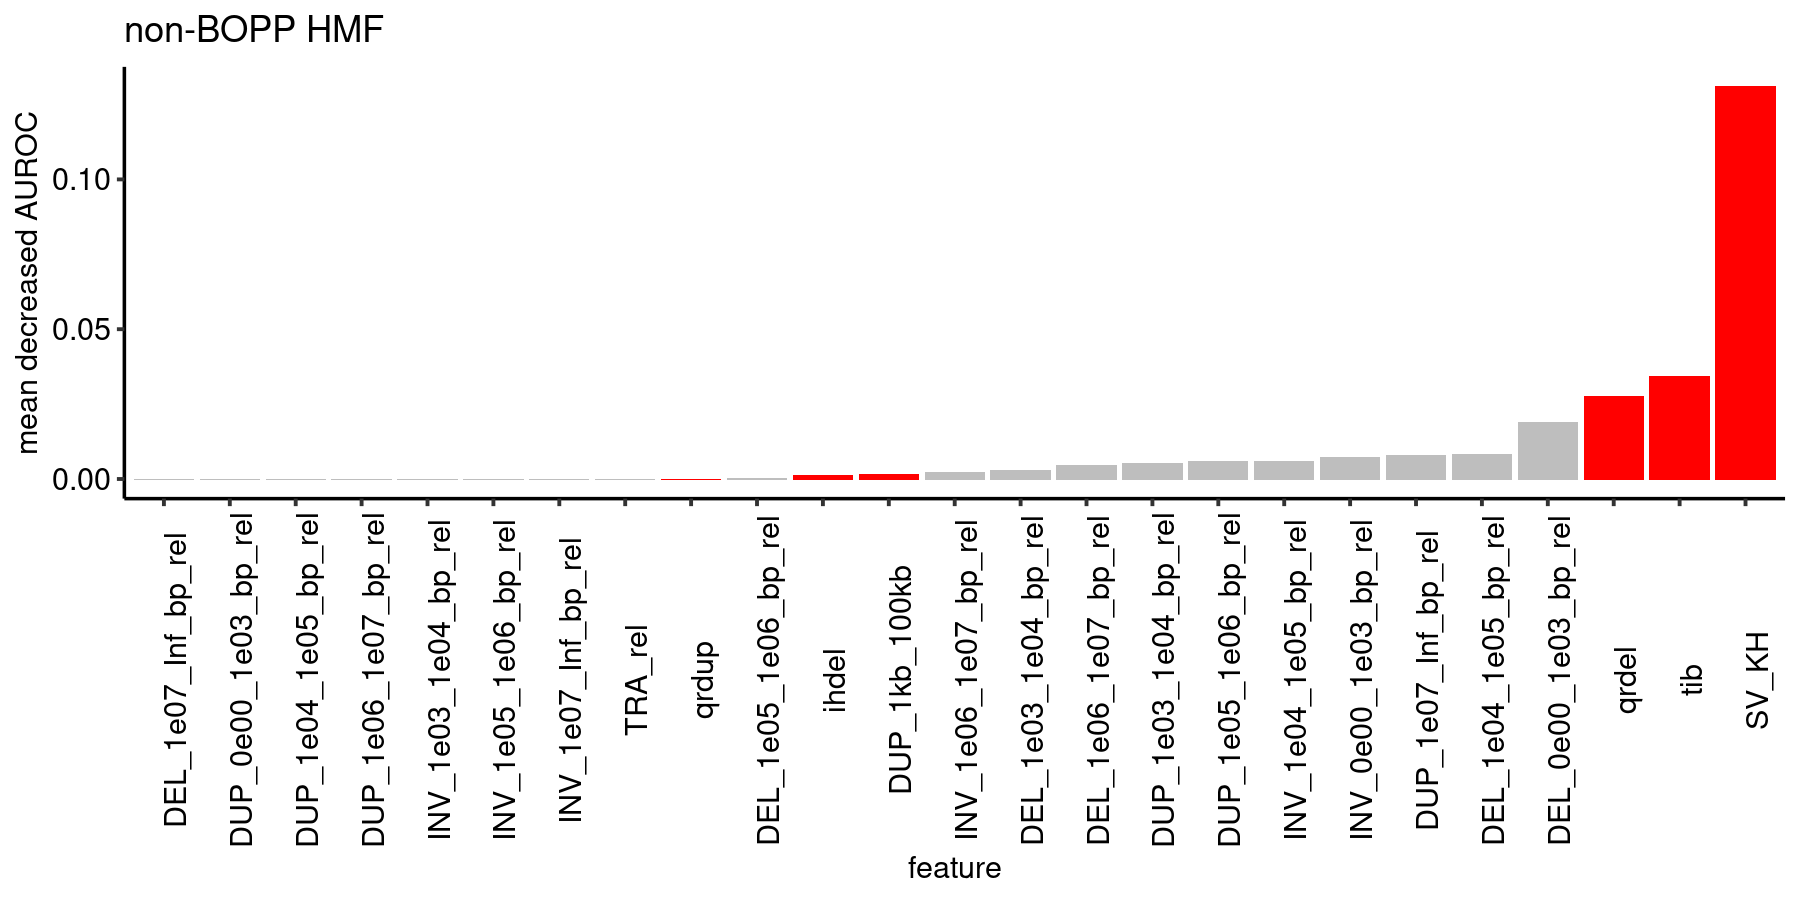

In [151]:
options(repr.plot.width = 10, repr.plot.height = 5, repr.plot.res = 180)
print(hmf.nonbopp.auroc.pt)

In [81]:
## skitools::ppdf(print(hmf.nonbopp.auroc.pt), height = 4, width = 8)

## Figure 5g
Frequency of HR-deficiency, as defined by B1 or B2 score >0.5, among common cancer types.

In [142]:
##b12.train.1v2.x = as.data.frame(all.features.dt[(train.set), .SD, .SDcols = features_hrd_kh])
##hrd.train.1v2.x = as.data.frame(all.features.dt[(train.set), .SD, .SDcols = features_hrd_only])

## response variable is the same
##train.1v2.y = all.features.dt[(train.set) & (fmut_bi != "WT"), ordered(fmut_bi, levels = c("BRCA2", "BRCA1"))]
##train.b1.y = all.features.dt[(train.set), ordered(ifelse(fmut_bi == "BRCA1", "BRCA1", "OTHER"), levels = c("OTHER", "BRCA1"))]
##train.b2.y = all.features.dt[(train.set), ordered(ifelse(fmut_bi == "BRCA2", "BRCA2", "OTHER"), levels = c("OTHER", "BRCA2"))]

## get ALL features from the test set
##all.samples.x = as.data.frame(all.features.dt[, .SD, .SDcols = features_hrd_kh])

## same procedure for the test set
## b12.test.1v2.x = as.data.frame(all.features.dt[(test.set) & (fmut_bi != "WT"), .SD, .SDcols = big_features_ot])
## hrd.test.1v2.x = as.data.frame(all.features.dt[(test.set) & (fmut_bi != "WT"), .SD, .SDcols = big_features_hrdetect])
## test.1v2.y = all.features.dt[(test.set) & (fmut_bi != "WT"), ordered(fmut_bi, levels = c("BRCA2", "BRCA1"))]
## test.b1.y = all.features.dt[(test.set) & (fmut_bi != "WT"), ordered(ifelse(fmut_bi == "BRCA1", "BRCA1", "OTHER"), levels = c("OTHER", "BRCA1"))]
## test.b1.y = all.features.dt[(test.set) & (fmut_bi != "WT"), ordered(ifelse(fmut_bi == "BRCA1", "BRCA1", "OTHER"), levels = c("OTHER", "BRCA1"))]

## sub-test set for non-bopp tumors
## b12.nonbopp.test.1v2.x = as.data.frame(all.features.dt[(test.set) & (!in_bopp) & (fmut_bi != "WT"), .SD, .SDcols = big_features_ot])
##nonbopp.test.1v2.y = all.features.dt[(test.set) & (!in_bopp) & (fmut_bi != "WT"), ordered(fmut_bi, levels = c("BRCA2", "BRCA1"))]
## nonbopp.test.1v2.y = all.features.dt[(test.set) & (!in_bopp) & (fmut_bi != "WT"), ordered(ifelse(fmut_bi == "BRCA1", "BRCA1", "OTHER"), levels = c("OTHER", "BRCA1"))]

In [143]:
##set.seed(10)
##rf.b1 = randomForest::randomForest(x = b12.train.1v2.x, y = train.b1.y, ntree = 1000, importance = TRUE)

##set.seed(10)
##rf.b2 = randomForest::randomForest(x = b12.train.1v2.x, y = train.b2.y, ntree = 1000, importance = TRUE)

In [155]:
## get a data table with predictions
##predictions.dt = all.features.dt[, .(pair,
##                                     b1 = predict(rf.b1, all.samples.x, type = "prob")[, -1],
##                                     b2 = predict(rf.b2, all.samples.x, type = "prob")[, -1])]

In [161]:
##saveRDS(predictions.dt[, .(sample = pair, b1, b2)], "./data/random_forest/predictions.dt.rds")

In [162]:
predictions.dt = readRDS("./data/random_forest/predictions.dt.rds")

In [164]:
## make a plot by tumor type
setkey(hrd_tbl, "pair")
pt.dt = predictions.dt[, .SD][, tumor_type_final := hrd_tbl[sample, tumor_type_final]][!is.na(tumor_type_final)][, .(b1 = sum(b1 > 0.5) / .N, b2 = sum(b2 > 0.5) / .N, n = .N), by = tumor_type_final]
pt.dt[, label := ifelse(tumor_type_final %in% c("OV", "BRCA", "PRAD", "PACA"), tumor_type_final, NA_character_)]


pt = ggplot(pt.dt[n > 20], aes(x = b2, y = b1)) +
geom_point() +
geom_abline(slope = 1) +
geom_label(aes(label = label), position=position_jitter(w=.05, h=.05)) +
xlim(0, 0.25) + 
ylim(0, 0.25) +
ggpubr::theme_pubr() +
labs(x = "fraction of samples B2 > 0.5", y = "fraction of samples B1 > 0.5")

Warning message:
“Removed 32 rows containing missing values (`geom_label()`).”


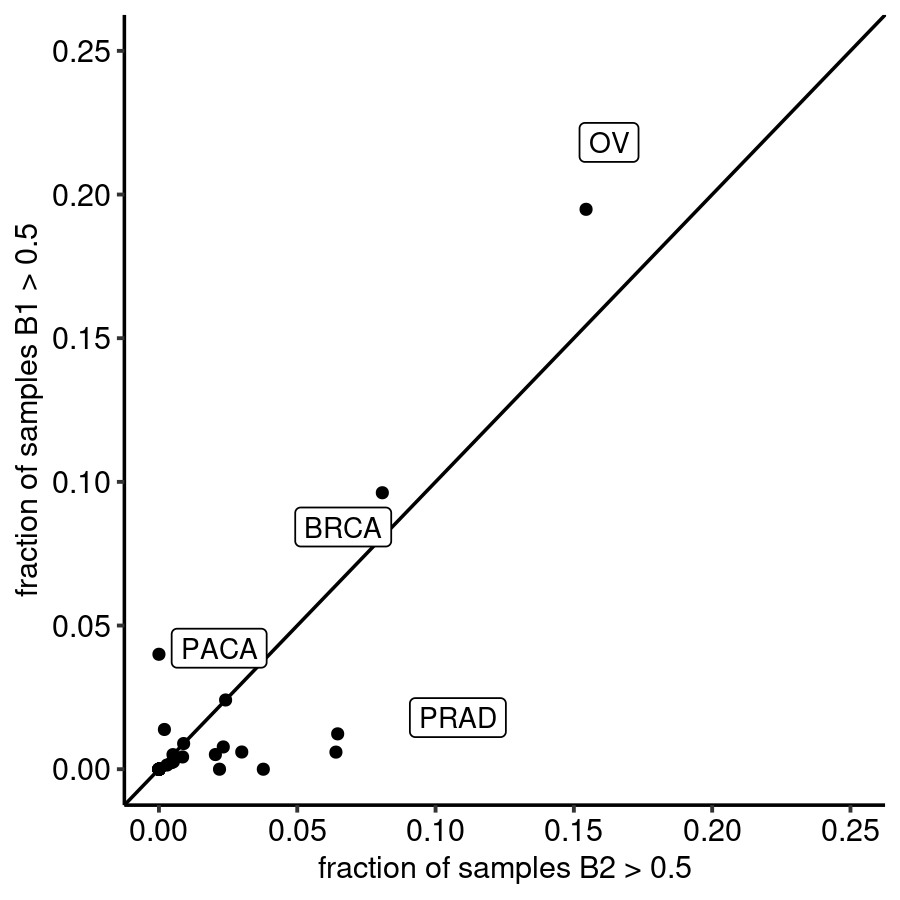

In [165]:
options(repr.plot.width = 5, repr.plot.height = 5, repr.plot.res = 180)
print(pt)

## Fig. 5h
B1 and B2 scores in the B1+2 classifier across all samples analyzed in this study including those excluded from training and testing for harboring VUS or mono-allelic variants.

In [257]:
hrd_tbl = readRDS("./data/hrd-supp-table_ZC.rds")
predictions.dt = readRDS("./data/random_forest/predictions.dt.rds")
predictions.dt[, ":="(b1 = hrd_tbl[sample, BRCA1], b2 = hrd_tbl[sample, BRCA2])]

In [258]:
## transfer some genotype annotations...
predictions.dt[, fmut_bi := hrd_tbl[sample, fmut_bi]]
predictions.dt[, biallelic_vus_brca := hrd_tbl[sample, biallelic_vus_brca]]
predictions.dt[, monoallelic_vus_brca := hrd_tbl[sample, monoallelic_vus_brca]]
predictions.dt[, monoallelic_pathogenic_brca := hrd_tbl[sample, monoallelic_pathogenic_brca]]
predictions.dt[, monoallelic_likpathogenic_brca := hrd_tbl[sample, monoallelic_likpathogenic_brca]]

## biallelic pathogenic vs vus - non BRCA
predictions.dt[, biallelic_pathogenic_tier2 := hrd_tbl[sample, biallelic_pathogenic_tier2]]
predictions.dt[, biallelic_pathogenic_tier3 := hrd_tbl[sample, biallelic_pathogenic_tier3]]
predictions.dt[, biallelic_vus_tier2 := hrd_tbl[sample, biallelic_vus_tier2]]
predictions.dt[, biallelic_vus_tier3 := hrd_tbl[sample, biallelic_vus_tier3]]

## monoallelic pathogenic vs vus - non BRCA
predictions.dt[, monoallelic_pathogenic_tier2 := hrd_tbl[sample, monoallelic_pathogenic_tier2]]
predictions.dt[, monoallelic_pathogenic_tier3 := hrd_tbl[sample, monoallelic_pathogenic_tier3]]
predictions.dt[, monoallelic_vus_tier2 := hrd_tbl[sample, monoallelic_vus_tier2]]
predictions.dt[, monoallelic_vus_tier3 := hrd_tbl[sample, monoallelic_vus_tier3]]


predictions.dt[, monoallelic_or_vus := bar <- apply(predictions.dt[, .(biallelic_vus_brca, monoallelic_vus_brca, monoallelic_pathogenic_brca, monoallelic_likpathogenic_brca)], 
                                                    1, 
                                                    function(x) paste0(x[!is.na(x)], collapse = ""))]

In [259]:
predictions.dt[is.na(fmut_bi), fmut_bi := "OTHER"]

predictions.dt[, genotype_category := ifelse(fmut_bi == "WT", 
                                "WT", 
                                ifelse(fmut_bi == "BRCA1", 
                                       "BRCA1 biallelic pathogenic", 
                                       ifelse(fmut_bi == "BRCA2",
                                              "BRCA2 biallelic pathogenic",
                                              ifelse((!is.na(biallelic_pathogenic_tier2)) | (!is.na(biallelic_pathogenic_tier3)),
                                                     "OTHER biallelic pathogenic",
                                                     "monoallelic or VUS"))))]

colpal = character()
colpal["WT"] = alpha("black", 0.1)
colpal["BRCA1 biallelic pathogenic"] = alpha("cornflower blue", 0.8)
colpal["BRCA2 biallelic pathogenic"] = alpha("pink", 0.8)
colpal["OTHER biallelic pathogenic"] = alpha("purple", 0.9)
colpal["monoallelic or VUS"] = alpha("green", 0.05)
  
pt = ggplot(predictions.dt[!is.na(genotype_category)], aes(x = jitter(b2, amount = 0.01), y = jitter(b1, amount = 0.01), colour = genotype_category)) +
    geom_point(size = 0.1) + scale_colour_manual(values = colpal) +
    ggpubr::theme_pubr() +
    labs(x = "B2", y = "B1") +
    theme(legend.position = "right")

Warning message:
“Removed 4 rows containing missing values (`geom_point()`).”


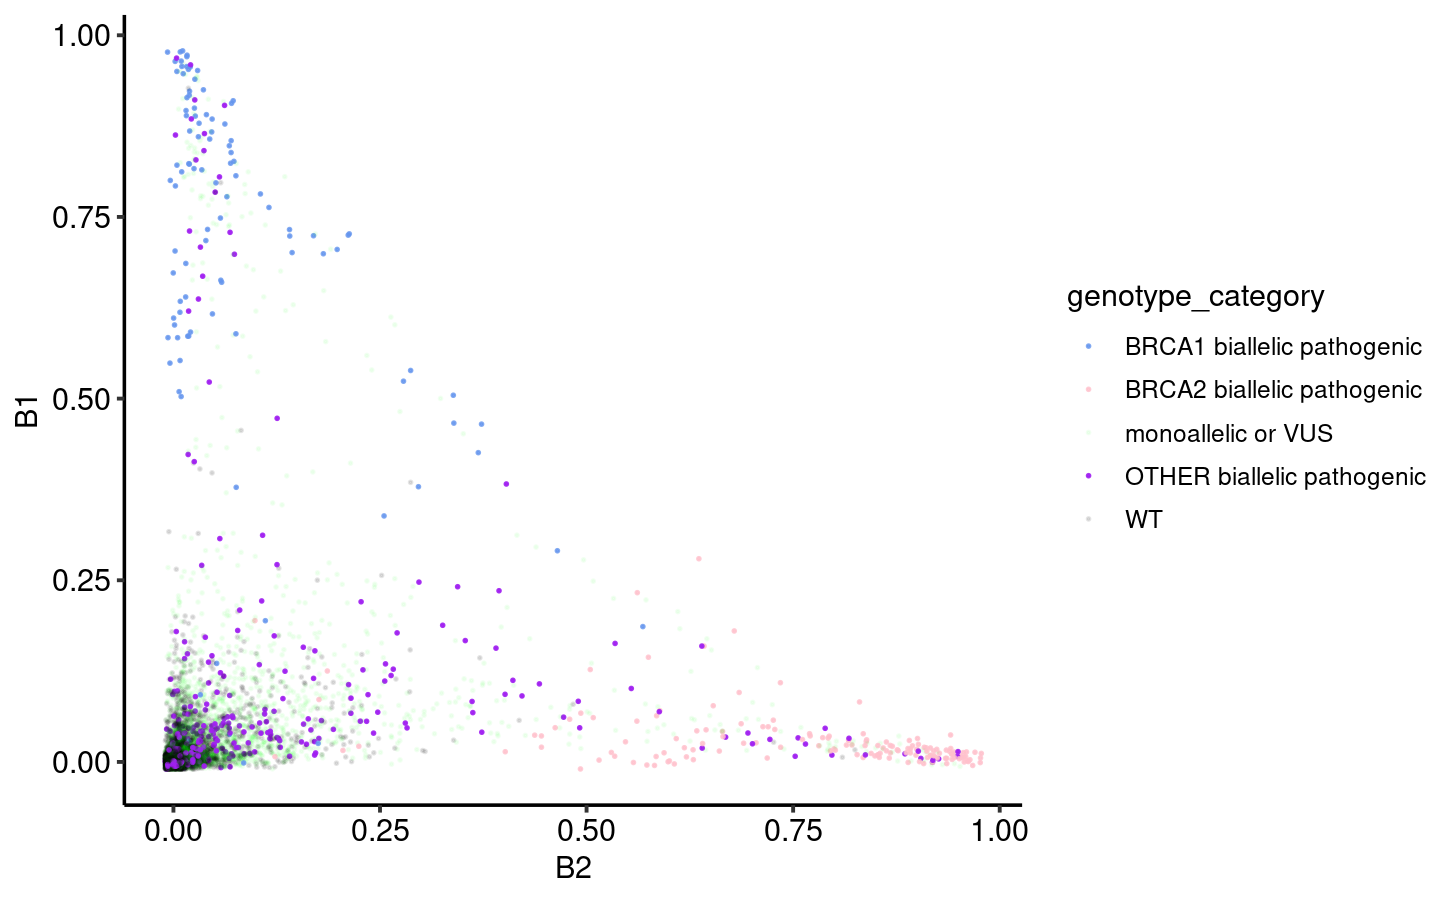

In [260]:
options(repr.plot.width = 8, repr.plot.height = 5, repr.plot.res = 180)
print(pt)

## Figure 5i
Frequency of cases that are B1- or B2-positive (score >0.5) for genes harboring a rare biallelic germline or somatic mutation in additional (i.e. not BRCA1 or BRCA2) HR pathway genes.

In [261]:
## transfer some genotype annotations...
predictions.dt[, fmut_bi := hrd_tbl[sample, fmut_bi]]
predictions.dt[, biallelic_vus_brca := hrd_tbl[sample, biallelic_vus_brca]]
predictions.dt[, monoallelic_vus_brca := hrd_tbl[sample, monoallelic_vus_brca]]
predictions.dt[, monoallelic_pathogenic_brca := hrd_tbl[sample, monoallelic_pathogenic_brca]]
predictions.dt[, monoallelic_likpathogenic_brca := hrd_tbl[sample, monoallelic_likpathogenic_brca]]

## biallelic pathogenic vs vus - non BRCA
predictions.dt[, biallelic_pathogenic_tier2 := hrd_tbl[sample, biallelic_pathogenic_tier2]]
predictions.dt[, biallelic_pathogenic_tier3 := hrd_tbl[sample, biallelic_pathogenic_tier3]]
predictions.dt[, biallelic_vus_tier2 := hrd_tbl[sample, biallelic_vus_tier2]]
predictions.dt[, biallelic_vus_tier3 := hrd_tbl[sample, biallelic_vus_tier3]]

## monoallelic pathogenic vs vus - non BRCA
predictions.dt[, monoallelic_pathogenic_tier2 := hrd_tbl[sample, monoallelic_pathogenic_tier2]]
predictions.dt[, monoallelic_pathogenic_tier3 := hrd_tbl[sample, monoallelic_pathogenic_tier3]]
predictions.dt[, monoallelic_vus_tier2 := hrd_tbl[sample, monoallelic_vus_tier2]]
predictions.dt[, monoallelic_vus_tier3 := hrd_tbl[sample, monoallelic_vus_tier3]]

## grab genotype
predictions.dt[fmut_bi == "WT", barplot_genotype := "WT"]

predictions.dt[fmut_bi == "BRCA1" | fmut_bi == "BRCA2", barplot_genotype := "BRCA1/2 biallelic pathogenic"]
predictions.dt[is.na(barplot_genotype) & !is.na(biallelic_vus_brca), barplot_genotype := "BRCA1/2 biallelic vus"]
predictions.dt[is.na(barplot_genotype) & !is.na(monoallelic_pathogenic_brca), barplot_genotype := "BRCA1/2 monoallelic pathogenic"]
predictions.dt[is.na(barplot_genotype) & !is.na(monoallelic_vus_brca), barplot_genotype := "BRCA1/2 monoallelic vus"]

predictions.dt[is.na(barplot_genotype) & (!is.na(biallelic_pathogenic_tier2) | !is.na(biallelic_pathogenic_tier3)), barplot_genotype := "OTHER biallelic pathogenic"]
predictions.dt[is.na(barplot_genotype) & (!is.na(biallelic_vus_tier2) | !is.na(biallelic_vus_tier3)), barplot_genotype := "OTHER biallelic vus"]
predictions.dt[is.na(barplot_genotype) & (!is.na(monoallelic_pathogenic_tier2) | !is.na(monoallelic_pathogenic_tier3)), barplot_genotype := "OTHER monoallelic pathogenic"]
predictions.dt[is.na(barplot_genotype), barplot_genotype := "OTHER monoallelic vus"]

In [262]:
predictions.dt[, barplot_genotype_factor := ordered(barplot_genotype,
                                                   levels = c("BRCA1/2 biallelic pathogenic",
                                                              "BRCA1/2 biallelic vus",
                                                              "BRCA1/2 monoallelic pathogenic",
                                                              "BRCA1/2 monoallelic vus",
                                                              "OTHER biallelic pathogenic",
                                                              "OTHER biallelic vus",
                                                              "OTHER monoallelic pathogenic",
                                                              "OTHER monoallelic vus",
                                                             "WT"))]

In [263]:
pt.dt = predictions.dt[, .(n = .SD[(b1 > 0.5 | b2 > 0.5), .N], tot = .N), by = .(barplot_genotype_factor)]

pt.dt[, ci.lower := mapply(function(x, y) {skitools::dflm(prop.test(x, y))$ci.lower}, n, tot) %>% unlist] 
pt.dt[, ci.upper := mapply(function(x, y) {skitools::dflm(prop.test(x, y))$ci.upper}, n, tot) %>% unlist] 
pt.dt[, frac := n / tot]

pt = ggplot(pt.dt, aes(x = barplot_genotype_factor, y = frac)) +
geom_bar(stat = "identity") +
geom_errorbar(aes(ymin = ci.lower, ymax = ci.upper), width = 0.2, position = "dodge") +
ggpubr::theme_pubr()+
labs(x = "genotype", y = "fraction of samples", title = "tumors with B1 or B2 > 0.5") +
theme(axis.text.x = element_text(angle = 90))

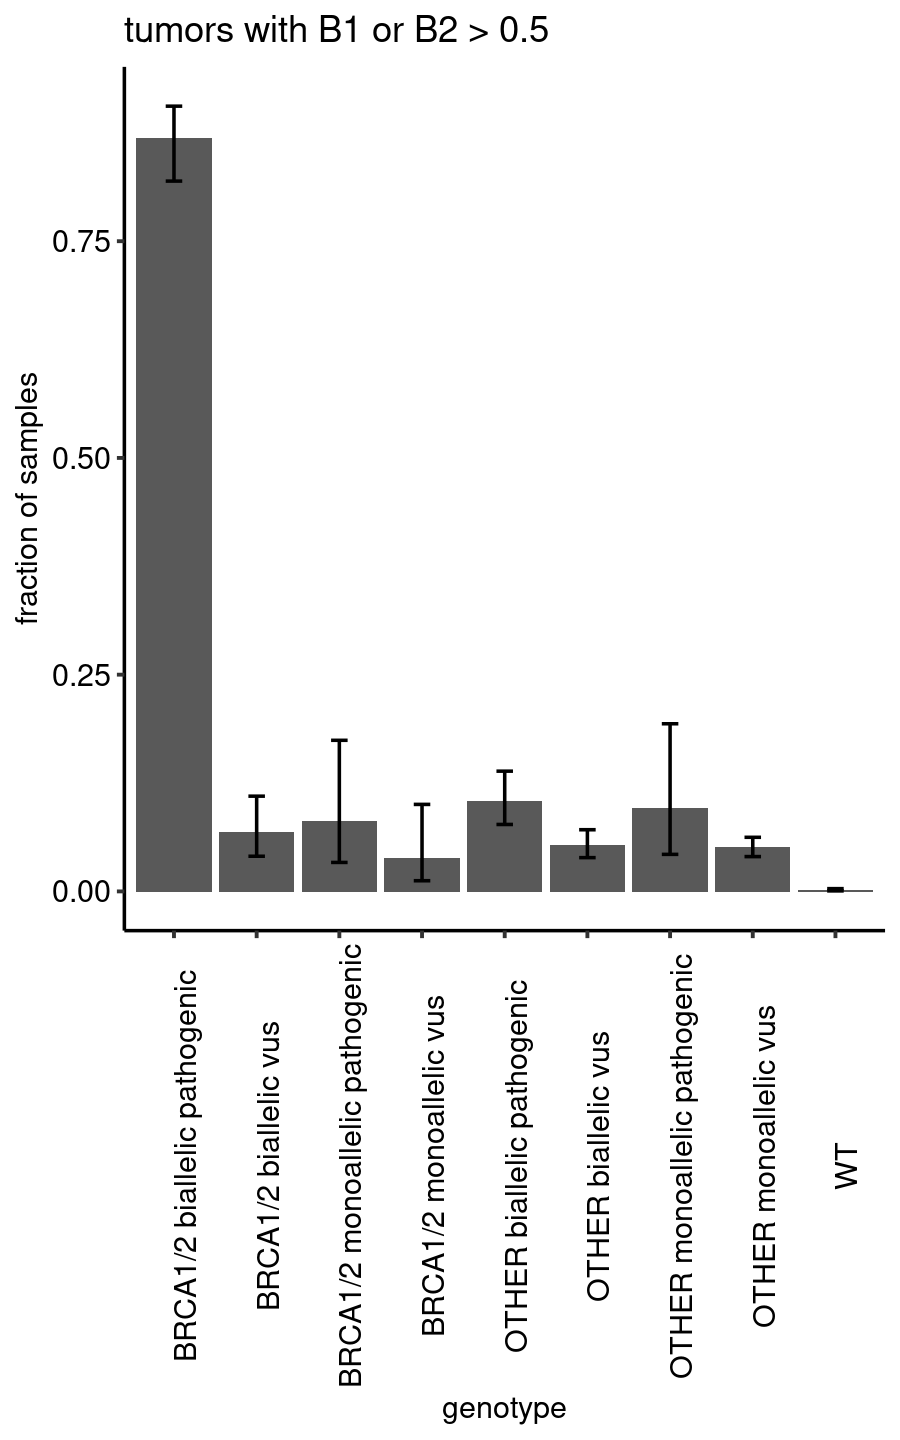

In [264]:
options(repr.plot.width = 5, repr.plot.height = 8, repr.plot.res = 180)
print(pt)

# EDF8d
Scatterplot of B1+2 versus HRDetect scores

In [211]:
## TRAINING SET
## use different features as predictors
b12.train.big.x = as.data.frame(all.features.dt[(train.set), .SD, .SDcols = features_hrd_only])
hrd.train.big.x = as.data.frame(all.features.dt[(train.set), .SD, .SDcols = features_hrd_kh])
## use different features as predictors
b12.train.svonly.x = as.data.frame(all.features.dt[(train.set), .SD, .SDcols = svonly_hrd_kh])
hrd.train.svonly.x = as.data.frame(all.features.dt[(train.set), .SD, .SDcols = svonly_hrd_only])
## rename columns

## response variable is the same
train.big.y = all.features.dt[(train.set), ordered(ifelse(fmut_bi == "WT", "WT", "HRD"), levels = c("WT", "HRD"))]

## TEST SETS
## same procedure for the test set
b12.test.big.x = as.data.frame(all.features.dt[, .SD, .SDcols = features_hrd_kh])
hrd.test.big.x = as.data.frame(all.features.dt[, .SD, .SDcols = features_hrd_only])
## rename columns
## names(hrd.test.big.x)[names(hrd.test.big.x) == "RS3"] = "SV3"
## names(hrd.test.big.x)[names(hrd.test.big.x) == "RS5"] = "SV5"


## SV ONLY MODELS
## TEST SET
b12.test.svonly.x = as.data.frame(all.features.dt[, .SD, .SDcols = svonly_hrd_kh])
hrd.test.svonly.x = as.data.frame(all.features.dt[, .SD, .SDcols = svonly_hrd_only])
## response variable for test set
test.big.y = all.features.dt[, ordered(ifelse(fmut_bi == "WT", "WT", "HRD"), levels = c("WT", "HRD"))]

## sub-test set for non-bopp tumors
b12.nonbopp.test.big.x = as.data.frame(all.features.dt[(!in_bopp), .SD, .SDcols = features_hrd_kh])
## sv only models
b12.nonbopp.svonly.big.x = as.data.frame(all.features.dt[(!in_bopp), .SD, .SDcols = svonly_hrd_kh])
hrd.nonbopp.svonly.big.x = as.data.frame(all.features.dt[(!in_bopp), .SD, .SDcols = svonly_hrd_only])
## response variable for non-bopp tumors
nonbopp.test.big.y = all.features.dt[(!in_bopp), ordered(ifelse(fmut_bi == "WT", "WT", "HRD"), levels = c("WT", "HRD"))]

In [212]:
## set.seed(10)
## rf.big.b12 = randomForest::randomForest(x = b12.train.big.x, y = train.big.y, ntree = 1000, importance = TRUE)
## set.seed(10)
## rf.big.hrd = randomForest::randomForest(x = hrd.train.big.x, y = train.big.y, ntree = 1000, importance = TRUE)
## set.seed(10)
## rf.svonly.b12 = randomForest::randomForest(x = b12.train.svonly.x, y = train.big.y, ntree = 1000, importance = TRUE)
## set.seed(10)
## rf.svonly.hrd = randomForest::randomForest(x = hrd.train.svonly.x, y = train.big.y, ntree = 1000, importance = TRUE)

In [213]:
## names(hrd.test.big.x)[names(hrd.test.big.x) == "RS3"] = "SV3"
## names(hrd.test.big.x)[names(hrd.test.big.x) == "RS5"] = "SV5"
## names(hrd.train.big.x)[names(hrd.test.big.x) == "RS3"] = "SV3"
## names(hrd.train.big.x)[names(hrd.test.big.x) == "RS5"] = "SV5"

In [223]:
##predictions.dt = all.features.dt[, .(sample = pair,
##                                     b12 = predict(rf.big.b12, b12.test.big.x, type = "prob")[, -1],
##                                     hrd = signature.tools.lib::applyHRDetectDavies2017(hrd.test.big.x)[, 1], ## use existing HRDetect model
##                                    b12_svonly = predict(rf.svonly.b12, b12.test.svonly.x, type = "prob")[, -1],
##                                    hrd_svonly = predict(rf.svonly.hrd, hrd.test.svonly.x, type = "prob")[, -1])]

##saveRDS(predictions.dt, "./data/random_forest/predictions.dt.svonly.rds")

In [221]:
predictions.dt = readRDS("./data/random_forest/predictions.dt.svonly.rds")

In [224]:
## transfer some genotype annotations...
predictions.dt[, fmut_bi := hrd_tbl[sample, fmut_bi]]
predictions.dt[, biallelic_vus_brca := hrd_tbl[sample, biallelic_vus_brca]]
predictions.dt[, monoallelic_vus_brca := hrd_tbl[sample, monoallelic_vus_brca]]
predictions.dt[, monoallelic_pathogenic_brca := hrd_tbl[sample, monoallelic_pathogenic_brca]]
predictions.dt[, monoallelic_likpathogenic_brca := hrd_tbl[sample, monoallelic_likpathogenic_brca]]

## biallelic pathogenic vs vus - non BRCA
predictions.dt[, biallelic_pathogenic_tier2 := hrd_tbl[sample, biallelic_pathogenic_tier2]]
predictions.dt[, biallelic_pathogenic_tier3 := hrd_tbl[sample, biallelic_pathogenic_tier3]]
predictions.dt[, biallelic_vus_tier2 := hrd_tbl[sample, biallelic_vus_tier2]]
predictions.dt[, biallelic_vus_tier3 := hrd_tbl[sample, biallelic_vus_tier3]]

## monoallelic pathogenic vs vus - non BRCA
predictions.dt[, monoallelic_pathogenic_tier2 := hrd_tbl[sample, monoallelic_pathogenic_tier2]]
predictions.dt[, monoallelic_pathogenic_tier3 := hrd_tbl[sample, monoallelic_pathogenic_tier3]]
predictions.dt[, monoallelic_vus_tier2 := hrd_tbl[sample, monoallelic_vus_tier2]]
predictions.dt[, monoallelic_vus_tier3 := hrd_tbl[sample, monoallelic_vus_tier3]]

## grab genotype
predictions.dt[fmut_bi == "WT", barplot_genotype := "WT"]

predictions.dt[fmut_bi == "BRCA1" | fmut_bi == "BRCA2", barplot_genotype := "BRCA1/2 biallelic pathogenic"]
predictions.dt[is.na(barplot_genotype) & !is.na(biallelic_vus_brca), barplot_genotype := "BRCA1/2 biallelic vus"]
predictions.dt[is.na(barplot_genotype) & !is.na(monoallelic_pathogenic_brca), barplot_genotype := "BRCA1/2 monoallelic pathogenic"]
predictions.dt[is.na(barplot_genotype) & !is.na(monoallelic_vus_brca), barplot_genotype := "BRCA1/2 monoallelic vus"]

predictions.dt[is.na(barplot_genotype) & (!is.na(biallelic_pathogenic_tier2) | !is.na(biallelic_pathogenic_tier3)), barplot_genotype := "OTHER biallelic pathogenic"]
predictions.dt[is.na(barplot_genotype) & (!is.na(biallelic_vus_tier2) | !is.na(biallelic_vus_tier3)), barplot_genotype := "OTHER biallelic vus"]
predictions.dt[is.na(barplot_genotype) & (!is.na(monoallelic_pathogenic_tier2) | !is.na(monoallelic_pathogenic_tier3)), barplot_genotype := "OTHER monoallelic pathogenic"]
predictions.dt[is.na(barplot_genotype), barplot_genotype := "OTHER monoallelic vus"]

In [225]:
## get final genotype
predictions.dt[!is.na(fmut_bi), scatterplot_genotype := fmut_bi]
predictions.dt[is.na(scatterplot_genotype) & barplot_genotype == "OTHER biallelic pathogenic", scatterplot_genotype := "OTHER biallelic pathogenic"]
predictions.dt[is.na(scatterplot_genotype), scatterplot_genotype := "monoallelic or VUS"]

colpal = character()
colpal["WT"] = alpha("black", 0.1)
colpal["BRCA1"] = alpha("cornflower blue", 0.8)
colpal["BRCA2"] = alpha("pink", 0.8)
colpal["OTHER biallelic pathogenic"] = alpha("purple", 0.9)
colpal["monoallelic or VUS"] = alpha("green", 0.05)
  
pt = ggplot(predictions.dt, aes(y = jitter(b12, amount = 0.01), x = jitter(hrd, amount = 0.01), colour = scatterplot_genotype)) +
    geom_point(size = 0.1) + scale_colour_manual(values = colpal) +
    ggpubr::theme_pubr() +
    labs(x = "HRDetect", y = "B1+2", title = "all features") +
    theme(legend.position = "right")

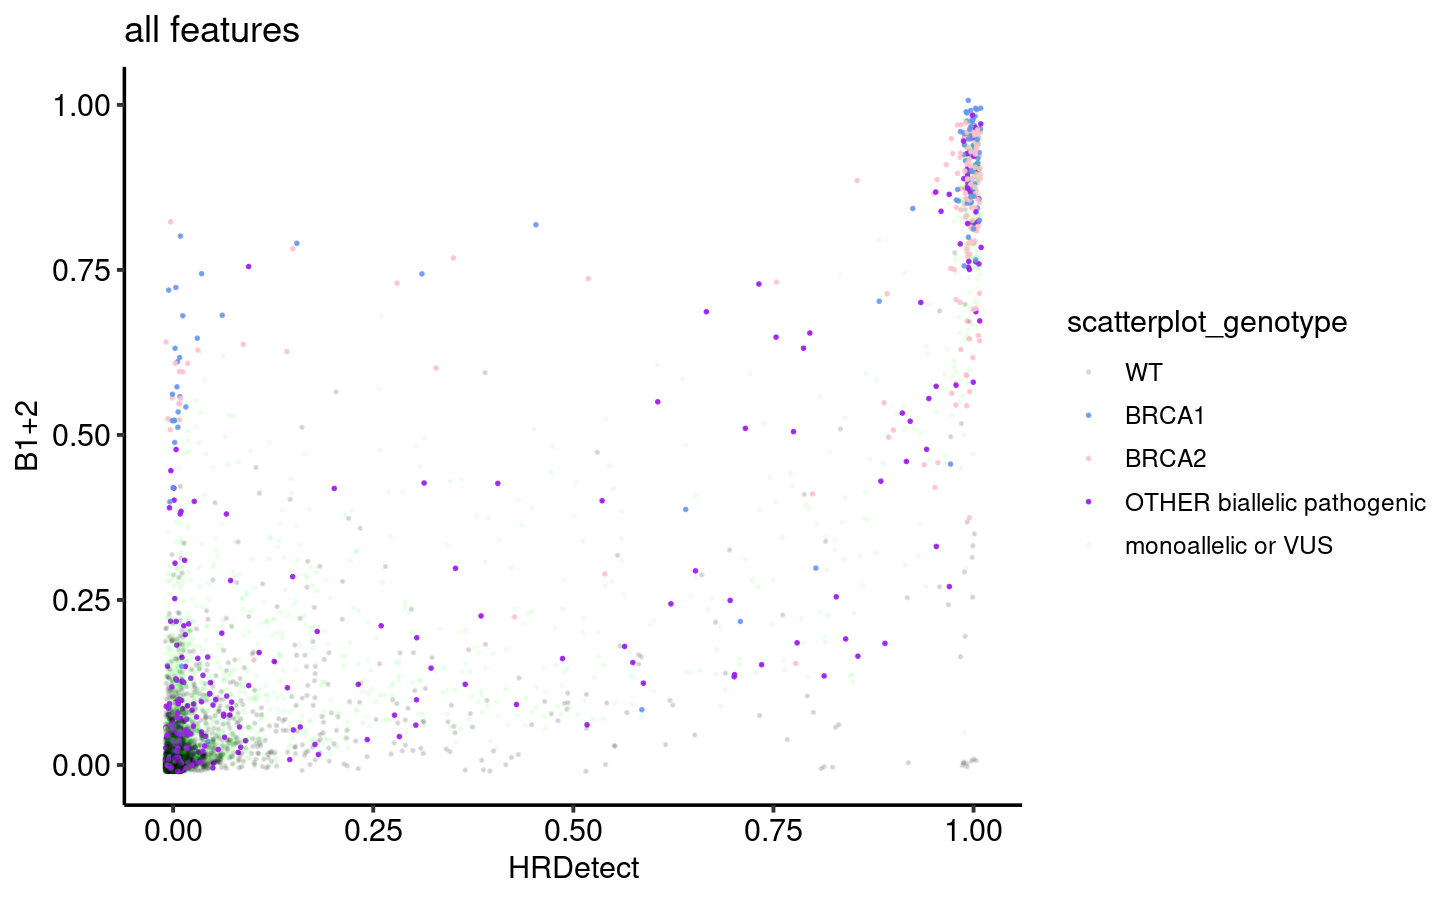

In [226]:
options(repr.plot.width = 8, repr.plot.height = 5, repr.plot.res = 180)
print(pt)

# EDF8e

HRDetect SV features only score versus B1+2 SV features only score, with points colored by genotype.
Note that the code for EDF8d must be run before the following cells can be run.

In [227]:
pt = ggplot(predictions.dt, aes(x = jitter(hrd_svonly, amount = 0.01), y = jitter(b12_svonly, amount = 0.01), colour = scatterplot_genotype)) +
    geom_point(size = 0.1) + scale_colour_manual(values = colpal) +
    ggpubr::theme_pubr() +
    labs(x = "HRDetect SV only", y = "B1+2 SV only", title = "SV features only") +
    theme(legend.position = "right")

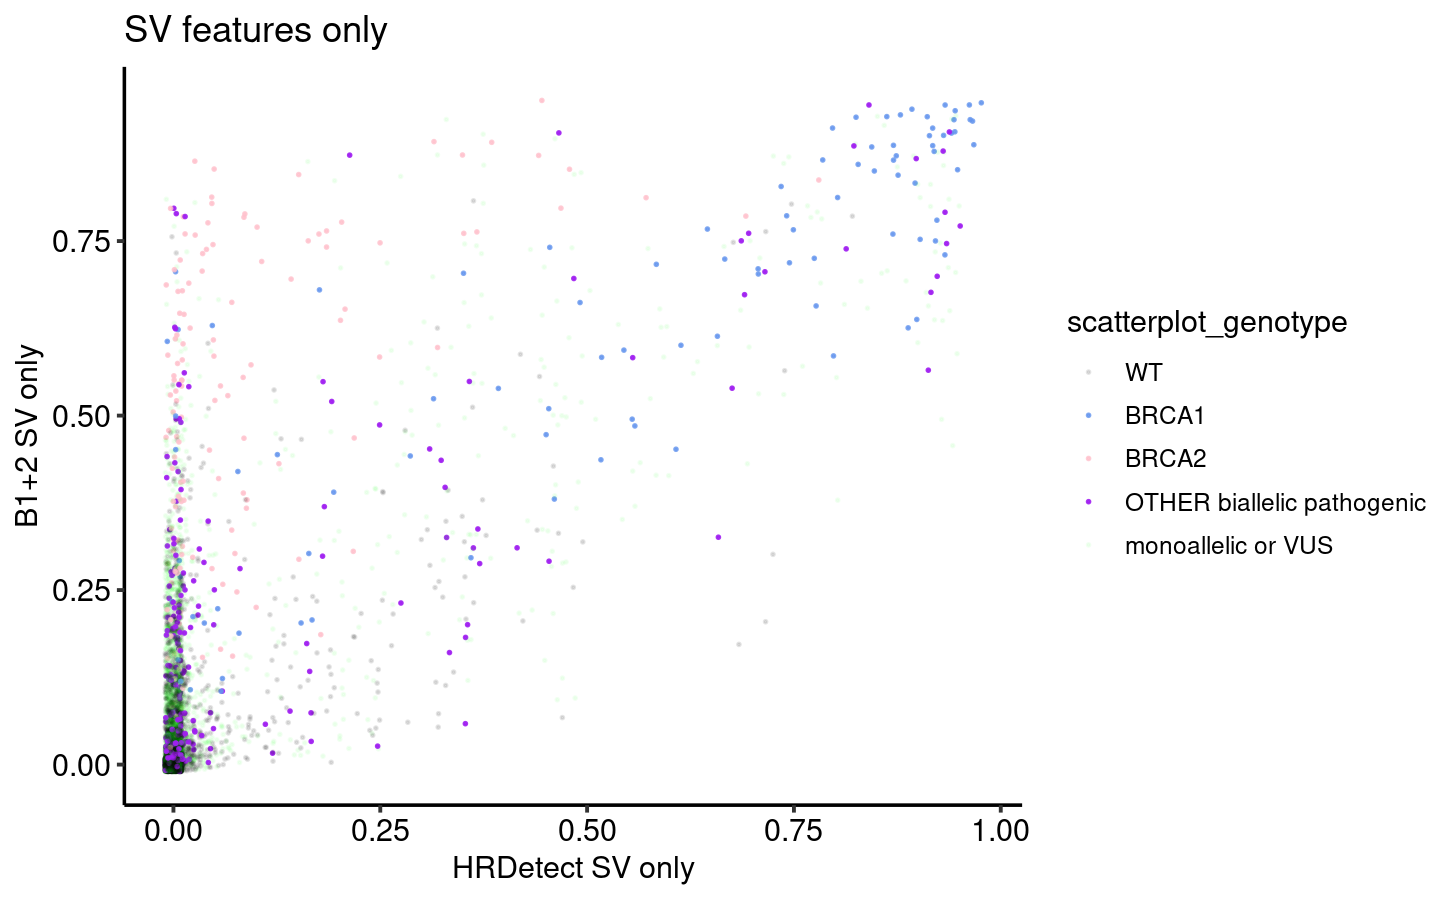

In [228]:
options(repr.plot.width = 8, repr.plot.height = 5, repr.plot.res = 180)
print(pt)

# EDF9d

In [238]:
## train b1 vs b2 classifier on all samples
##b12.train.1v2.x = as.data.frame(all.features.dt[(train.set), .SD, .SDcols = features_hrd_kh])
##hrd.train.1v2.x = as.data.frame(all.features.dt[(train.set), .SD, .SDcols = features_hrd_only])

## response variable is the same
##train.1v2.y = all.features.dt[(train.set) & (fmut_bi != "WT"), ordered(fmut_bi, levels = c("BRCA2", "BRCA1"))]
##train.b1.y = all.features.dt[(train.set), ordered(ifelse(fmut_bi == "BRCA1", "BRCA1", "OTHER"), levels = c("OTHER", "BRCA1"))]
## = all.features.dt[(train.set), ordered(ifelse(fmut_bi == "BRCA2", "BRCA2", "OTHER"), levels = c("OTHER", "BRCA2"))]

## get ALL features from the test set
##all.samples.x = as.data.frame(all.features.dt[, .SD, .SDcols = features_hrd_kh])

In [239]:
##set.seed(10)
##rf.b1 = randomForest::randomForest(x = b12.train.1v2.x, y = train.b1.y, ntree = 1000, importance = TRUE)

##set.seed(10)
##rf.b2 = randomForest::randomForest(x = b12.train.1v2.x, y = train.b2.y, ntree = 1000, importance = TRUE)

In [240]:
## get a data table with predictions
##predictions.dt = all.features.dt[, .(sample,
##                                     tumor_type_final = hrd_tbl[sample, tumor_type_final],
##                                     b1 = predict(rf.b1, all.samples.x, type = "prob")[, -1],
##                                     b2 = predict(rf.b2, all.samples.x, type = "prob")[, -1])]



In [265]:
predictions.dt = readRDS("./data/random_forest/predictions.dt.rds")
predictions.dt[, ":="(b1 = hrd_tbl[sample, BRCA1], b2 = hrd_tbl[sample, BRCA2])]
## get predictions for tumor type and pan-cancer
tt.predictions.dt = rbind(predictions.dt[, .SD][, tumor_type_final := hrd_tbl[sample, tumor_type_final]],
                          predictions.dt[, .SD][, tumor_type_final := "PAN-CANCER"])

In [266]:
## make a bar plot with all tumors
pt.dt = tt.predictions.dt[, .(n = .SD[(b1 + b2 > 0.5), .N], tot = .N), by = .(tumor_type_final)][tot > 20]

pt.dt[, ci.lower := mapply(function(x, y) {skitools::dflm(prop.test(x, y))$ci.lower}, n, tot) %>% unlist] 
pt.dt[, ci.upper := mapply(function(x, y) {skitools::dflm(prop.test(x, y))$ci.upper}, n, tot) %>% unlist] 
pt.dt[, frac := n / tot]

In [267]:
pt.dt[, tumor_type_level := ordered(tumor_type_final, levels = pt.dt[order(frac), tumor_type_final])]

pt = ggplot(pt.dt[!is.na(tumor_type_level)], aes(x = tumor_type_level, y = frac)) +
geom_bar(stat = "identity") +
geom_errorbar(aes(ymin = ci.lower, ymax = ci.upper), width = 0.2, position = "dodge")+
ggpubr::theme_pubr() +
labs(x = "tumor type", y = "fraction", title = "B1+B2 > 0.5") +
theme(axis.text.x = element_text(angle = 90))

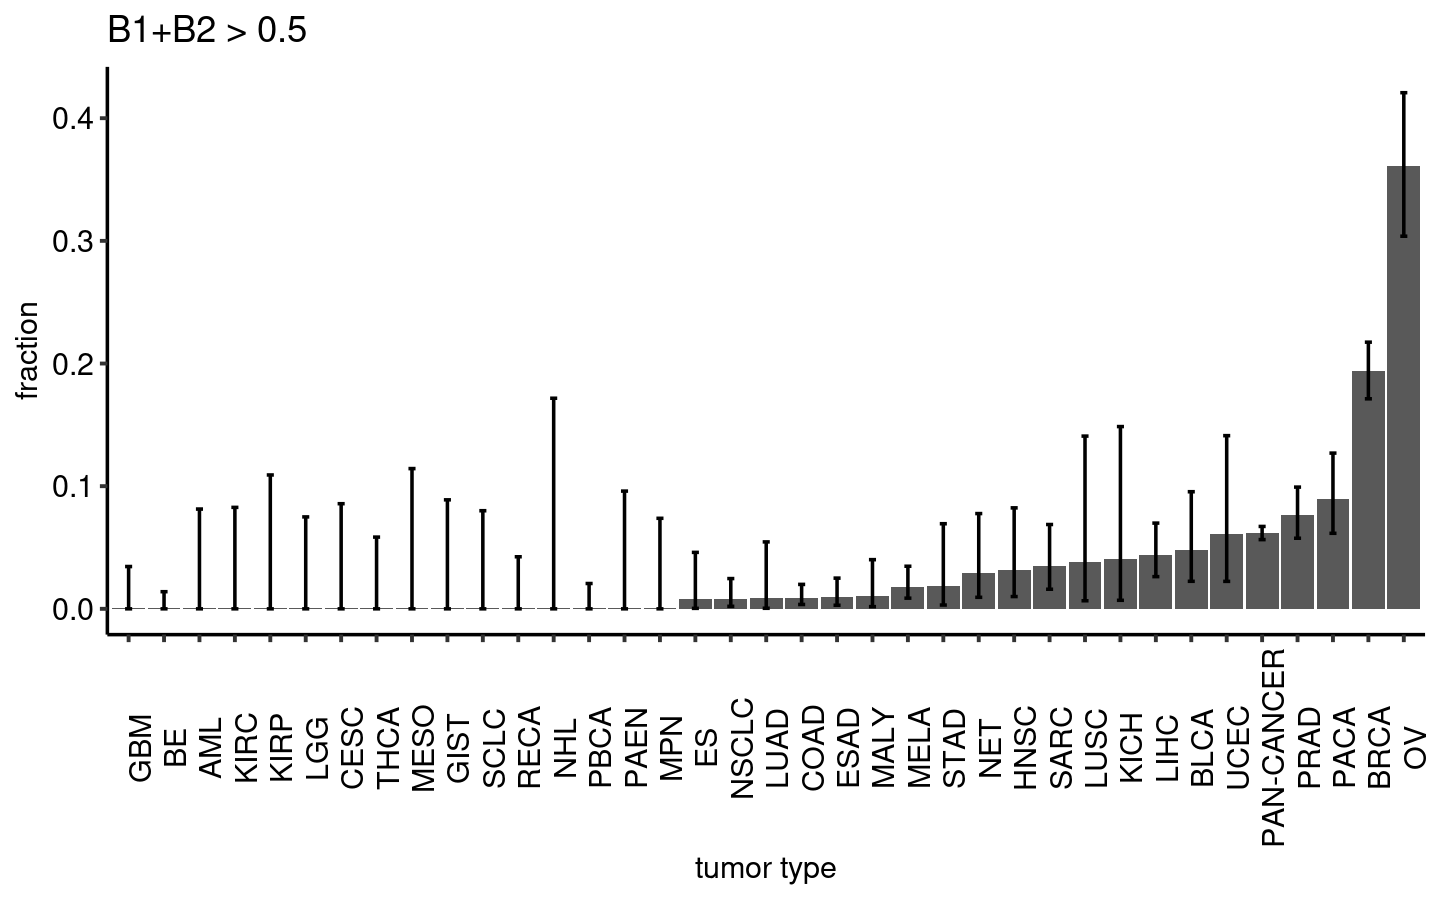

In [268]:
options(repr.plot.width = 8, repr.plot.height = 5, repr.plot.res = 180)
print(pt)

## EDF9e

In [269]:
## get a data table with predictions
##predictions.dt = all.features.dt[, .(sample,
##                                     tumor_type_final = hrd_tbl[sample, tumor_type_final],
##                                     b1 = predict(rf.b1, all.samples.x, type = "prob")[, -1],
##                                     b2 = predict(rf.b2, all.samples.x, type = "prob")[, -1])]

predictions.dt = readRDS("./data/random_forest/predictions.dt.rds")
predictions.dt[, ":="(b1 = hrd_tbl[sample, BRCA1], b2 = hrd_tbl[sample, BRCA2])]
## get predictions for tumor type and pan-cancer
tt.predictions.dt = rbind(predictions.dt[, .SD][, tumor_type_final := hrd_tbl[sample, tumor_type_final]],
                          predictions.dt[, .SD][, tumor_type_final := "PAN-CANCER"])

In [270]:
## make a bar plot with tumor types where b2 > b1
pt.dt = tt.predictions.dt[, .(nb2 = .SD[(b1 > 0.3 | b2 > 0.3) & (b2 > b1), .N],
                              n = .SD[(b1 > 0.3 | b2 > 0.3), .N], 
                              tot = .N), by = .(tumor_type_final)][n >= 10]

pt.dt[, ci.lower := mapply(function(x, y) {skitools::dflm(prop.test(x, y))$ci.lower}, nb2, n) %>% unlist] 
pt.dt[, ci.upper := mapply(function(x, y) {skitools::dflm(prop.test(x, y))$ci.upper}, nb2, n) %>% unlist] 
pt.dt[, frac := nb2 / n]

In [271]:
pt.dt[, tumor_type_level := ordered(tumor_type_final, levels = pt.dt[order(frac), tumor_type_final])]

pt = ggplot(pt.dt[!is.na(tumor_type_level)], aes(x = tumor_type_level, y = frac)) +
geom_bar(stat = "identity") +
geom_errorbar(aes(ymin = ci.lower, ymax = ci.upper), width = 0.2, position = "dodge")+
ggpubr::theme_pubr() +
labs(x = "tumor type", y = "fraction", title = "B1+2-positive tumors with B2 > B1") +
theme(axis.text.x = element_text(angle = 90))

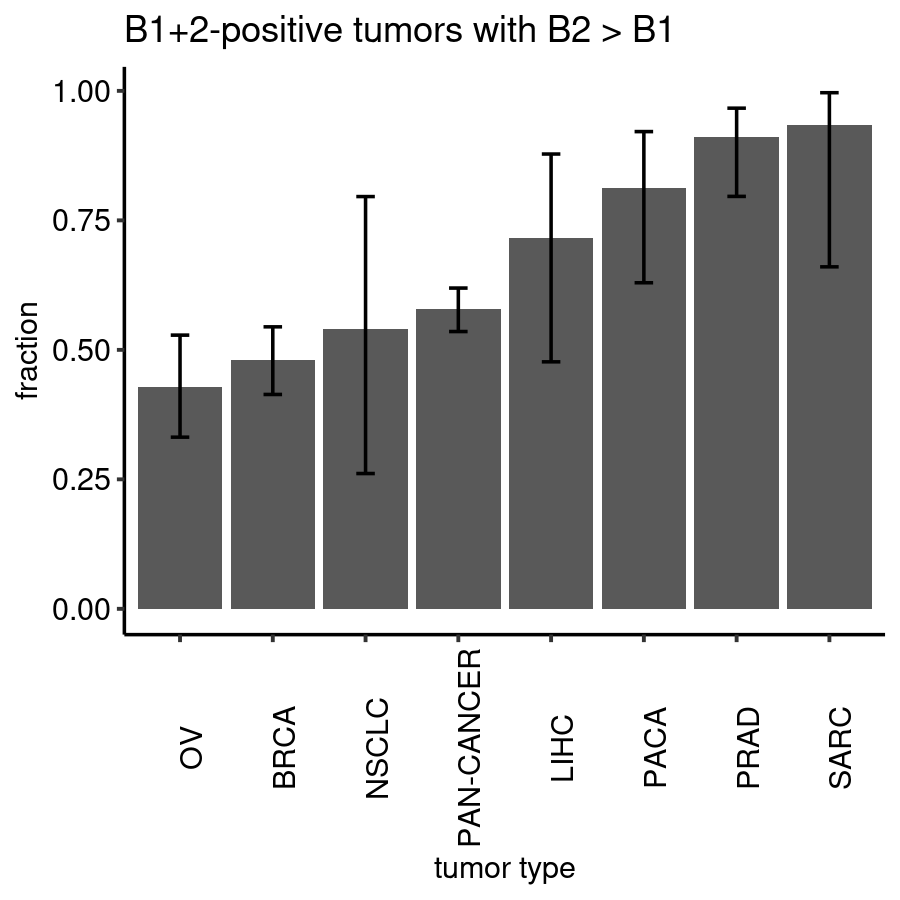

In [272]:
options(repr.plot.width = 5, repr.plot.height = 5, repr.plot.res = 180)
print(pt)

## EDF9f

number of B1+2-positive (B1+ B2 score >0.5) cases with B1>B2 or B2>B1 and harboring biallelic or mono-allelic and pathogenic or VUS variants in HR-associated genes(see Results and Methods for more detailed definitions). 

In [281]:
## get a data table with predictions
predictions.dt = readRDS("./data/random_forest/predictions.dt.rds")
predictions.dt[, ":="(b1 = hrd_tbl[sample, BRCA1], b2 = hrd_tbl[sample, BRCA2])]
## predictions.dt = all.features.dt[, .(sample,
##                                     b1 = predict(rf.b1, all.samples.x, type = "prob")[, -1],
##                                     b2 = predict(rf.b2, all.samples.x, type = "prob")[, -1])]

In [284]:
## unroll predictions
og.genes.dt = rbind(hrd_tbl[, .(pair, genes = biallelic_pathogenic_tier2)],
                    hrd_tbl[, .(pair, genes = biallelic_pathogenic_tier3)],
                    hrd_tbl[, .(pair, genes = monoallelic_pathogenic_tier2)],
                    hrd_tbl[, .(pair, genes = monoallelic_pathogenic_tier3)],
                    hrd_tbl[, .(pair, genes = biallelic_vus_tier2)],
                    hrd_tbl[, .(pair, genes = biallelic_vus_tier3)],
                    hrd_tbl[, .(pair, genes = monoallelic_vus_tier2)],
                    hrd_tbl[, .(pair, genes = monoallelic_vus_tier3)])

og.genes.dt = unique(og.genes.dt[!is.na(genes)])
                    
split_genes = strsplit(og.genes.dt[, genes], ",")
split_genes_samples = rep(og.genes.dt[, pair], lengths(split_genes))

genes.dt = data.table(sample = split_genes_samples, gene = unlist(split_genes))[!is.na(gene)]

In [285]:
table(genes.dt[, gene])


   AUNIP   BABAM1    BARD1    BRCC3    BRIP1     EME1     EME2     EXO1 
     148       36      123       51      114      169       94      239 
 FAM175A   FIGNL1     GEN1    H2AFX     HELQ     MCM8     MCM9     MDC1 
      46      181      574      202      181      160      410      888 
  MRE11A    MUS81      NBN    PALB2    RAD50    RAD51 RAD51AP1   RAD51B 
      84      197       99      392      152       29       64      332 
  RAD51C   RAD51D    RAD52   RAD54B   RAD54L    RBBP8     REV1     RMI1 
      85       70       54       93      259      184      130       77 
    RMI2     RPA1     RPA2    RTEL1     SFR1    SHFM1    SLX1A    SLX1B 
      20       75       91      145       22        4        1       19 
    SLX4   SWSAP1    UIMC1    XRCC2    XRCC3   ZSWIM7 
     239       72      199       21       72       70 

In [289]:
setkey(predictions.dt, "sample")

genes.dt[, b1 := predictions.dt[sample, b1]]
genes.dt[, b2 := predictions.dt[sample, b2]]
genes.dt[, ot := (b1 + b2) >= 0.5]
genes.dt[, b1v2 := ifelse(b1 > b2, "B1 > B2", "B2 > B1")]

genes.dt[, gene_factor := ordered(gene, levels = genes.dt[(ot), .(s = .N), by = gene][order(s), gene])]

In [290]:
## redefine colomap
cmap = c("B1 > B2"="cornflowerblue", "B2 > B1"="pink")

pt = ggplot(genes.dt[(ot)], aes(x = gene_factor, fill = b1v2)) +
geom_bar(position = "stack") +
ggpubr::theme_pubr() +
labs(x = "gene", y = "count") +
scale_fill_manual(values = cmap) +
theme(axis.text.x = element_text(angle = 90))

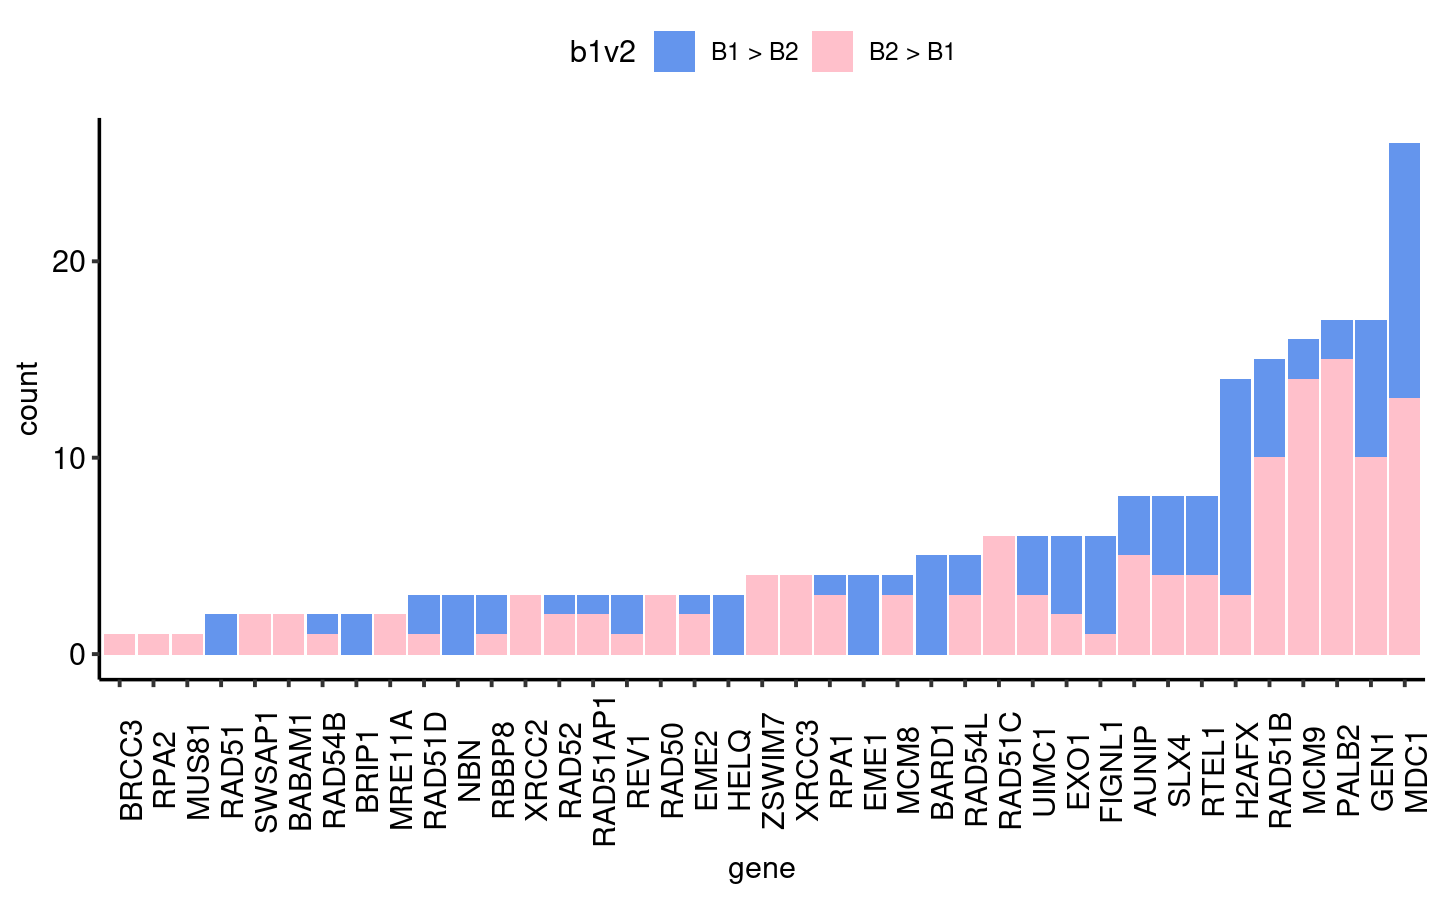

In [291]:
options(repr.plot.width = 8, repr.plot.height = 5, repr.plot.res = 180)
print(pt)